# Porównanie różnych metod prognozowania sprzedaży artykułów spożywczych w przedsiębiorstwie FMCG

# Zrozumienie biznesu

Celem niniejszego projektu jest poprawa jakości prognoz ilości sprzedaży artykułów spożywczych objętych promocjami w przedsiębiorstwie działającym na rynku FMCG. Projekt skupia się na zbadaniu możliwości wykorzystania zaawansowanych metod data science wykorzystujących autoregresje, analizę sezonowości, lasy losowe/boosting, regresja oraz sieci neuronowe, w celu uwzględnienia aktualnych trendów sprzedaży.

Praca badawcza koncentruje się na jednym z asortymentów sieci sprzedaży i będzie wykorzystywać dane z własnego data warehouse firmy, obejmujące takie informacje jak cena produktu, dzienna sprzedaż i obrót na sklep, rodzaj promocji oraz cenę przed promocją. Istotne jest zrozumienie specyfiki rynku FMCG, konkurencji oraz preferencji i potrzeb klientów, co pozwoli na lepsze dostosowanie oferty promocyjnej do ich oczekiwań.

Eksperymenty na danych sprzedażowych z ostatnich 3 lat zostaną przeprowadzone w celu porównania skuteczności różnych metod w przewidywaniu sprzedaży artykułów promocyjnych. Wyniki tych badań mogą mieć istotne znaczenie dla firm, które chcą zoptymalizować swoje kampanie promocyjne i zwiększyć swoje zyski.


Plan wdrożenia obejmuje analizę danych, opracowanie i testowanie różnych modeli predykcyjnyh oraz wdrożenie modelu o najlepszych parametrach w praktyce. Realizacja projektu będzie przebiegać zgodnie z metodologią CRISP-DM.


## Import

### Import bibliotek

In [1]:
%%capture
pip install pmdarima

In [2]:
# Podstawowe biblioteki
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import warnings
import gc

# Opcje
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 50)
sns.color_palette('magma', as_cmap=True)
warnings.filterwarnings('ignore', category=FutureWarning)
%matplotlib inline

import functions as ff

# Klasteryzacja
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.cluster.vq import whiten, kmeans, vq
from sklearn.preprocessing import StandardScaler

# Random
import random
random.seed(42)

#EDA
from statsmodels.tsa.seasonal import seasonal_decompose

# Metryki
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Strojenie parametrów modelów
from itertools import product
import random
from random import randint

# Cross walidacja danych typu time series
from sklearn.model_selection import TimeSeriesSplit

#KNNR
from sklearn.neighbors import KNeighborsRegressor

# SARIMAX
from pmdarima import auto_arima

# Prophet
from prophet import Prophet
import holidays

# Boosting
import xgboost as xgb
from xgboost import XGBRFRegressor
import scipy.sparse as sp

# Transformacje danych
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

# Sieci neuronowe
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Embedding, Concatenate, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.utils import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from functools import partial


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import danych

In [ ]:
# Import CSV
df = pd.read_csv('CSV/dane.csv', sep=',', parse_dates=['DATA'])
# Ograniczenie ilości danych
random_values = [random.randint(1, 238) for _ in range(150)]
df = df[df['MARKET_ID'].isin(random_values)]

In [ ]:
# Import CSV
kalendarz = pd.read_csv('CSV/kalendarz.csv',sep=';', parse_dates=['DATA'], date_parser=ff.dateparser)
del kalendarz[kalendarz.columns[10]]
HICP = pd.read_csv('CSV/HICP.csv', sep=';',parse_dates=['DATA'], date_parser=ff.dateparser)
promo_ceny = pd.read_csv('CSV/PROMO_CENY.csv', sep=';',parse_dates=['DATA'])

## Wstępne opisanie danych

In [ ]:
df.head()

DATA  MARKET_ID  GRUPA_ID  ART_ID  OBROT  ILOSC  \
696 2019-09-02          2        19       1    0.0    0.0   
697 2019-09-02          2         8       2    0.0    0.0   
698 2019-09-02          2         8       3    0.0    0.0   
699 2019-09-02          2         8       4    0.0    0.0   
700 2019-09-02          2         8       5    0.0    0.0   

                            NAZWA  
696  FCHKWROVC QD JROULRGU FDSYVR  
697                   JHSDL ERSCR  
698            JHSDL FCHS QH YRFD  
699                   JHSDL WDSGU  
700              JHSDL KRLGRSDZFH

DataFrame **df** tworzy główną oś i prezentuje dane dotyczące sprzedaży różnych artykułów spożywczych w różnych marketach w określonym dniu.  
Kolumny zawierają następujące informacje:

*DATA*: data sprzedaży (np. 2020-02-13),  
*MARKET_ID*: unikalne ID marketu, w którym doszło do sprzedaży (np. 1, 4, 6),  
*GRUPA_ID*: identyfikator grupy produktowej, do której należy dany artykuł (np. 19, 8),  
*ART_ID*: unikalne ID artykułu (np. 1, 2),  
*OBROT*: całkowita wartość sprzedaży danego artykułu w PLN (np. 3.31, 22.21),  
*ILOSC*: ilość sprzedanych sztuk danego artykułu (np. 1.00, 2.92),  
*NAZWA*: zakodowana nazwa artykułu (np. 'FCHKWROVC QD JROULRGU FDSYVR').

In [ ]:
df.describe().T

count        mean         std      min    25%    50%    75%  \
MARKET_ID  89277712.0  119.642269   69.127846     2.00   58.0  118.0  177.0   
GRUPA_ID   89277712.0   13.910693    8.134427     1.00    5.0   14.0   22.0   
ART_ID     89277712.0  348.548119  200.995705     1.00  175.0  349.0  522.0   
OBROT      89277712.0   17.559285   89.004770  -699.20    0.0    0.0    0.0   
ILOSC      89277712.0    4.080592   26.660253 -1024.34    0.0    0.0    0.0   

                max  
MARKET_ID    237.00  
GRUPA_ID      26.00  
ART_ID       697.00  
OBROT      10973.85  
ILOSC       6003.23

In [ ]:
df.shape

(89277712, 7)

**Obserwacja:** Kolumny 'OBROT' i 'ILOSC' przyjmują wartości ujemne - wymagane jest oczyszczenie danych.
<br>
<br>

In [ ]:
kalendarz.head()

DATA  Nr_dn_tyg  Nr_dn_mies  Nr_mies  Nr_tyg  Nr_rok  Dn_handlowy  \
0 2019-01-01          2           1        1       1    2019            0   
1 2019-01-02          3           2        1       1    2019            1   
2 2019-01-03          4           3        1       1    2019            1   
3 2019-01-04          5           4        1       1    2019            1   
4 2019-01-05          6           5        1       1    2019            1   

   Hot_day  Hot_day_Xmass  Hot_day_Wlkn  
0        1              0             0  
1        0              0             0  
2        0              0             0  
3        0              0             0  
4        0              0             0

In [ ]:
kalendarz.describe().T

count         mean        std     min     25%     50%     75%  \
Nr_dn_tyg      1826.0     4.001643   1.999862     1.0     2.0     4.0     6.0   
Nr_dn_mies     1826.0    15.727820   8.801735     1.0     8.0    16.0    23.0   
Nr_mies        1826.0     6.523549   3.449478     1.0     4.0     7.0    10.0   
Nr_tyg         1826.0    26.615553  15.065085     1.0    14.0    27.0    40.0   
Nr_rok         1826.0  2020.999452   1.414407  2019.0  2020.0  2021.0  2022.0   
Dn_handlowy    1826.0     0.855422   0.351772     0.0     1.0     1.0     1.0   
Hot_day        1826.0     0.035597   0.185334     0.0     0.0     0.0     0.0   
Hot_day_Xmass  1826.0    -0.217963   1.752220   -14.0     0.0     0.0     0.0   
Hot_day_Wlkn   1826.0    -0.210843   1.766325   -14.0     0.0     0.0     0.0   

                  max  
Nr_dn_tyg         7.0  
Nr_dn_mies       31.0  
Nr_mies          12.0  
Nr_tyg           53.0  
Nr_rok         2023.0  
Dn_handlowy       1.0  
Hot_day           1.0  
Hot_day_Xmass     7.0  
Hot_day_Wlkn      7.0

Do projektu zostanie użyty zewnętrzny dataframe **kalendarz** zawierający informacje takie jak numery dni tygodnia, miesiąca i roku, czy dany dzień był dniem handlowym oraz inne specjalne oznaczenia dni.  
Kolumny zawierają następujące informacje:

*DATA*: data (np. 2019-01-01, 2019-01-02),
*Nr_dn_tyg*: numer dnia tygodnia (np. 2 - wtorek, 3 - środa),  
*Nr_dn_mies*: numer dnia miesiąca (np. 1, 2),  
*Nr_mies*: numer miesiąca (np. 1 - styczeń),  
*Nr_tyg*: numer tygodnia w roku (np. 1),  
*Nr_rok*: rok (np. 2019),  
*Dn_handlowy*: oznaczenie, czy dany dzień był dniem handlowym (1 - tak, 0 - nie),  
*Hot_day*: oznaczenie, czy dany dzień był dniem specjalnym (1 - tak, 0 - nie),  
*Hot_day_Xmass*: oznaczenie, czy dany dzień był dniem świątecznym (skala od -14 do 7, gdzie -14 oznacza 14 dni przed świętem),    
*Hot_day_Wlkn*: oznaczenie, czy dany dzień był dniem wolnym od pracy ((skala od -14 do 7, gdzie -14 oznacza 14 dni przed świętem).
<br>
<br>

In [ ]:
promo_ceny.head()

DATA  ART_ID  CENA_NP  CENA_AP  PRZECENA  PROMO_KOD
0 2019-09-02       1     3.49     3.49       0.0          0
1 2019-09-03       1     3.49     3.49       0.0          0
2 2019-09-04       1     3.49     3.49       0.0          0
3 2019-09-05       1     3.49     3.49       0.0          0
4 2019-09-06       1     3.49     3.49       0.0          0

DataFrame **promo_ceny** prezentuje dane dotyczące cen oraz promocji produktów w określonym czasie.  
Kolumny zawierają następujące informacje:

*DATA*: data, na którą dotyczy dany wiersz (np. 2019-06-06, 2019-06-07),  
*ART_ID*: unikalny identyfikator produktu (np. 362),  
*CENA_NP*: cena normalna, w przypadku promocji przyjmuje ostatnią cenę przed promocją (np. 1.99),  
*CENA_AP*: cena promocyjna w przypadku występowaniu promocji, w przypadku braku promocji przyjmuje wartośc w kolumny CENA_NP (np. 2.99),  
*PRZECENA*: procent obniżki w przypadku obniżenia ceny w trakcie promocji (np. 0.333 = 33.3%) ,  
*PROMO_KOD*: kod promocji związanej z danym produktem (np. 13).

In [ ]:
promo_ceny.describe().T

count        mean         std  min     25%     50%     75%  \
ART_ID     681470.0  320.239845  187.725068  1.0  156.00  318.00  483.00   
CENA_NP    681470.0    7.269196    5.321974  0.1    4.49    5.99    8.99   
CENA_AP    681470.0    7.211979    5.315129  0.1    4.49    5.99    8.56   
PRZECENA   681470.0    0.007850    0.053133  0.0    0.00    0.00    0.00   
PROMO_KOD  681470.0    0.621079    7.751325  0.0    0.00    0.00    0.00   

               max  
ART_ID     697.000  
CENA_NP     55.920  
CENA_AP     55.920  
PRZECENA     0.841  
PROMO_KOD  154.000

**Obserwacja:** W tabelach *kalendarz* oraz *promo_ceny* istnieją kolumny, które reprezentują dane zmienne kategoryczne - wymagane jest dostosowanie typu danych.
<br>
<br>

In [ ]:
HICP.head(2)

DATA   HICP
0 2019-01-01  103.0
1 2019-01-02  103.0

DataFrame **HICP** prezentuje dane dotyczące wskaźnika harmonizowanego indeksu cen konsumpcyjnych (HICP) w określonym czasie. Kolumny zawierają następujące informacje:

*DATA*: data, na którą dotyczy dany wiersz (np. 2019-01-01, 2019-01-02),  
*HICP*: wartość wskaźnika harmonizowanego indeksu cen konsumpcyjnych (np. 103.0).

HICP jest miarą inflacji, która jest używana przez Unię Europejską i inne międzynarodowe organizacje do monitorowania i porównywania cen towarów i usług konsumpcyjnych między krajami. Ten DataFrame może być wykorzystany do analizy zmian inflacji w czasie lub do porównania poziomów inflacji między różnymi okresami.
<br>

## Preprocessing danych oraz feature engineering

### Preprocessing

In [ ]:
# Wyzerowanie wierszy dla których sprzedaż wynosi zero lub jest ujemna (błąd danych)
df.loc[df['ILOSC'] <= 0, 'ILOSC'] = 0 
df.loc[df['ILOSC'] <= 0, 'OBROT'] = 0 
# Wyzerowanie wierszy dla których obrót wynosi zero lub jest ujemny (błąd danych)
df.loc[df['OBROT'] <= 0, 'OBROT'] = 0 
df.loc[df['OBROT'] <= 0, 'ILOSC'] = 0

In [ ]:
df.head()

DATA  MARKET_ID  GRUPA_ID  ART_ID  OBROT  ILOSC  \
696 2019-09-02          2        19       1    0.0    0.0   
697 2019-09-02          2         8       2    0.0    0.0   
698 2019-09-02          2         8       3    0.0    0.0   
699 2019-09-02          2         8       4    0.0    0.0   
700 2019-09-02          2         8       5    0.0    0.0   

                            NAZWA  
696  FCHKWROVC QD JROULRGU FDSYVR  
697                   JHSDL ERSCR  
698            JHSDL FCHS QH YRFD  
699                   JHSDL WDSGU  
700              JHSDL KRLGRSDZFH

In [ ]:
# Sortowanie danych
df.sort_values(['ART_ID', 'MARKET_ID', 'DATA'], inplace=True)

In [ ]:
# Masak, aby uniknąć dzielenia przez ero
mask = df['ILOSC'] != 0
# Obliczenie średniej ceny sprzedaży per market - cenam market uwzględnia ewentualne przeceny produktów lub odpisy
df['CENA_MARKET'] = np.round(np.divide(df['OBROT'][mask], df['ILOSC'][mask]),4)

In [ ]:
df.isnull().sum()

DATA                  0
MARKET_ID             0
GRUPA_ID              0
ART_ID                0
OBROT                 0
ILOSC                 0
NAZWA                 0
CENA_MARKET    68247708
dtype: int64

**Obserwacja**: Dataframe zawiera NaN dla CENA_MARKET - wynikają one z kombinacji artykuł-dzień dla dni niehandlowych, gdzie nie było sprzedaży.

In [ ]:
df.describe().T

count        mean         std   min      25%       50%  \
MARKET_ID    89277712.0  119.642269   69.127846  2.00   58.000  118.0000   
GRUPA_ID     89277712.0   13.910693    8.134427  1.00    5.000   14.0000   
ART_ID       89277712.0  348.548119  200.995705  1.00  175.000  349.0000   
OBROT        89277712.0   17.559483   89.004489  0.00    0.000    0.0000   
ILOSC        89277712.0    4.080637   26.659994  0.00    0.000    0.0000   
CENA_MARKET  21030004.0    5.932942    3.799394  0.01    3.515    4.7546   

               75%       max  
MARKET_ID    177.0    237.00  
GRUPA_ID      22.0     26.00  
ART_ID       522.0    697.00  
OBROT          0.0  10973.85  
ILOSC          0.0   6003.23  
CENA_MARKET    7.6   1184.50

**Obserwacja:** Kolumna 'CENA_MARKET' zawiera wartości odstające (błędne) - konieczne jest oczyszczenie danych.

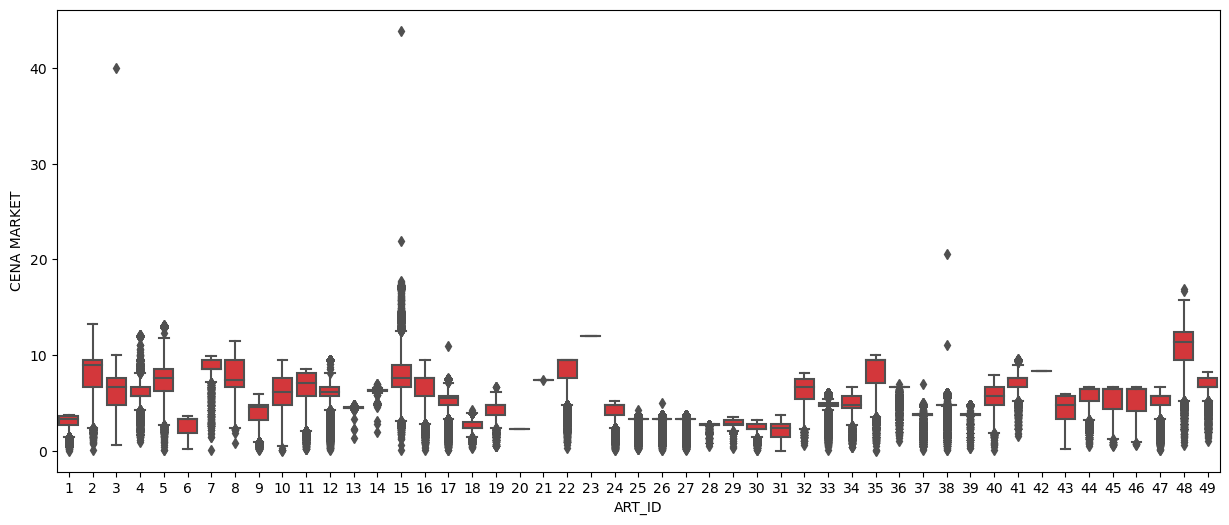

In [ ]:
# Tworzenie podzbioru danych na podstawie warunku ART_ID < 50
filtered_df = df[df['ART_ID'] < 50]

# Tworzenie wykresu pudełkowego
plt.figure(figsize=(15, 6))
sns.boxplot(data=filtered_df, x='ART_ID', y='CENA_MARKET', palette=sns.color_palette(colors * len(filtered_df['ART_ID'].unique())))

# Dodawanie etykiet osi
plt.xlabel('ART_ID')
plt.ylabel('CENA MARKET')

# Wyświetlanie wykresu
plt.show()

**Obserwacja:** Istnieją artykuły posiadające skrajnie wysokie ceny - jest to błąd danych i obserwacje zostaną usunięte.

Zamiana wartości odstających na średnią za pomocą metody IQR:

In [ ]:
# Tworzenie maski, aby wykluczyć zera z obliczeń
mask = df['CENA_MARKET'] != 0

# Obliczenie kwartyli, interkwartylnej i granic odstających wartości
q1 = df[mask].groupby('ART_ID')['CENA_MARKET'].quantile(0.25)
q3 = df[mask].groupby('ART_ID')['CENA_MARKET'].quantile(0.75)
iqr = q3 - q1

upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# Obliczenie średnich wartości dla każdego ART_ID
mean_values = df[mask].groupby('ART_ID')['CENA_MARKET'].mean()

# Zastąpienie wartości spoza granic odstających średnimi wartościami dla odpowiednich ART_ID
df['CENA_MARKET'] = df.groupby('ART_ID')['CENA_MARKET'].transform(
    lambda x: x.mask(x > upper_bound.loc[x.name], mean_values[x.name])
              .mask(x < lower_bound.loc[x.name], mean_values[x.name]))


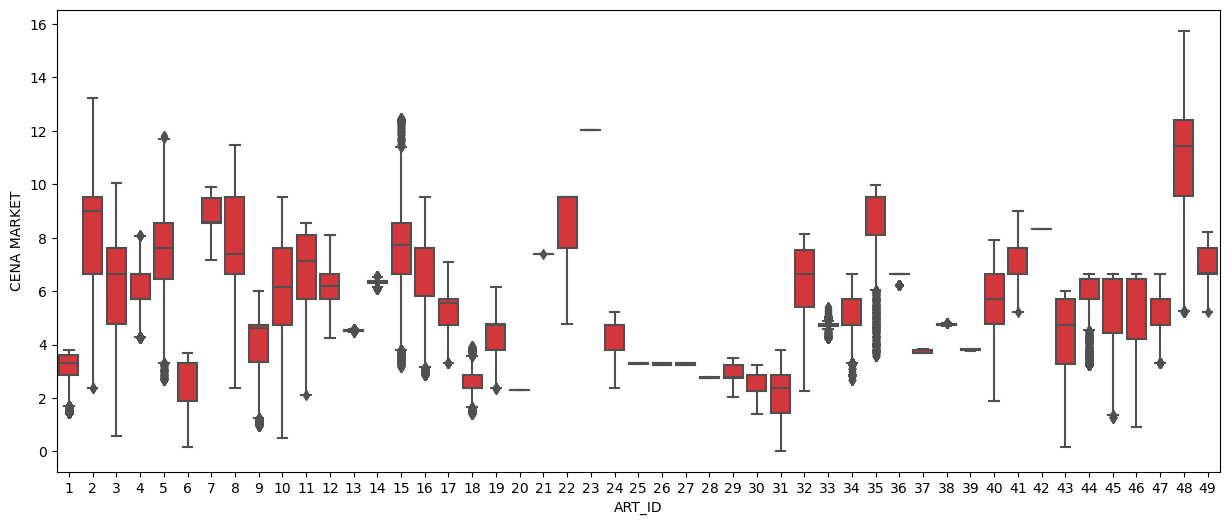

In [ ]:
# Tworzenie podzbioru danych na podstawie warunku ART_ID < 50
filtered_df = df[df['ART_ID'] < 50]

# Tworzenie wykresu pudełkowego
plt.figure(figsize=(15, 6))
sns.boxplot(data=filtered_df, x='ART_ID', y='CENA_MARKET', palette=sns.color_palette(colors * len(filtered_df['ART_ID'].unique())))

# Dodawanie etykiet osi
plt.xlabel('ART_ID')
plt.ylabel('CENA MARKET')

# Wyświetlanie wykresu
plt.show()

In [ ]:
df.describe().T

count        mean         std     min      25%       50%  \
MARKET_ID    89277712.0  119.642269   69.127846  2.0000   58.000  118.0000   
GRUPA_ID     89277712.0   13.910693    8.134427  1.0000    5.000   14.0000   
ART_ID       89277712.0  348.548119  200.995705  1.0000  175.000  349.0000   
OBROT        89277712.0   17.559483   89.004489  0.0000    0.000    0.0000   
ILOSC        89277712.0    4.080637   26.659994  0.0000    0.000    0.0000   
CENA_MARKET  21030004.0    5.959987    3.713719  0.0193    3.665    4.7609   

               75%       max  
MARKET_ID    177.0    237.00  
GRUPA_ID      22.0     26.00  
ART_ID       522.0    697.00  
OBROT          0.0  10973.85  
ILOSC          0.0   6003.23  
CENA_MARKET    7.6     53.00

In [ ]:
df.isnull().sum()

DATA                  0
MARKET_ID             0
GRUPA_ID              0
ART_ID                0
OBROT                 0
ILOSC                 0
NAZWA                 0
CENA_MARKET    68247708
dtype: int64

In [ ]:
# Checkpoint
df.to_pickle('PICKLE/df_temp.pkl') 

In [ ]:
df.shape

(89277712, 8)

### Łączenie tabel

In [ ]:
# Checkpoint
df = pd.read_pickle('PICKLE/df_temp.pkl')

In [ ]:
# Łaczenie tabel
df = pd.merge(df, kalendarz, how='left', on='DATA')
df = pd.merge(df, promo_ceny, how='left', on = ['DATA','ART_ID'])

In [ ]:
# Uzupełnienie cen
df['CENA_MARKET'] = df['CENA_MARKET'].fillna(df['CENA_AP'])
df['CENA_MARKET'] = np.where(df['CENA_MARKET'] > df['CENA_AP'], df['CENA_AP'], df['CENA_MARKET'])

In [ ]:
df.isnull().sum()

DATA                   0
MARKET_ID              0
GRUPA_ID               0
ART_ID                 0
OBROT                  0
ILOSC                  0
NAZWA                  0
CENA_MARKET      9559134
Nr_dn_tyg              0
Nr_dn_mies             0
Nr_mies                0
Nr_tyg                 0
Nr_rok                 0
Dn_handlowy            0
Hot_day                0
Hot_day_Xmass          0
Hot_day_Wlkn           0
CENA_NP          9559134
CENA_AP          9559134
PRZECENA         9559134
PROMO_KOD        9559134
dtype: int64

In [ ]:
# Usunięcie wierszy dla których nie znaleziono ceny (NaN)
df.dropna(how='any', inplace=True) 

In [ ]:
# Łaczenie tabel
df = pd.merge(df, HICP, how='left', on = 'DATA')

In [ ]:
# Dopasowanie typów danych do poszczególnych kolumn
int32 = ['MARKET_ID', 'GRUPA_ID', 'ART_ID', 'PROMO_KOD']
df[int32] = df[int32].astype('int32')

category = ['MARKET_ID', 'GRUPA_ID', 'ART_ID', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 
            'Nr_rok', 'Dn_handlowy', 'Hot_day', 'Hot_day_Xmass', 'Hot_day_Wlkn', 'PROMO_KOD']
df[category] = df[category].astype('category')

float32 =['ILOSC', 'CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP']
df[float32] = df[float32].astype('float32')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 79718578 entries, 0 to 79718577
Data columns (total 22 columns):
 #   Column         Dtype         
---  ------         -----         
 0   DATA           datetime64[ns]
 1   MARKET_ID      category      
 2   GRUPA_ID       category      
 3   ART_ID         category      
 4   OBROT          float64       
 5   ILOSC          float32       
 6   NAZWA          object        
 7   CENA_MARKET    float32       
 8   Nr_dn_tyg      category      
 9   Nr_dn_mies     category      
 10  Nr_mies        category      
 11  Nr_tyg         category      
 12  Nr_rok         category      
 13  Dn_handlowy    category      
 14  Hot_day        category      
 15  Hot_day_Xmass  category      
 16  Hot_day_Wlkn   category      
 17  CENA_NP        float32       
 18  CENA_AP        float32       
 19  PRZECENA       float32       
 20  PROMO_KOD      category      
 21  HICP           float32       
dtypes: category(13), datetime64[ns](1), floa

In [ ]:
# Zmiana nazwy kolumny celu
df.rename(columns = {'ILOSC':'y'}, inplace = True)

In [ ]:
# Zmiana kolejności kolumn
new_order = ['DATA', 'MARKET_ID', 'GRUPA_ID', 'ART_ID', 'NAZWA', 'CENA_NP', 'CENA_AP', 'PRZECENA', 'CENA_MARKET', 'OBROT', 'PROMO_KOD', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok', 'Dn_handlowy', 'Hot_day', 'Hot_day_Xmass', 'Hot_day_Wlkn', 'HICP', 'y'] # Nowa kolejność kolumn
df = df.reindex(columns=new_order)

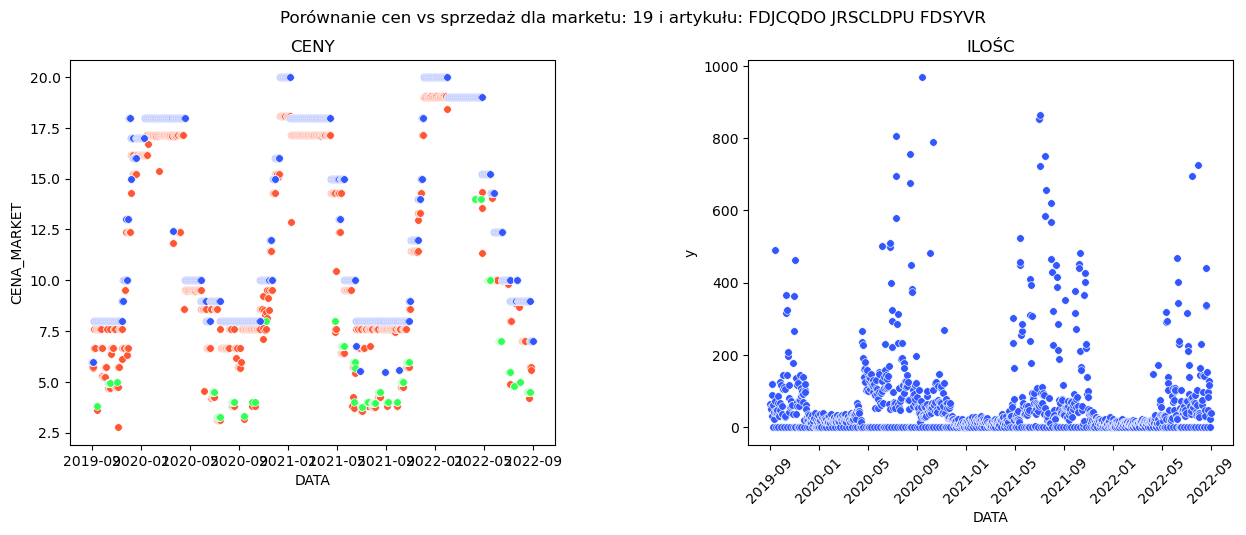

In [ ]:
# Wykres cen (market=19, artykuł=158)
ff.plot_cena(df, 19, 158)

Na obu wykresach (ceny i obrotu) można dostrzec, że artykuł podlega sezonowości rocznej. Interpretacja lewego wykresu:  Najwyższa cena to CENA_NP (Normal Price) - czyli cena ustalona centralnie. W okresach promocyjnych CENA_AP (Actions Price) jest niższa ze względu na akcję promocyjną. Najniższą ceną jest CENA_MARKET, która uwzględnia obniżki cen na poziomie marketu (i/lub odpisy).

Oczyszczone dane wyglądają następująco:

In [ ]:
df.head(3)

DATA MARKET_ID GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-03         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-04         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   

   CENA_AP  PRZECENA  CENA_MARKET  OBROT PROMO_KOD Nr_dn_tyg Nr_dn_mies  \
0     3.49       0.0         3.49    0.0         0         1          2   
1     3.49       0.0         3.49    0.0         0         2          3   
2     3.49       0.0         3.49    0.0         0         3          4   

  Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn  \
0       9     36   2019           1       0             0            0   
1       9     36   2019           1       0             0            0   
2       9     36   2019           1       0             0            0   

         HICP    y  
0  105.199997  0.0  
1  105.199997  0.0  
2  105.199997  0.0

In [ ]:
df.describe().T

count       mean        std         min     25%         50%  \
CENA_NP      79718578.0   3.880406   5.734397    0.100000    4.49    5.990000   
CENA_AP      79718578.0   3.850663   5.692187    0.100000    4.49    5.990000   
PRZECENA     79718578.0   0.007868   0.052690    0.000000    0.00    0.000000   
CENA_MARKET  79718578.0   3.803628   5.621907    0.019300    3.99    5.990000   
OBROT        79718578.0  19.665058  93.969695    0.000000    0.00    0.000000   
HICP         79718578.0  52.634510  41.521702  105.199997  109.00  113.199997   
y            79718578.0   4.256569  27.676815    0.000000    0.00    0.000000   

                    75%           max  
CENA_NP        8.990000     55.919998  
CENA_AP        8.560000     55.919998  
PRZECENA       0.000000      0.841000  
CENA_MARKET    7.990929     55.919998  
OBROT          3.490000  10973.850000  
HICP         118.599998    131.399994  
y              1.000000   6003.229980

In [ ]:
# Checkpoint
df.to_pickle('PICKLE/df.pkl')

### Klasteryzacja

#### Przygotowanie danych

In [ ]:
# Checkpoint
df = pd.read_pickle('PICKLE/df.pkl')

In [ ]:
# Kopia DataFrame'u
df_temp = df[['DATA', 'MARKET_ID', 'ART_ID', 'y', 'CENA_MARKET', 'PROMO_KOD']].copy()
df_temp = df_temp.loc[df['DATA'] >= '2021-09-01']

# Tworzenie maski
mask = df['PROMO_KOD'] == 0

# Wydzielenie danych względem maski
df_temp.loc[mask, 'ILOSC_NIEPROMO'] = df_temp.loc[mask, 'y']
df_temp.loc[mask, 'CENA_NIEPROMO'] = df_temp.loc[mask, 'CENA_MARKET']
df_temp.loc[~mask, 'ILOSC_PROMO'] = df_temp.loc[~mask, 'y']
df_temp.loc[~mask, 'CENA_PROMO'] = df_temp.loc[~mask, 'CENA_MARKET']

# Usunięcie niepotrzebnych kolumn
df_temp.drop(['DATA', 'ART_ID', 'y', 'CENA_MARKET'], axis=1, inplace=True)  

# Grupowanie i obliczanie średnich
df_k = df_temp.groupby(['MARKET_ID'])[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']].agg(np.nanmean)

# Normalizacja min-max
df_k['ILOSC_NIEPROMO'] = df_k['ILOSC_NIEPROMO'] / df_k['ILOSC_NIEPROMO'].max()
df_k['ILOSC_PROMO'] = df_k['ILOSC_PROMO'] / df_k['ILOSC_PROMO'].max()
df_k['CENA_NIEPROMO'] = df_k['CENA_NIEPROMO'] / df_k['CENA_NIEPROMO'].max()
df_k['CENA_PROMO'] = df_k['CENA_PROMO'] / df_k['CENA_PROMO'].max()

df_k2 = df_k.copy()

#### Elbow method

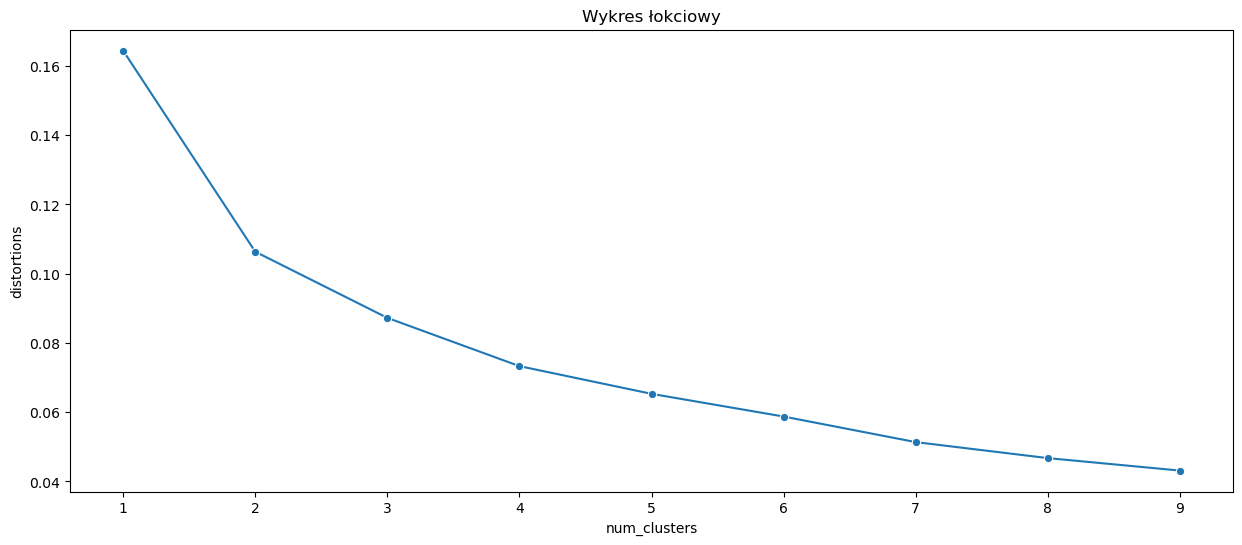

In [ ]:
distortions = []
num_clusters = range(1, 10)

# Obliczenie zniekształceń za pomocą algorytmu k-means dla różnej liczby klastrów
for i in num_clusters:
    cluster_centers, distortion = kmeans(df_k[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']], i)
    distortions.append(distortion)

# Utworzenie ramki danych zawierającej dwie listy: num_clusters i distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Wygenerowanie wykresu liniowego zależności liczby klastrów od zniekształceń
plt.figure(figsize=(15, 6))
sns.lineplot(data=elbow_plot, x='num_clusters', y='distortions', marker='o')
plt.xticks(num_clusters)
plt.title('Wykres łokciowy - analiza liczby klastrów')
plt.xlabel('Liczba klastrów')
plt.ylabel('Zniekształcenie (distortion)')
plt.show()

####  KMeans Clustering

In [ ]:
# Wywołanie algorytmu k-means dla danych df_k[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']] i 5 klastrów
cluster_centers, distortion = kmeans(df_k[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']], 5)

# Przypisanie etykiet klastrów do danych z df_k oraz otrzymanie listy zniekształceń
df_k['CLUSTER_LABELS'], distortion_list = vq(df_k[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']], cluster_centers)

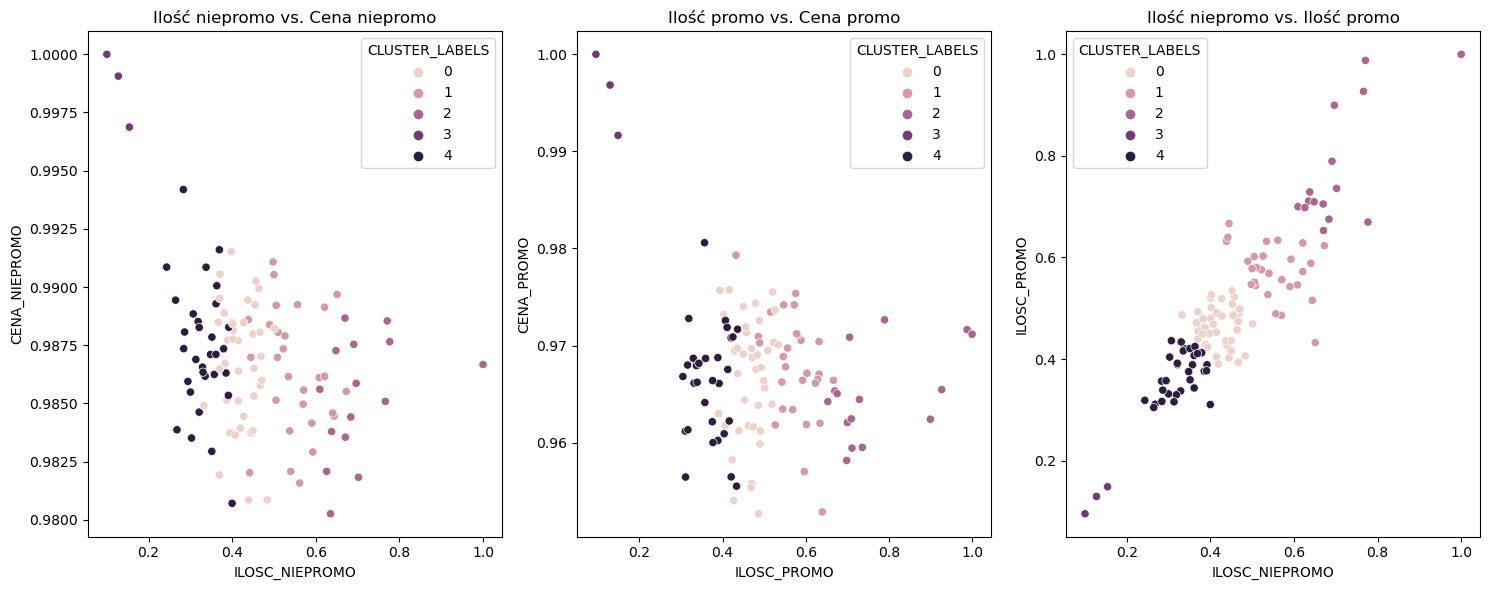

In [ ]:
# Utworzenie trzech subplotów w jednym wierszu
_, axes = plt.subplots(1, 3, figsize=(15, 6))

# Wykres punktowy przedstawiający zależność ILOSC_NIEPROMO od CENA_NIEPROMO, z podziałem na klastry
sns.scatterplot(x='ILOSC_NIEPROMO', y='CENA_NIEPROMO', hue='CLUSTER_LABELS', data=df_k, ax=axes[0])
axes[0].set_title('Ilość niepromo vs. Cena niepromo')

# Wykres punktowy przedstawiający zależność ILOSC_PROMO od CENA_PROMO, z podziałem na klastry
sns.scatterplot(x='ILOSC_PROMO', y='CENA_PROMO', hue='CLUSTER_LABELS', data=df_k, ax=axes[1])
axes[1].set_title('Ilość promo vs. Cena promo')

# Wykres punktowy przedstawiający zależność ILOSC_NIEPROMO od ILOSC_PROMO, z podziałem na klastry
sns.scatterplot(x='ILOSC_NIEPROMO', y='ILOSC_PROMO', hue='CLUSTER_LABELS', data=df_k, ax=axes[2])
axes[2].set_title('Ilość niepromo vs. Ilość promo')

# Dopasowanie i ułożenie subplotów w ramach wyświetlanego obszaru
plt.tight_layout()

# Wyświetlenie wykresów
plt.show()

#### Hierarchical clustering

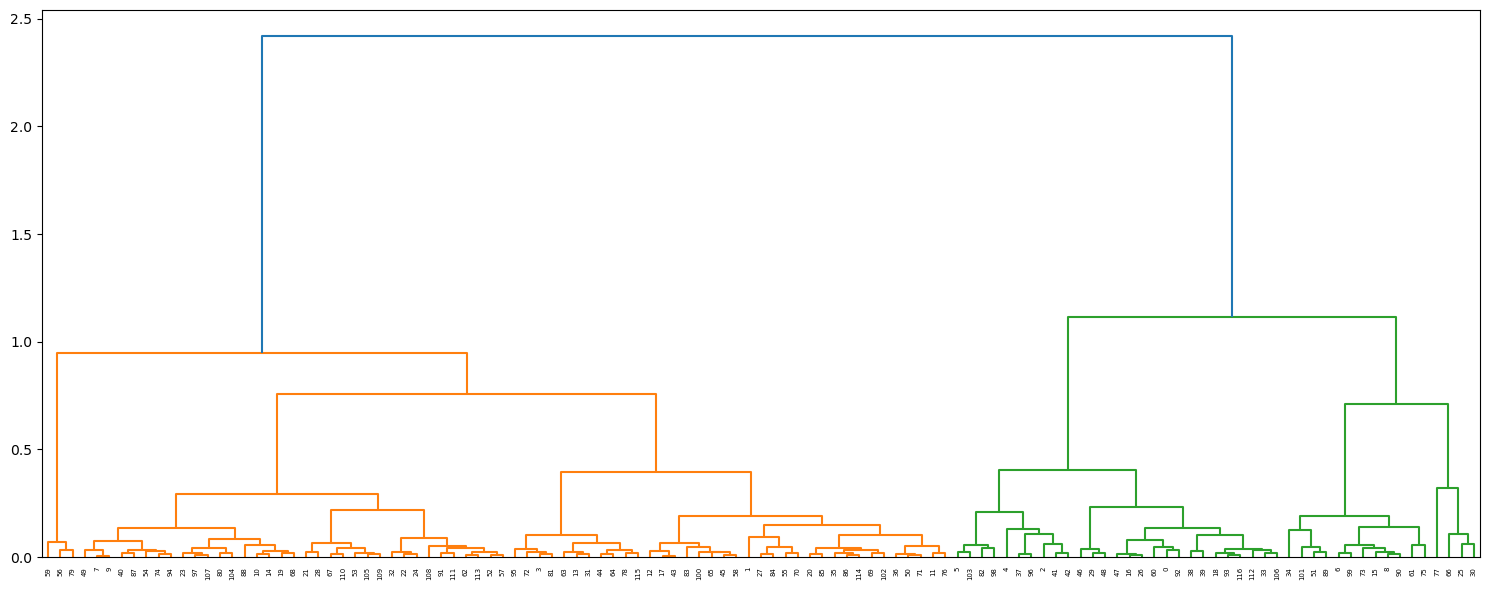

In [ ]:
# Obliczenie macierzy odległości za pomocą hierarchicznego łączenia (linkage) dla danych df_k2[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']]
# Metoda łączenia: ward, metryka: euklidesowa
distance_matrix = linkage(df_k2[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']], method='ward', metric='euclidean')

# Utworzenie figury i osi dla wykresu dendrogramu
fig, ax = plt.subplots(figsize=(15, 6))

# Wygenerowanie dendrogramu na podstawie macierzy odległości i przypisanie go do zmiennej dn
dn = dendrogram(distance_matrix, ax=ax)

# Dopasowanie i ułożenie wykresu dendrogramu w ramach wyświetlanego obszaru
plt.tight_layout()

# Wyświetlenie wykresu dendrogramu
plt.show()


In [ ]:
# Liczba klastrów
num_clusters = 3

# Inicjalizacja modelu grupowania aglomeracyjnego (Agglomerative Clustering) z określoną liczbą klastrów
clustering_model = AgglomerativeClustering(n_clusters=num_clusters)

# Dopasowanie modelu do danych df_k2[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']]
clustering_model.fit(df_k2[['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO']])

# Przypisanie etykiet klastrów do danych w ramce df_k2
df_k2['CLUSTER'] = clustering_model.labels_

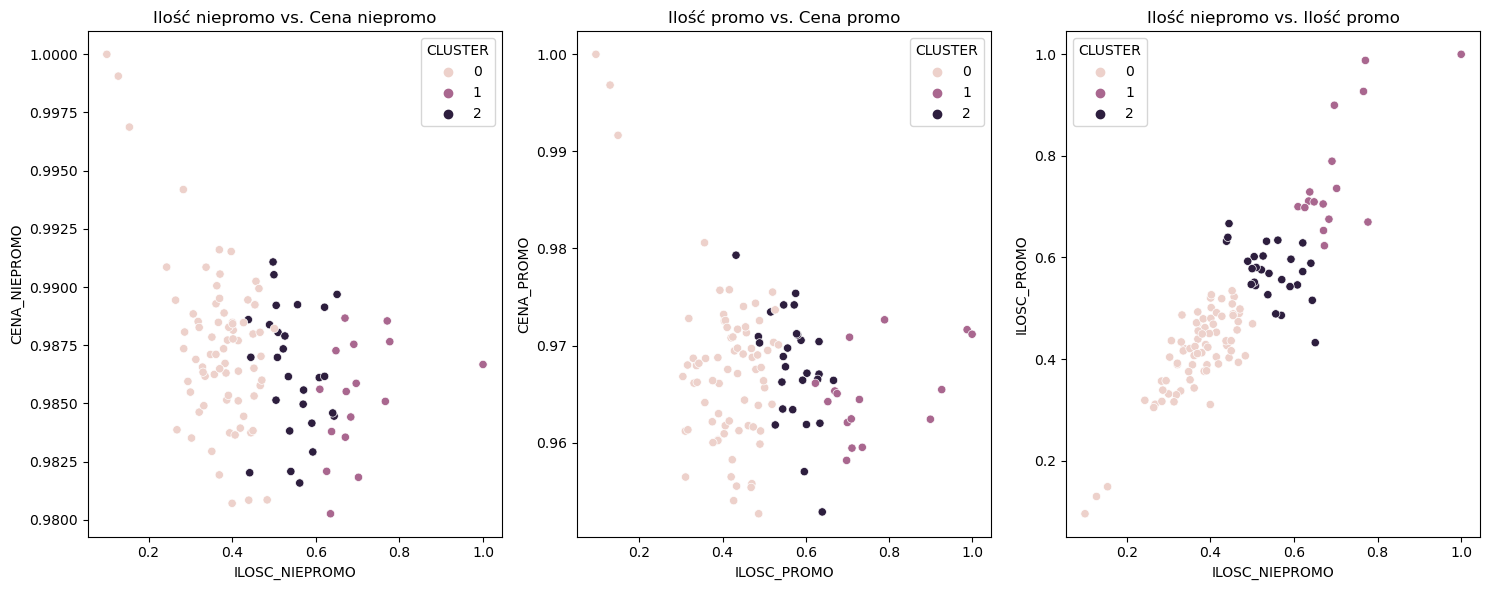

In [ ]:
# Utworzenie figur i osi dla trzech scatterplotów
_, axes = plt.subplots(1, 3, figsize=(15, 6))

# Scatterplot 1: Ilość niepromo vs. Cena niepromo
sns.scatterplot(x='ILOSC_NIEPROMO', y='CENA_NIEPROMO', hue='CLUSTER', data=df_k2, ax=axes[0])
axes[0].set_title('Ilość niepromo vs. Cena niepromo')

# Scatterplot 2: Ilość promo vs. Cena promo
sns.scatterplot(x='ILOSC_PROMO', y='CENA_PROMO', hue='CLUSTER', data=df_k2, ax=axes[1])
axes[1].set_title('Ilość promo vs. Cena promo')

# Scatterplot 3: Ilość niepromo vs. Ilość promo
sns.scatterplot(x='ILOSC_NIEPROMO', y='ILOSC_PROMO', hue='CLUSTER', data=df_k2, ax=axes[2])
axes[2].set_title('Ilość niepromo vs. Ilość promo')

# Dopasowanie i ułożenie wykresów w ramach wyświetlanego obszaru
plt.tight_layout()

# Wyświetlenie wykresów
plt.show()


In [ ]:
# Usunięcie niepotrzebnych kolumn
df_k2.drop(['ILOSC_NIEPROMO', 'ILOSC_PROMO', 'CENA_NIEPROMO', 'CENA_PROMO'], axis=1, inplace=True)

In [ ]:
# Łączenie tabel
df = df.merge(df_k2, on='MARKET_ID', how='left')

In [ ]:
df.head(3)

DATA MARKET_ID GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-03         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-04         2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   

   CENA_AP  PRZECENA  CENA_MARKET  OBROT PROMO_KOD Nr_dn_tyg Nr_dn_mies  \
0     3.49       0.0         3.49    0.0         0         1          2   
1     3.49       0.0         3.49    0.0         0         2          3   
2     3.49       0.0         3.49    0.0         0         3          4   

  Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn  \
0       9     36   2019           1       0             0            0   
1       9     36   2019           1       0             0            0   
2       9     36   2019           1       0             0            0   

         HICP    y  CLUSTER  
0  105.199997  0.0        2  
1  105.199997  0.0        2  
2  105.199997  0.0        2

In [ ]:
# Grupowanie danych w ramce df według kolumn 'DATA', 'ART_ID' i 'CLUSTER' oraz agregacja sumy 'OBROT' i 'y'
df_temp = df.groupby(['DATA', 'ART_ID', 'CLUSTER']).agg({'OBROT': 'sum', 'y': 'sum'}).reset_index()

In [ ]:
# Obliczenie CENY_MARKET
df_temp['CENA_MARKET'] = df_temp['OBROT'] / df_temp['y']
#df.loc[df['CENA_MARKET'] == 0, 'CENA_MARKET'] = np.nan
#df['CENA_MARKET'] = df.groupby(['ART_ID', 'MARKET_ID'])['CENA_MARKET'].fillna(method='ffill').fillna(method='ffill')
#df['CENA_MARKET'] = df.groupby(['ART_ID', 'MARKET_ID'])['CENA_MARKET'].fillna(method='ffill').fillna(method='bfill')

In [ ]:
# Usunięcie niepotrzebnych kolumn
df = df.drop(['MARKET_ID', 'OBROT', 'y', 'CENA_MARKET', 'CLUSTER'], axis=1)
df.drop_duplicates(inplace=True)

In [ ]:
# Łączenie tabel
df = pd.merge(df_temp, df, how='left', on=['DATA', 'ART_ID'])

In [ ]:
# Uzupełnianie i oczyszczenie CENY_MARKET
df['CENA_MARKET'] = df['CENA_MARKET'].fillna(df['CENA_AP'])
df['CENA_MARKET'] = np.where(df['CENA_MARKET'] > df['CENA_AP'], df['CENA_AP'], df['CENA_MARKET'])

In [ ]:
df.isnull().sum()

DATA                  0
ART_ID                0
CLUSTER               0
OBROT                 0
y                     0
CENA_MARKET      245106
GRUPA_ID         245106
NAZWA            245106
CENA_NP          245106
CENA_AP          245106
PRZECENA         245106
PROMO_KOD        245106
Nr_dn_tyg        245106
Nr_dn_mies       245106
Nr_mies          245106
Nr_tyg           245106
Nr_rok           245106
Dn_handlowy      245106
Hot_day          245106
Hot_day_Xmass    245106
Hot_day_Wlkn     245106
HICP             245106
dtype: int64

In [ ]:
# Usunięcie NaN (NaN wynikają z kombinacji artykuł-dzień sprzed okresu wprowadzenia poszczególnych artykułów do asortymentu)
df.dropna(inplace=True)

In [ ]:
df.head()

DATA ART_ID  CLUSTER   OBROT           y  CENA_MARKET GRUPA_ID  \
0 2019-09-02      1        0  190.46   73.000000     2.609041       19   
1 2019-09-02      1        1   53.14   16.000000     3.321250       19   
2 2019-09-02      1        2   68.77   23.000000     2.990000       19   
3 2019-09-02      2        0  624.58  111.639999     5.594590        8   
4 2019-09-02      2        1  473.01   86.529999     5.466428        8   

                          NAZWA  CENA_NP  CENA_AP  PRZECENA PROMO_KOD  \
0  FCHKWROVC QD JROULRGU FDSYVR     3.49     3.49       0.0         0   
1  FCHKWROVC QD JROULRGU FDSYVR     3.49     3.49       0.0         0   
2  FCHKWROVC QD JROULRGU FDSYVR     3.49     3.49       0.0         0   
3                   JHSDL ERSCR     5.99     5.99       0.0         0   
4                   JHSDL ERSCR     5.99     5.99       0.0         0   

  Nr_dn_tyg Nr_dn_mies Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day  \
0         1          2       9     36   2019           1       0   
1         1          2       9     36   2019           1       0   
2         1          2       9     36   2019           1       0   
3         1          2       9     36   2019           1       0   
4         1          2       9     36   2019           1       0   

  Hot_day_Xmass Hot_day_Wlkn        HICP  
0             0            0  105.199997  
1             0            0  105.199997  
2             0            0  105.199997  
3             0            0  105.199997  
4             0            0  105.199997

In [ ]:
df.shape

(2041254, 22)

In [ ]:
# Zmiana kolejności kolumn
new_order = ['DATA', 'CLUSTER', 'GRUPA_ID', 'ART_ID', 'NAZWA', 'CENA_NP', 'CENA_AP', 'PRZECENA', 'CENA_MARKET', 'PROMO_KOD', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok', 'Dn_handlowy', 'Hot_day', 'Hot_day_Xmass', 'Hot_day_Wlkn', 'HICP', 'y'] 
df = df.reindex(columns=new_order)

In [ ]:
# Checkpoint
df.to_pickle('PICKLE/df_3.pkl') 

## EDA

### Import

In [ ]:
# Checkpoint
df = pd.read_pickle('PICKLE/df_3.pkl')

In [ ]:
# Dodatkowa kolumna na potrzeby analiz
df['TYDZIEN'] = df['DATA'].dt.to_period('W').dt.to_timestamp()

In [ ]:
df.head(5)

DATA  CLUSTER GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02        0       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-02        1       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-02        2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
3 2019-09-02        0        8      2                   JHSDL ERSCR     5.99   
4 2019-09-02        1        8      2                   JHSDL ERSCR     5.99   

   CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD Nr_dn_tyg Nr_dn_mies Nr_mies  \
0     3.49       0.0     2.609041         0         1          2       9   
1     3.49       0.0     3.321250         0         1          2       9   
2     3.49       0.0     2.990000         0         1          2       9   
3     5.99       0.0     5.594590         0         1          2       9   
4     5.99       0.0     5.466428         0         1          2       9   

  Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn        HICP  \
0     36   2019           1       0             0            0  105.199997   
1     36   2019           1       0             0            0  105.199997   
2     36   2019           1       0             0            0  105.199997   
3     36   2019           1       0             0            0  105.199997   
4     36   2019           1       0             0            0  105.199997   

            y    TYDZIEN  
0   73.000000 2019-09-02  
1   16.000000 2019-09-02  
2   23.000000 2019-09-02  
3  111.639999 2019-09-02  
4   86.529999 2019-09-02

### Opis danych

DataFrame prezentuje dane dotyczące sprzedaży różnych artykułów spożywczych w określonym dniu na przestrzeni 3 lat. Kolumny zawierają następujące informacje:

**ART_ID**: data sprzedaży (np. 2019-09-02),  
**CLUSTER**: unikalne ID klastra który reprezentuje grupę marketów o podobnej charakterystyce sprzedaży (np. 1, 2),  
**GRUPA_ID**: określa przynależność produktu do danej kategorii (np. 2, 19),  
**NAZWA**: zakodowana nazwa artykułu (np. 'FCHKWROVC QD JROULRGU FDSYVR'),  
**CENA_NP**: cena produktu w sieci handlowej (np. 3.3250, 5.7442),  
**CENA_AP**: cena produktów w okresie promocji (np. 2.9900, 4.4900),  
**PRZECENA**: procent obnizki w okresie promocyjnym względem ceny sprzed promocji (np. 0.3333 = 33.3%),  
**CENA_MARKET**: cena produktu w markecie, uwzględnia ewentualne obniżki marketowe lub odpisy(np. 3.026236, 5.573676),
**PROMO_KOD**: kod promocji dla produktu (np. 0, 13.0),  
**Nr_dn_tyg**: numer dnia tygodnia (np. 1, 2),  
**Nr_dn_mies**: numer dnia miesiąca (np. 2, 9),  
**Nr_mies**: numer miesiąca (np. 9),  
**Nr_tyg**: numer tygodnia (np. 36),  
**Nr_rok**: numer roku (np. 2019),  
**Dn_handlowy**: dzień handlowy (np. 1, 0),  
**Hot_day**: gorący dzień (np. 0, 1),  
**Hot_day_Xmass**: gorący dzień przed Bożym Narodzeniem (np. 0, 1),  
**Hot_day_Wlkn**: gorący dzień przed Wielkanocą (np. 0, 1),  
**HICP**: wskaźnik cen towarów i usług konsumpcyjnych (np. 105.2),  
**y**: ilość sprzedanych sztuk danego artykułu (np. 0, 2).

### Analiza sprzedaży i sezonowości

In [ ]:
df.head()

DATA  CLUSTER GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02        0       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-02        1       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-02        2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
3 2019-09-02        0        8      2                   JHSDL ERSCR     5.99   
4 2019-09-02        1        8      2                   JHSDL ERSCR     5.99   

   CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD Nr_dn_tyg Nr_dn_mies Nr_mies  \
0     3.49       0.0     2.609041         0         1          2       9   
1     3.49       0.0     3.321250         0         1          2       9   
2     3.49       0.0     2.990000         0         1          2       9   
3     5.99       0.0     5.594590         0         1          2       9   
4     5.99       0.0     5.466428         0         1          2       9   

  Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn        HICP  \
0     36   2019           1       0             0            0  105.199997   
1     36   2019           1       0             0            0  105.199997   
2     36   2019           1       0             0            0  105.199997   
3     36   2019           1       0             0            0  105.199997   
4     36   2019           1       0             0            0  105.199997   

            y    TYDZIEN  
0   73.000000 2019-09-02  
1   16.000000 2019-09-02  
2   23.000000 2019-09-02  
3  111.639999 2019-09-02  
4   86.529999 2019-09-02

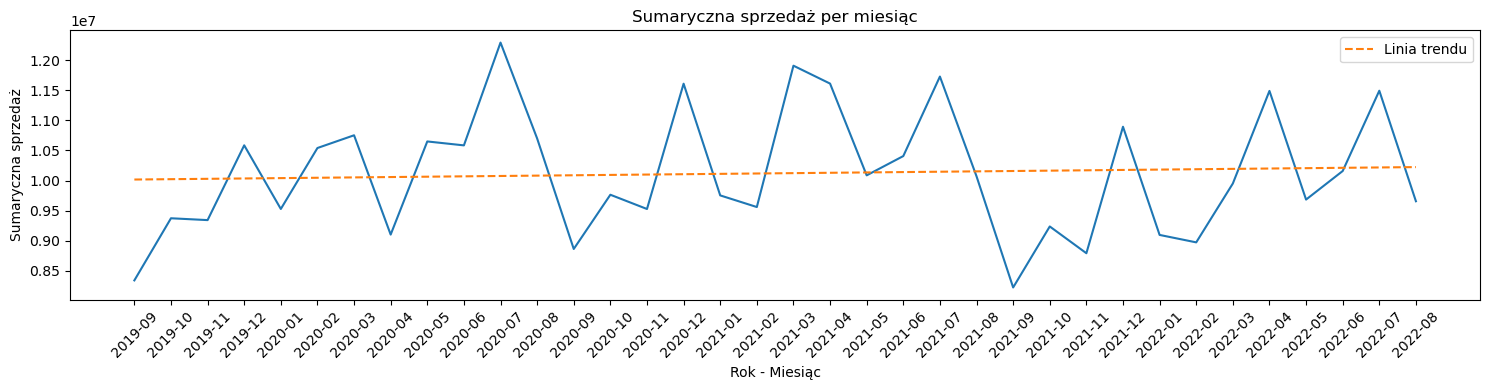

In [ ]:
# Agregacja danych
df['Rok-Miesiąc'] = df['DATA'].apply(lambda x: x.strftime('%Y-%m'))
monthly_sales = df.groupby('Rok-Miesiąc')['y'].sum().reset_index()

# Tworzenei wykresu liniowego
plt.figure(figsize=(15, 4))
sns.lineplot(data=monthly_sales, x='Rok-Miesiąc', y='y')

# Obliczenie linii trendu
x = np.arange(len(monthly_sales['Rok-Miesiąc']))
y = monthly_sales['y']
z = np.polyfit(x, y, 1)
p = np.poly1d(z)

# Dodanie linii trendu do wykresu
plt.plot(monthly_sales['Rok-Miesiąc'], p(x), linestyle='--', label='Linia trendu')
plt.title('Sumaryczna sprzedaż per miesiąc')
plt.xlabel('Rok - Miesiąc')
plt.ylabel('Sumaryczna sprzedaż')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

**Obserwacja**: Na wykresie widać, że istnieje nieznaczny trend wzrostowy dla sumarycznej sprzedaży.

In [ ]:
df.head(3)

DATA  CLUSTER GRUPA_ID ART_ID                         NAZWA  CENA_NP  \
0 2019-09-02        0       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
1 2019-09-02        1       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   
2 2019-09-02        2       19      1  FCHKWROVC QD JROULRGU FDSYVR     3.49   

   CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD Nr_dn_tyg Nr_dn_mies Nr_mies  \
0     3.49       0.0     2.609041         0         1          2       9   
1     3.49       0.0     3.321250         0         1          2       9   
2     3.49       0.0     2.990000         0         1          2       9   

  Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass Hot_day_Wlkn        HICP  \
0     36   2019           1       0             0            0  105.199997   
1     36   2019           1       0             0            0  105.199997   
2     36   2019           1       0             0            0  105.199997   

      y    TYDZIEN Rok-Miesiąc  
0  73.0 2019-09-02     2019-09  
1  16.0 2019-09-02     2019-09  
2  23.0 2019-09-02     2019-09

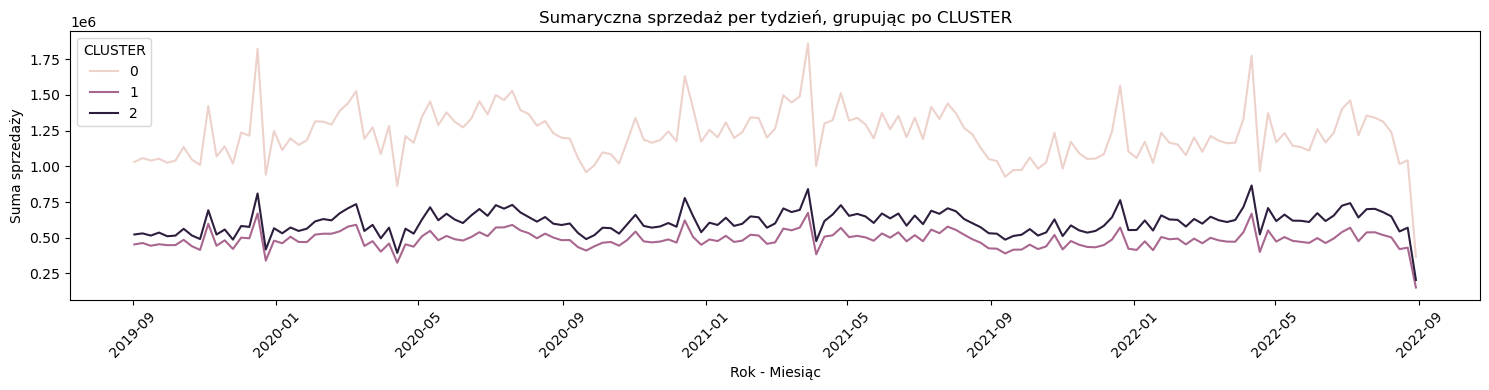

In [ ]:
# Grupowanie danych i obliczenie sumy sprzedaży dla każdej CLUSTER na tydzień
df_grouped = df.groupby(['TYDZIEN', 'CLUSTER']).agg({'y': 'sum'}).reset_index()

# Wykres liniowy sprzedaży w agregacji per cluster / grupę makretów
plt.figure(figsize=(15, 4))
sns.lineplot(data=df_grouped, x='TYDZIEN', y='y', hue='CLUSTER')
plt.title('Sumaryczna sprzedaż per tydzień, grupując po CLUSTER')
plt.xlabel('Rok - Miesiąc')
plt.ylabel('Suma sprzedaży')
plt.legend(title='CLUSTER', loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Obserwacja**: Wykresy liniowe na poszczególnych grup marketów (CLUSTER_LABELS) wykazują bardzo zbliżoną 'charakterystykę' to znaczy przebieg wykresu jest dla wszystkich grup jest bardzo podobny, jedynie wykresy są przesunięte na osi Y. Klaster '1' tworzy część marketów otwartych w 2021 stąd dane zaczynające się od 3 kwartału 2021.

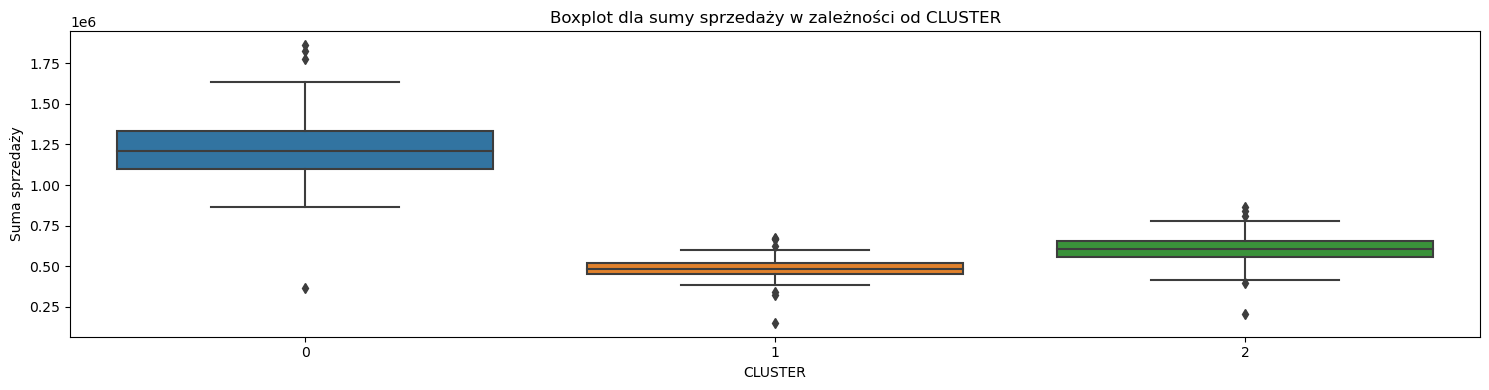

In [ ]:
# Grupowanie danych i obliczenie sumy sprzedaży dla każdej CLUSTER_LABELS na tydzień
df_grouped = df.groupby(['TYDZIEN', 'CLUSTER']).agg({'y': 'sum'}).reset_index()

# Tworzenie wykresu typu boxplot
plt.figure(figsize=(15, 4))
sns.boxplot(data=df_grouped, x='CLUSTER', y='y')
plt.title('Boxplot dla sumy sprzedaży w zależności od CLUSTER')
plt.xlabel('CLUSTER')
plt.ylabel('Suma sprzedaży')
plt.tight_layout()
plt.show()

In [ ]:
%%capture
# Grupowanie danych i obliczenie sumy sprzedaży dla każdej GRUPA_ID per tydzień
df_grouped = df.groupby(['TYDZIEN', 'GRUPA_ID']).agg({'y': 'sum'}).reset_index()

# Ograniczenie wykresu do 5 grup z największą sprzedażą
top5_grupa_id = df_grouped.groupby('GRUPA_ID').agg({'y': 'sum'}).nlargest(5, 'y').index
df_top5 = df_grouped[df_grouped['GRUPA_ID'].isin(top5_grupa_id)]
df_top5['GRUPA_ID'] = df_top5['GRUPA_ID'].astype('int32')
df_top5['GRUPA_ID'] = df_top5['GRUPA_ID'].astype('category')

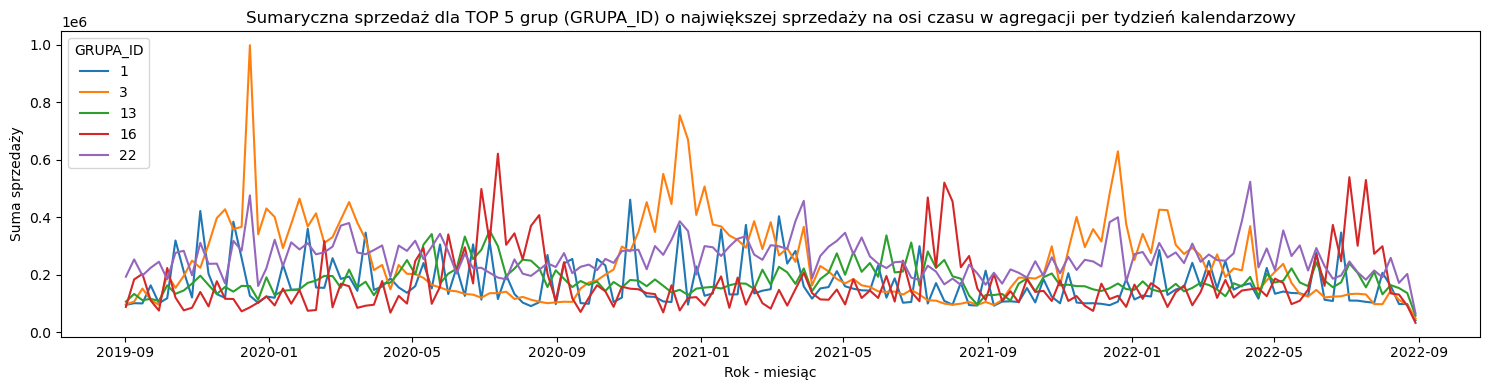

In [ ]:
# Wykres sprzedaży w agregacji grupa artykułów 
plt.figure(figsize=(15, 4))
sns.lineplot(data=df_top5, x='TYDZIEN', y='y', hue='GRUPA_ID', legend='auto')
plt.title('Sumaryczna sprzedaż dla TOP 5 grup (GRUPA_ID) o największej sprzedaży na osi czasu w agregacji per tydzień kalendarzowy')
plt.xlabel('Rok - miesiąc')
plt.ylabel('Suma sprzedaży')
plt.legend([1, 3, 13, 16, 22], title='GRUPA_ID', loc='upper left')
plt.tight_layout()
plt.show()

**Obserwacja**: Na wykresie widać dużą zmienność tydzień do tygodnia oraz peak'i sprzedażowe (na tym etapie ciężko określić co wpływa na tą zmienność. Dla GRUPA_ID o numerze 3 dodatkowo można z wykresu odczytać sezonowość roczną.

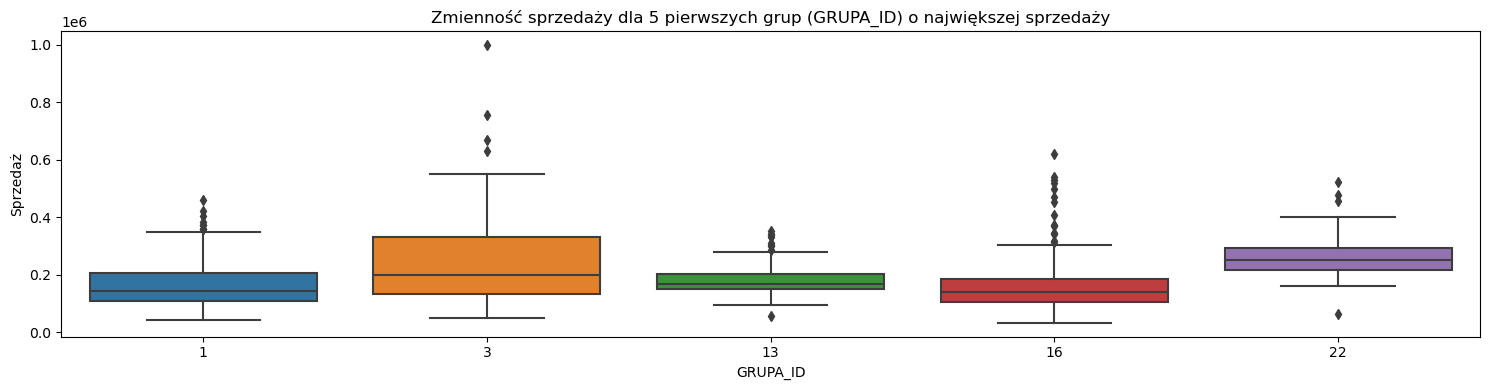

In [ ]:
# Boxplot pokazujący zmienność sprzedaży:
plt.figure(figsize=(15, 4))
sns.boxplot(data=df_top5, x='GRUPA_ID', y='y')
plt.title('Zmienność sprzedaży dla 5 pierwszych grup (GRUPA_ID) o największej sprzedaży')
plt.xlabel('GRUPA_ID')
plt.ylabel('Sprzedaż')
plt.tight_layout()
plt.show()

Ponieważ na wykresie widać sezonowość warto wykonać dekompozycję sezonowości.

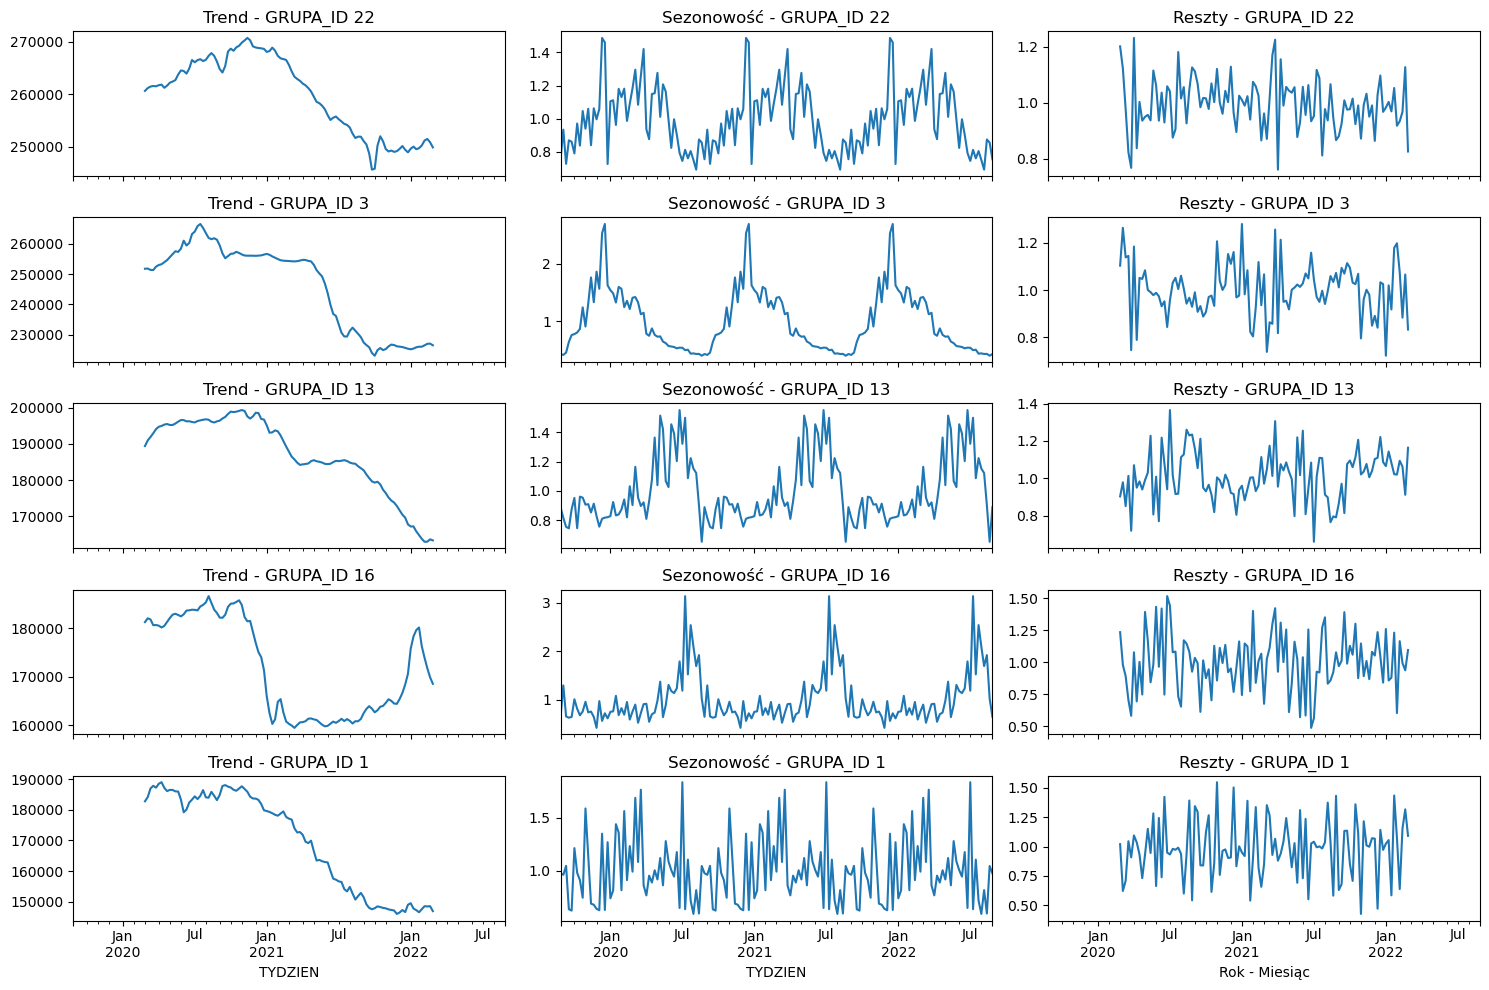

In [ ]:
# Grupowanie danych i obliczenie sumy sprzedaży per tydzień
df_grouped_total = df.groupby(['TYDZIEN']).agg({'y': 'sum'}).reset_index()
df_grouped_total = df_grouped_total.set_index('TYDZIEN')

fig, axes = plt.subplots(len(top5_grupa_id), 3, figsize=(15, 2 * len(top5_grupa_id)), sharex=True)
for i, grupa_id in enumerate(top5_grupa_id):
    df_group = df_top5[df_top5['GRUPA_ID'] == grupa_id].set_index('TYDZIEN')

    # Dekompozycja sezonowości
    result = seasonal_decompose(df_group['y'], model='multiplicative', period=52)  # Ustalamy okres na 52 tygodnie (1 rok)
    
    # Wykres dekompozycji sezonowości dla danej grupy
    result.trend.plot(ax=axes[i, 0], title=f'Trend - GRUPA_ID {grupa_id}')
    result.seasonal.plot(ax=axes[i, 1], title=f'Sezonowość - GRUPA_ID {grupa_id}')
    result.resid.plot(ax=axes[i, 2], title=f'Reszty - GRUPA_ID {grupa_id}')
plt.xlabel('Rok - Miesiąc')
plt.tight_layout()
plt.show()

**Obserwacja**: Na wykresach widać, że różne grupy wykazują różne trendy i różną sezonowość. Obserwacja zgadza się z życiową intuicją tzn. istnieje wiele produktów, których wolumen sprzedaży determinuje popyt (cena za którą konsumenci chcą kupić) oraz podaż (np ze względu na sezonową produkcję artykułów rolnospożywczych).

In [ ]:
# Agregacja danych
df['Rok-Miesiąc'] = df['DATA'].apply(lambda x: x.strftime('%Y-%m'))
top10_articles = df.groupby(['ART_ID', 'GRUPA_ID', 'NAZWA'])['y'].sum().nlargest(10).reset_index()
top10_articles['NAZWA_GRUPA'] = top10_articles['NAZWA'] + ' (Grupa: ' + top10_articles['GRUPA_ID'].astype(str) + ')'
df['NAZWA_GRUPA'] = df['NAZWA'] + ' (Grupa: ' + df['GRUPA_ID'].astype(str) + ')'
top10_articles_df = df[df['ART_ID'].isin(top10_articles['ART_ID'])].groupby(['Rok-Miesiąc', 'ART_ID', 'NAZWA_GRUPA'])['y'].sum().reset_index()

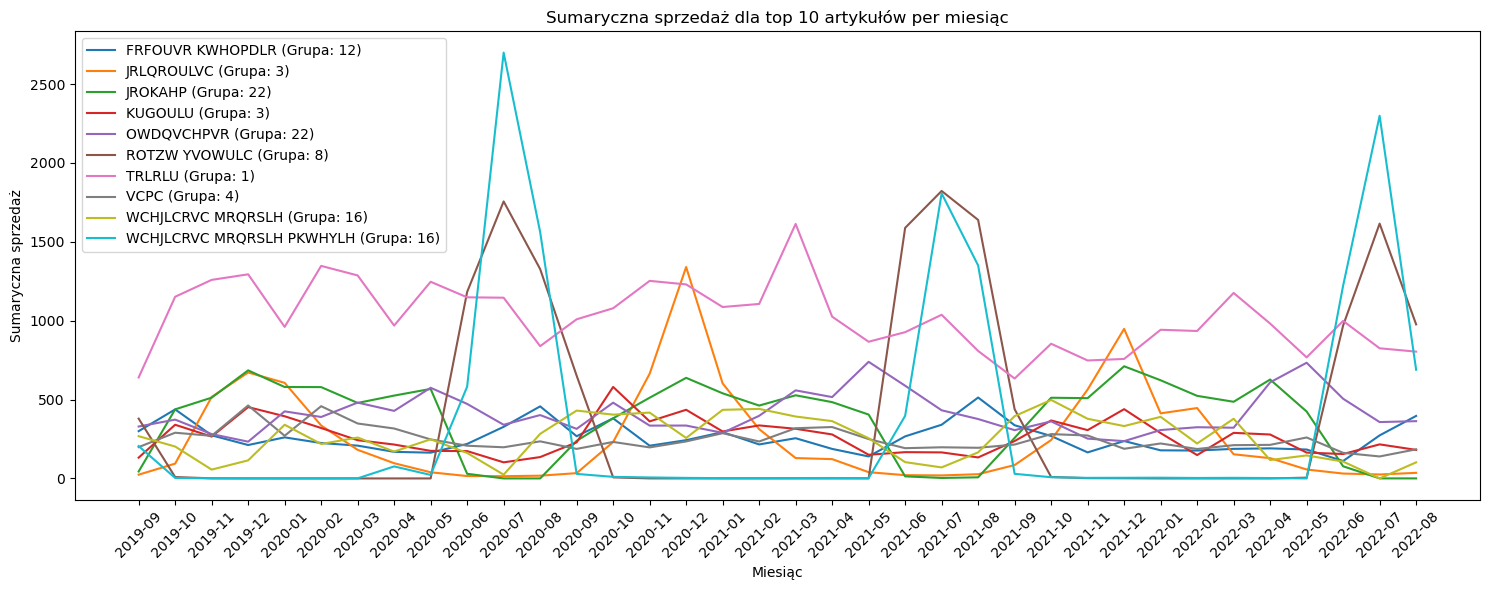

In [ ]:
# Wykres liniowy sprzedaży dla TOP10 artykułów
plt.figure(figsize=(15, 4))
sns.lineplot(data=top10_articles_df, x='Rok-Miesiąc', y='y', hue='NAZWA_GRUPA', legend='auto', ci=None)
plt.title('Sumaryczna sprzedaż dla top 10 artykułów per miesiąc')
plt.xlabel('Miesiąc')
plt.ylabel('Sumaryczna sprzedaż')
plt.xticks(rotation=45)
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

**Obserwacja**: Na wykresie widać, że istnieją 2 artykuły z TOP10, które wykazują bardzo mocną sezonowość roczną w okresie letnim oraz 1 artykuł. z mocną sezonowością zimową - peak'iem sprzedaży w grudniu.

### Analiza wpływu promocji na ceny i sprzedaż

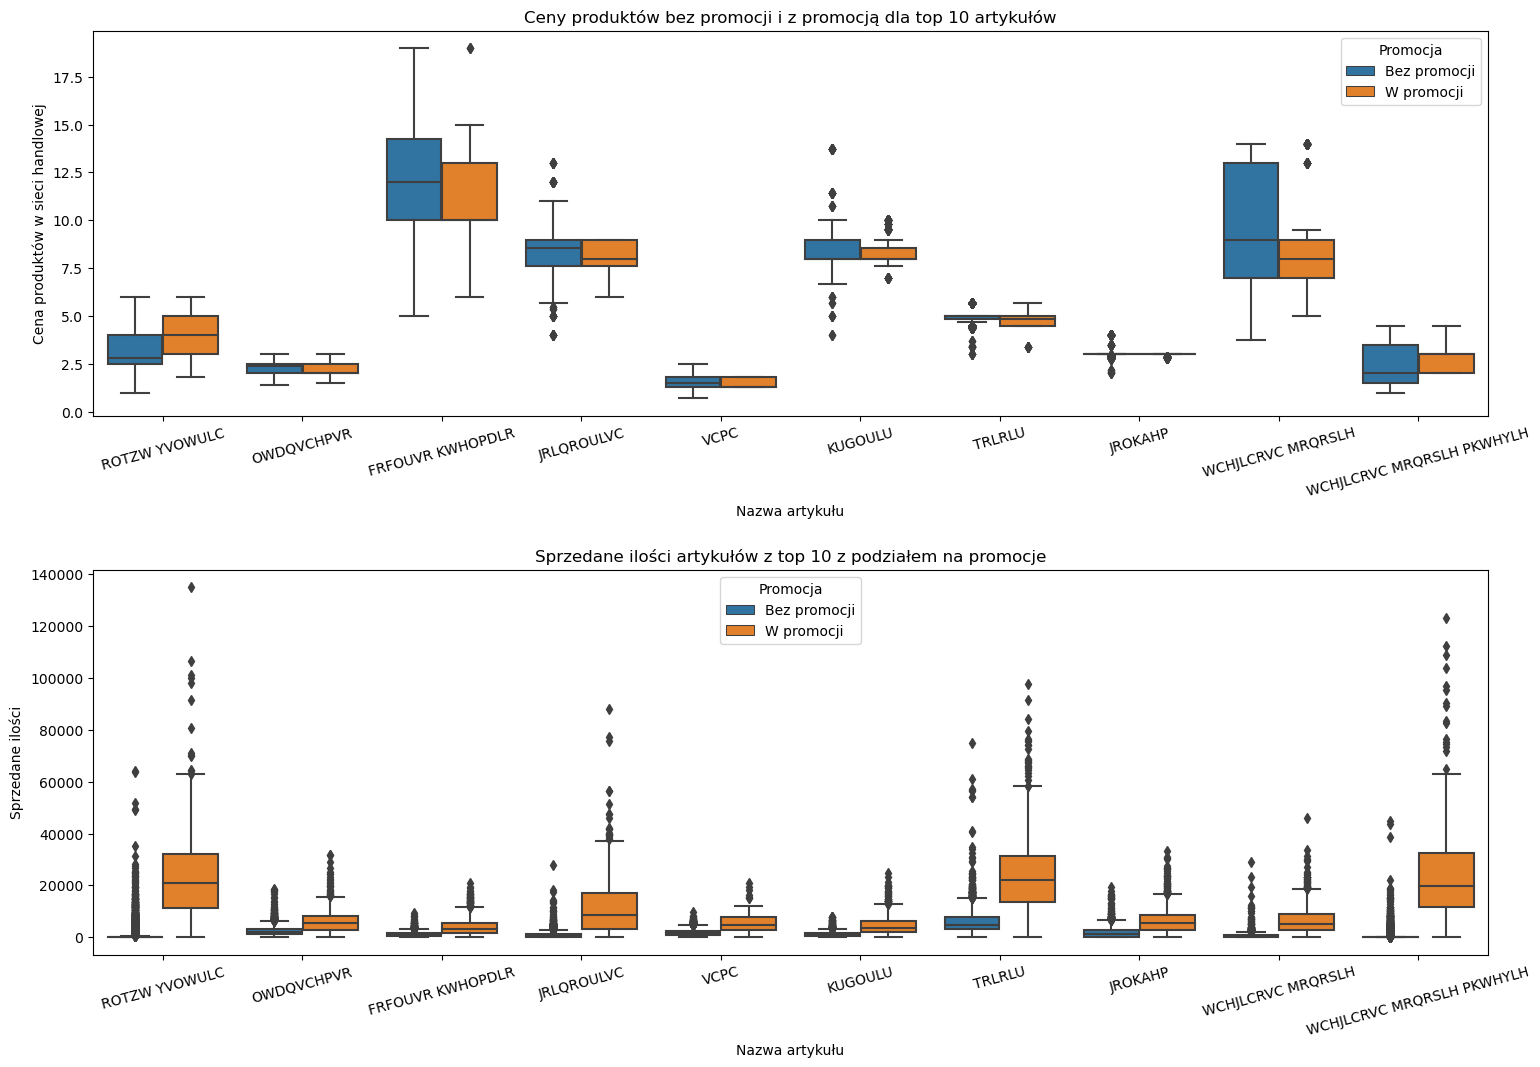

In [ ]:
# TOP10 artykułów z największą sprzedażą
top10_art = df.groupby('ART_ID').agg({'y': 'sum'}).sort_values(by='y', ascending=False).head(10).index

# Dane tylko dla TOP10 artykułów
top10_df = df[df['ART_ID'].isin(top10_art)].copy()
top10_df['ART_ID'] = top10_df['ART_ID'].astype(int)

# Słownik przypisujący ART_ID do NAZWA
art_id_to_name = top10_df[['ART_ID', 'NAZWA']].drop_duplicates().set_index('ART_ID').to_dict()['NAZWA']

# Zamiana ART_ID na NAZWA w TOP10 DataFrame
top10_df['NAZWA'] = top10_df['ART_ID'].apply(lambda x: art_id_to_name[x])

# Dodanie 'Promocja', która zawiera informacje, czy produkt był w promocji
top10_df['Promocja'] = top10_df['PROMO_KOD'].apply(lambda x: 'W promocji' if x != 0 else 'Bez promocji')
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
plt.subplots_adjust(hspace=0.4)

# Boxplot dla cen produktów pogrupowanych per artykuł z podziałem na promocje
sns.boxplot(ax=axes[0], data=top10_df, x='NAZWA', y='CENA_NP', hue='Promocja')
axes[0].set_title('Ceny produktów bez promocji i z promocją dla TOP10 artykułów')
axes[0].set_xlabel('Nazwa artykułu')
axes[0].set_ylabel('Cena produktów w sieci handlowej')
axes[0].tick_params(axis='x', rotation=15)
axes[0].legend(title='Promocja')

# Boxplot dla sprzedanych ilości artykułów z TOP10 z podziałem na promocje
sns.boxplot(ax=axes[1], data=top10_df, x='NAZWA', y='y', hue='Promocja')
axes[1].set_title('Sprzedane ilości artykułów z TOP10 z podziałem na promocje')
axes[1].set_xlabel('Nazwa artykułu')
axes[1].set_ylabel('Sprzedane ilości')
axes[1].tick_params(axis='x', rotation=15)
axes[1].legend(title='Promocja')

plt.show()

**Obserwacja**: Na wykresach widać, że ceny produktów w czasie promocji są niższe co przekłada się na wyższą sprzedaż.

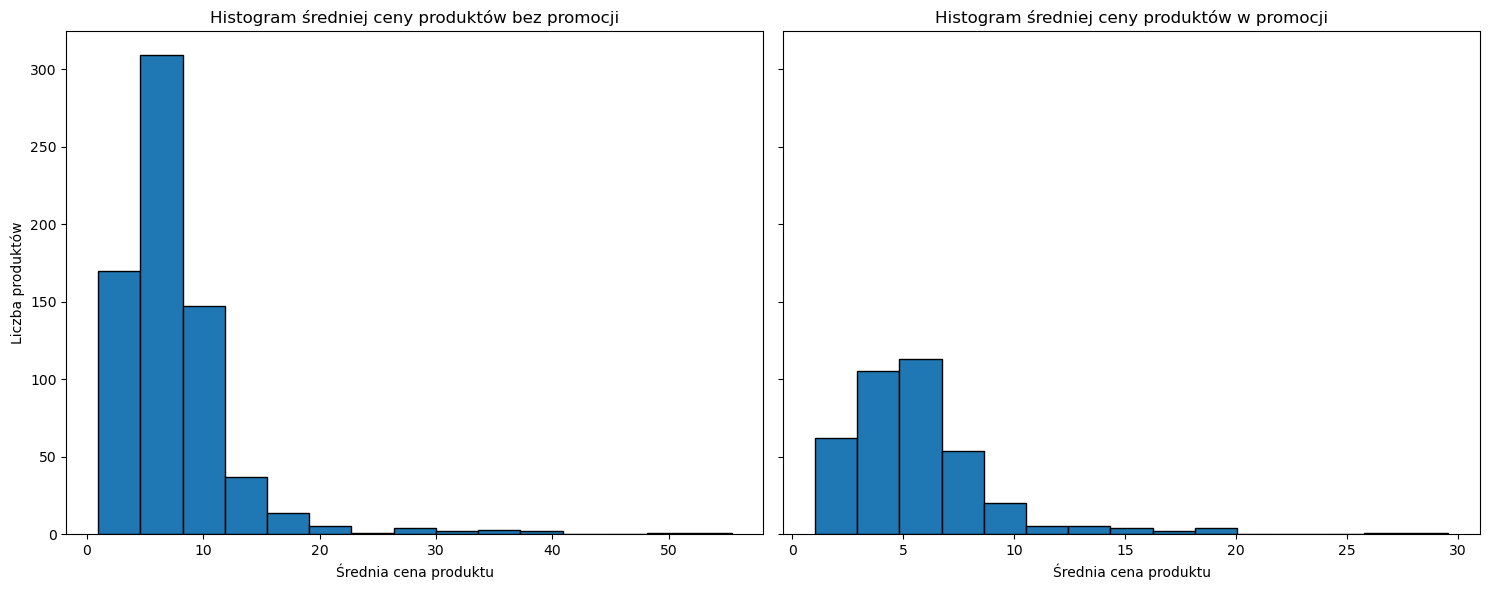

In [ ]:
# Dodanie kolumny 'Promocja', która zawiera informacje, czy produkt był w promocji
df['Promocja'] = df['PROMO_KOD'].apply(lambda x: 'W promocji' if x != 0 else 'Bez promocji')

# Obliczanie średniej ceny dla każdego produktu (ART_ID) z podziałem na promocje
avg_price_per_product_promo = df.groupby(['ART_ID', 'Promocja'])['CENA_AP'].mean().reset_index()

# Tworzenie dwóch histogramów obok siebie
fig, axes = plt.subplots(1, 2, figsize=(15, 4), sharey=True)

# Histogram dla cen bez promocji
axes[0].hist(avg_price_per_product_promo[avg_price_per_product_promo['Promocja'] == 'Bez promocji']['CENA_AP'], bins=15, edgecolor='black')
axes[0].set_title('Histogram średniej ceny produktów bez promocji')
axes[0].set_xlabel('Średnia cena produktu')
axes[0].set_ylabel('Liczba produktów')

# Histogram dla cen w promocji
axes[1].hist(avg_price_per_product_promo[avg_price_per_product_promo['Promocja'] == 'W promocji']['CENA_AP'], bins=15, edgecolor='black')
axes[1].set_title('Histogram średniej ceny produktów w promocji')
axes[1].set_xlabel('Średnia cena produktu')

plt.tight_layout()
plt.show()


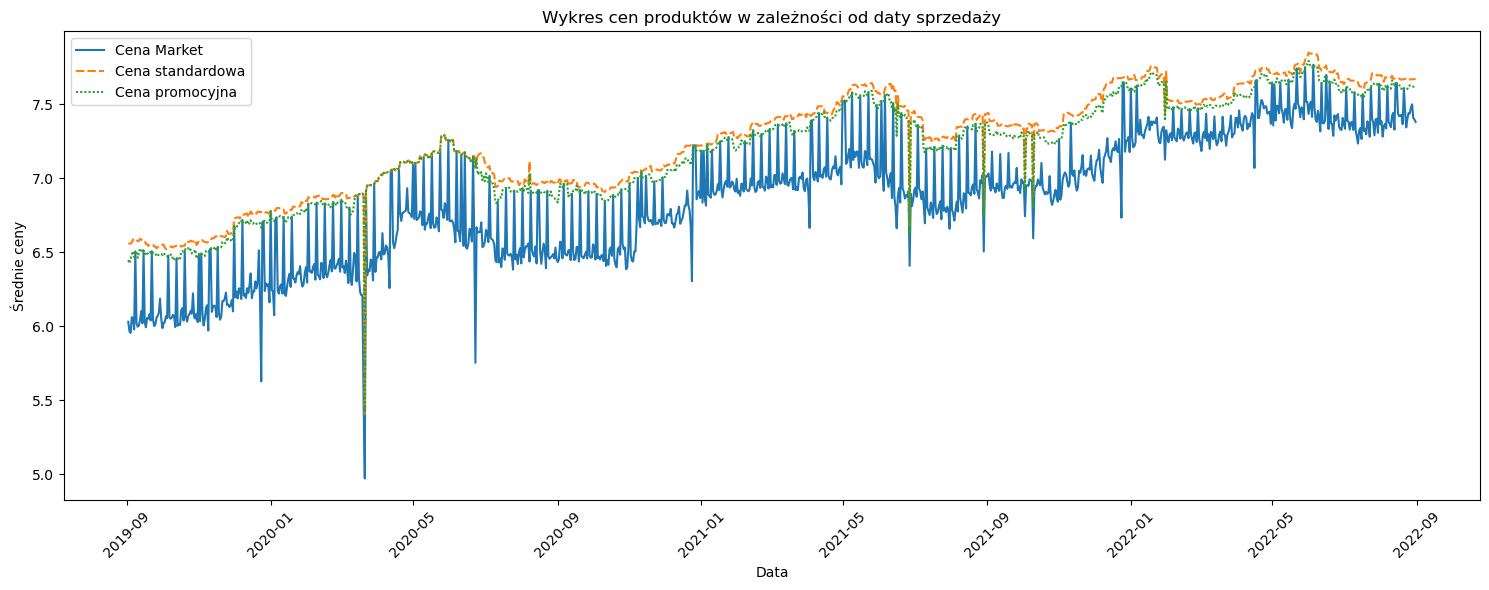

In [ ]:
# Wykres liniowy cen produktów w zależności od daty sprzedaży
plt.figure(figsize=(15, 4))
sns.lineplot(data=df.groupby('DATA').agg({'CENA_MARKET': 'mean', 'CENA_NP': 'mean', 'CENA_AP': 'mean'}))
plt.title('Wykres cen produktów w zależności od daty sprzedaży')
plt.xlabel('Data')
plt.ylabel('Średnie ceny')
plt.legend(['Cena Market', 'Cena standardowa', 'Cena promocyjna'], loc='upper left')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Inne

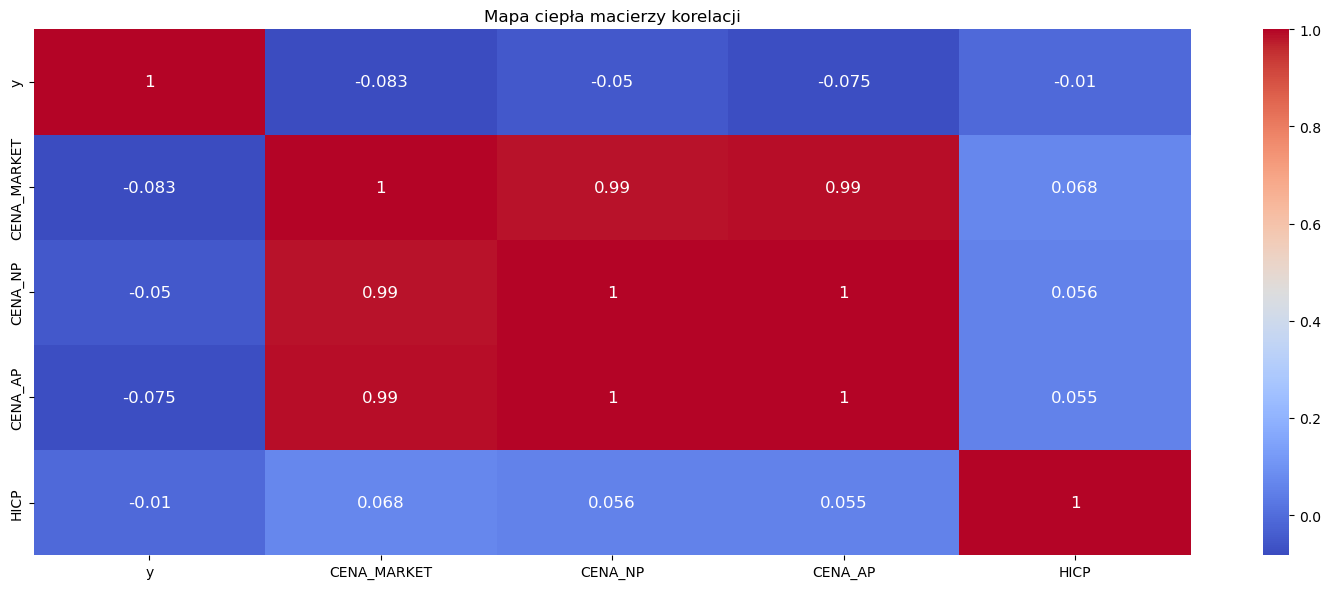

In [ ]:
# Macierz korelacji między kolumnami numerycznymi
num_columns = ['y', 'CENA_MARKET', 'CENA_NP', 'CENA_AP', 'HICP']
correlation_matrix = df[num_columns].corr()

# Mapa ciepła macierzy korelacji
plt.figure(figsize=(15, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 12})
plt.title('Mapa ciepła macierzy korelacji')
plt.tight_layout()
plt.show()

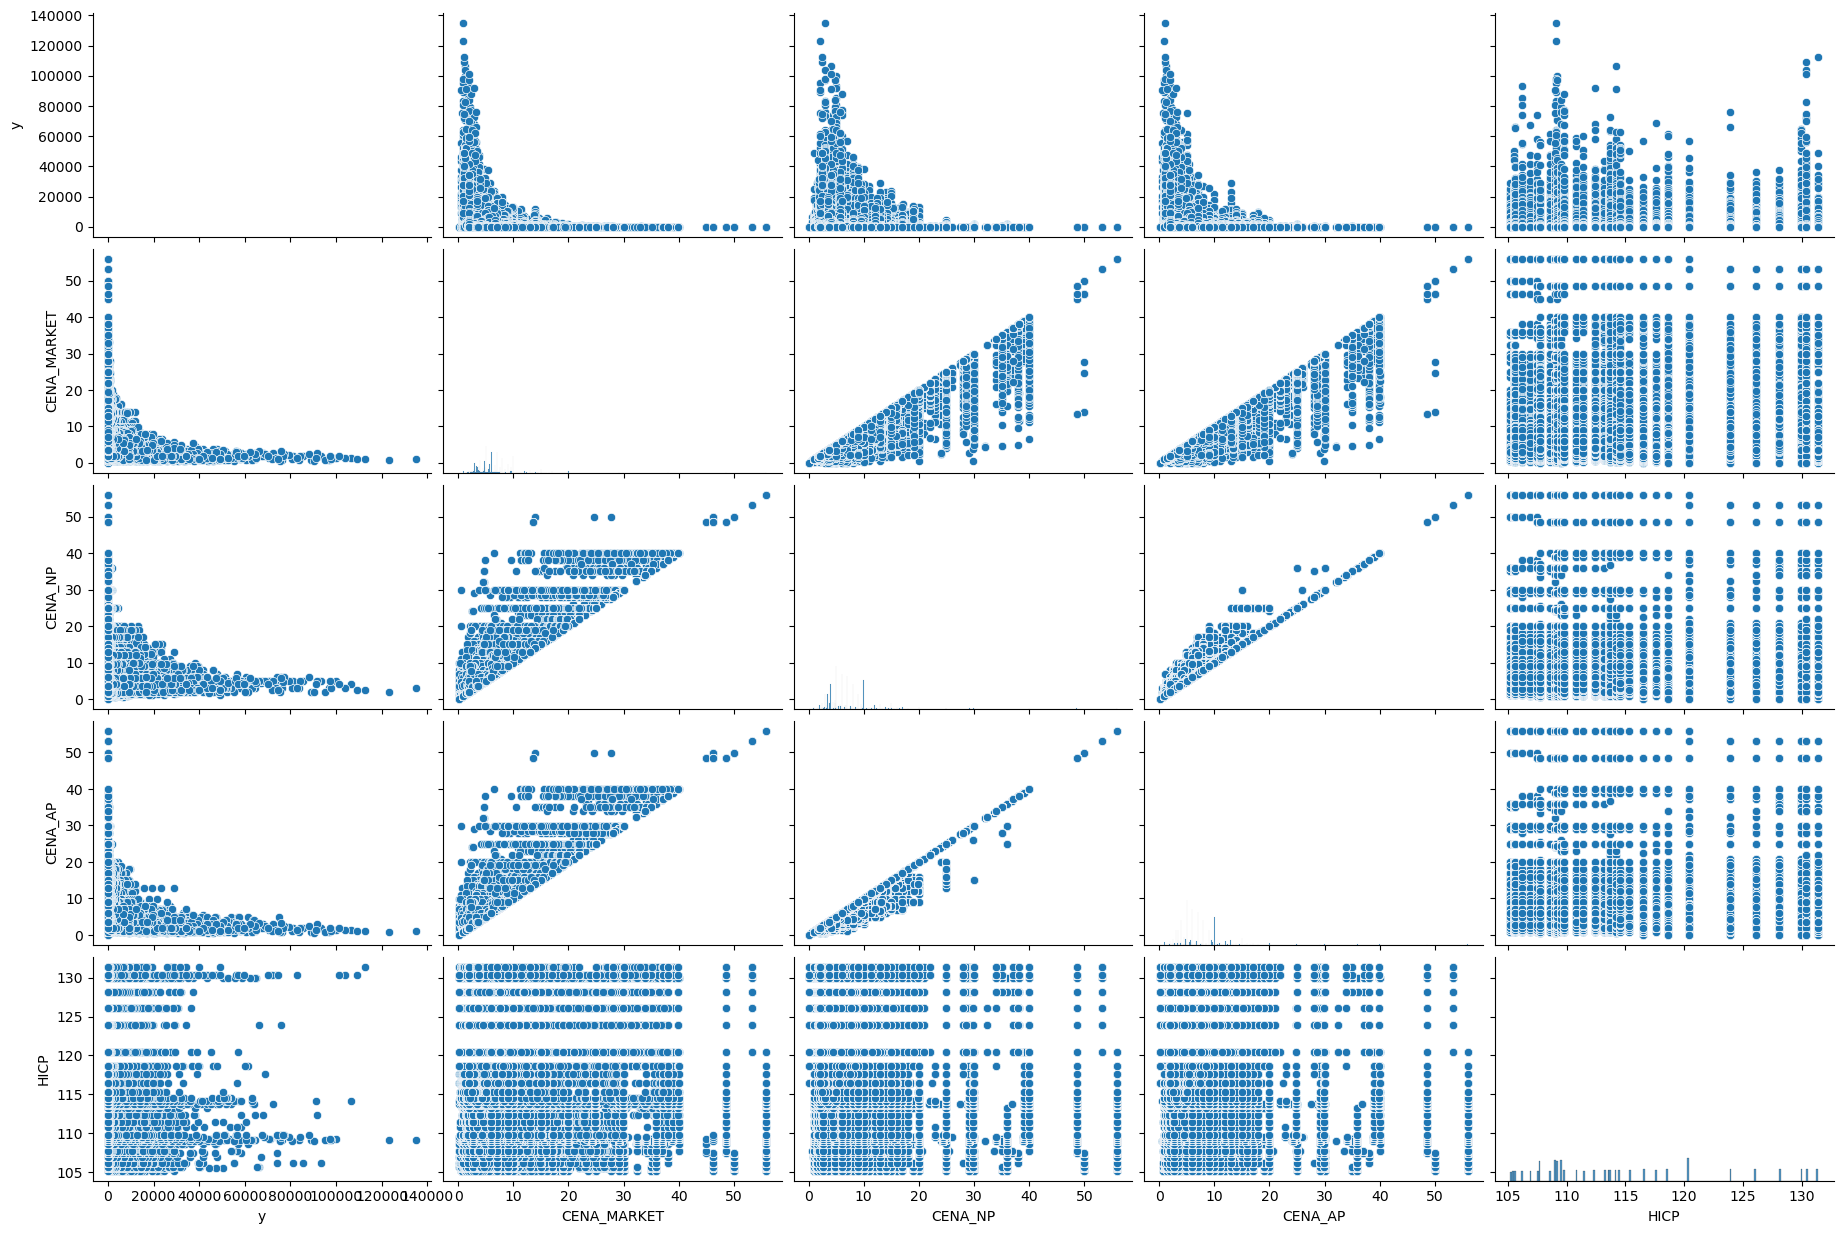

<Figure size 1500x1000 with 0 Axes>

In [ ]:
# Wykresy punktowe dla par zmiennych o wysokim współczynniku korelacji
sns.pairplot(df[['y', 'CENA_MARKET', 'CENA_NP', 'CENA_AP', 'HICP']], aspect = 15/10)
plt.figure(figsize=(15, 8))
plt.tight_layout()

In [ ]:
plt.show()

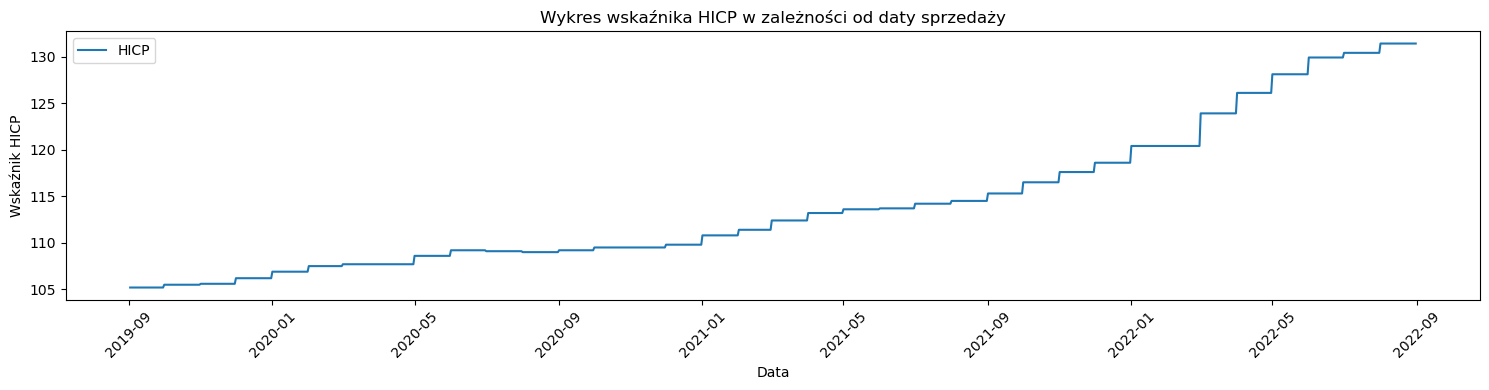

In [ ]:
# Wykres liniowy wskaźnika HICP
plt.figure(figsize=(15, 4))
sns.lineplot(data=df.groupby('DATA').agg({'HICP': 'mean'}))
plt.title('Wykres wskaźnika HICP w zależności od daty sprzedaży')
plt.xlabel('Data')
plt.ylabel('Wskaźnik HICP')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Modelowanie

## Wybór technik modelowania

W niniejszym rozdziale zostaną zastosowane różne modele do predykcji szeregów czasowych w ramach metodologii CRISP-DM. Obejmują one zarówno modele dla szeregów jednowymiarowych, jak i dla szeregów wielowymiarowych. Poniżej przedstawiamy szczegóły dotyczące poszczególnych modeli:

**Dla szeregów jednowymiarowych:**

1. **KNN Regressor** - Model oparty na k najbliższych sąsiadach, który oblicza średnią wartość dla prognozy na podstawie najbliższych obserwacji z przeszłości.
2. **SARIMAX** - Rozszerzony model ARIMA uwzględniający sezonowość i zmienne egzogeniczne, szczególnie przydatny dla szeregów czasowych z sezonowymi wzorcami.
3. **Prophet** - Model opracowany przez Facebook Research, który uwzględnia sezonowość, trendy oraz efekty świąt i wydarzeń specjalnych.
4. **XGBoost Boosting** to algorytm oparty na drzewach decyzyjnych, który optymalizuje gradient w celu uzyskania lepszych predykcji. Jest to zaawansowana technika ensemble, która łączy wiele drzew decyzyjnych, co przyczynia się do poprawy jakości prognoz.
5. **Prophet + XGBoost** - Kombinacja modelu Prophet i XGBoost, która pozwala na wykorzystanie zalet obu podejść w celu uzyskania lepszych wyników.
6. **Sieć Neuronowa Dense 'Vanilla'** - Prosty model sieci neuronowej, skupiający się na podstawowych warstwach sieci i aktywacji.
7. **Rozbudowana Sieć Neuronowa Dense** - Model sieci neuronowej z większą liczbą warstw gęstych, umożliwiający uczenie się bardziej złożonych reprezentacji danych.
8. R**ekurencyjna Sieć Neuronowa LSTM** - Specjalna rodzaj rekurencyjnej sieci neuronowej, dobrze przystosowana do modelowania danych szeregów czasowych, uwzględniająca długotrwałe zależności czasowe.

**Dla szeregów wielowymiarowych:**

1. **XGBoost** - Algorytm XGBoost dostosowany do pracy z szeregami czasowymi wielowymiarowymi.
2. R**ozbudowana Sieć Dense** - Sieć neuronowa z większą liczbą warstw gęstych, skupiająca się na modelowaniu zależności między cechami.
3. **Rozbudowana Sieć Dense z warstwą Embedding** - Sieć neuronowa z dodatkową warstwą embedding, umożliwiającą bardziej efektywne modelowanie danych wielowymiarowych.

W procesie wyboru najlepszego modelu dla predykcji szeregów czasowych, każdy z powyższych modeli zostanie przetestowany, a ich wyniki zostaną porównane. W kolejnych etapach procesu CRISP-DM zostaną przedstawione kroki związane z przygotowaniem danych, trenowaniem modeli oraz ewaluacją ich wydajności. Celem jest znalezienie najbardziej efektywnego podejścia do rozwiązania problemu predykcji szeregów czasowych w ramach metodologii CRISP-DM.

## Budowa modeli oraz testów dla jednowymiarowych szeregów czasowych

#### Import i preprocesing danych

In [4]:
# Wczytanie danych
df = pd.read_pickle('/content/drive/MyDrive/DS Projekt/PICKLE/df_3.pkl')
#df = pd.read_pickle('PICKLE/df_3.pkl')

In [5]:
# Ograniczenie danych do jednego klastra oraz wybranie jednego arrtykułu
df = df.loc[df['CLUSTER']==2].drop(['CLUSTER'], axis=1)
df = df.loc[df['ART_ID']==158].drop(['ART_ID', 'GRUPA_ID', 'NAZWA'], axis=1) 

In [6]:
df.shape

(1095, 17)

In [7]:
# Ustawienie DATA jako index
df.set_index('DATA', inplace=True)

In [8]:
# Podział danych na sprzedaż promocyjną i niepromocyjną
df_promo = df.loc[df['PROMO_KOD']!=0]
df_nonpromo = df.loc[df['PROMO_KOD']==0]

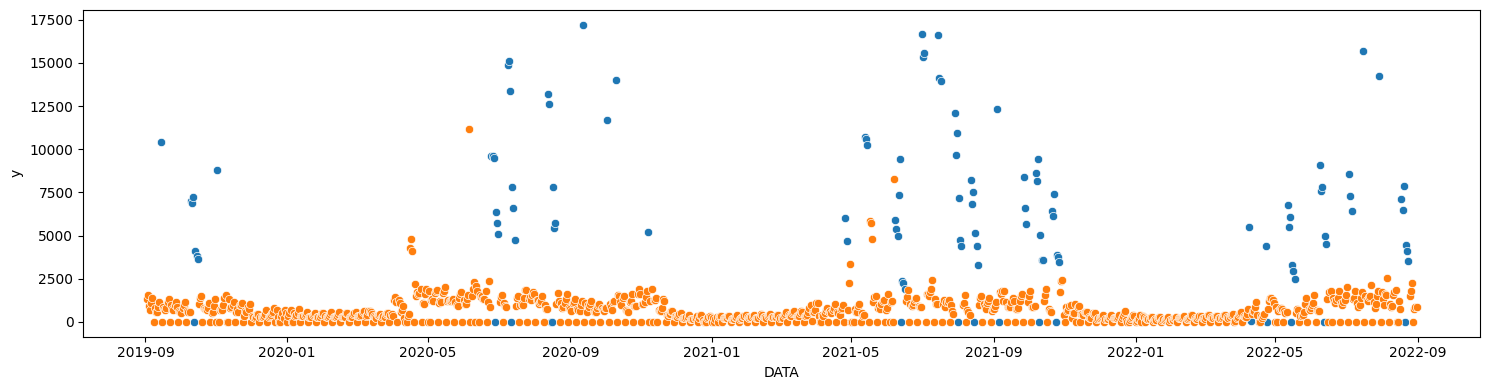

In [9]:
# Scatter plot sprzedaży
plt.figure(figsize=(15, 4))
sns.scatterplot(data=df_promo, x=df_promo.index, y='y')
sns.scatterplot(data=df_nonpromo, x=df_nonpromo.index, y='y')
plt.tight_layout()
plt.show()

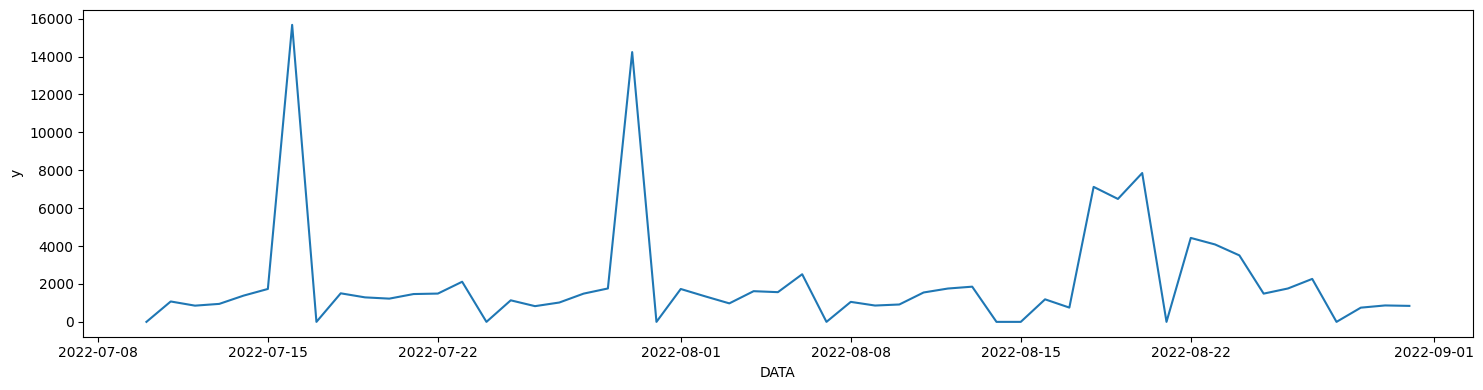

In [10]:
# Lineplot sprzedaży za okres 'testowy'
plt.figure(figsize=(15, 4))
sns.lineplot(data=df.loc[df.index>='2022-07-10'], x=df.index[df.index>='2022-07-10'], y='y')
plt.tight_layout()
plt.show()

**Obeserwacja**: Wybrany okres zawiera 3 promocje: dwie jednodniowe i jedną promocję tygodniową.

##### Kodowanie danych

In [11]:
# Definicja kolumn względem typu danych
nominal_columns = ['PROMO_KOD', 'Dn_handlowy', 'Hot_day']
ordinal_columns = ['Hot_day_Xmass', 'Hot_day_Wlkn', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok']
numeric_columns = ['CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP']

# Tworzenie przekształceń
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numeric_transformer = MinMaxScaler()

# Tworzenie ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_columns),
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('numeric', numeric_transformer, numeric_columns)
    ])

# Tworzenie pipeline'u
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Przekształcanie danych
X_train, y_train = df.loc[df.index <='2022-07-10 00:00:00'], df.loc[df.index <= '2022-07-10 00:00:00']
X_test, y_test = df.loc[df.index>'2022-07-10 00:00:00'], df.loc[df.index > '2022-07-10 00:00:00']
X_train = X_train.drop(columns=['y'])
X_test = X_test.drop(columns=['y'])
y_train = y_train['y']
y_test = y_test['y']

# Zastosowanie pipeline'ow
X_trans_transformed = pipeline.fit_transform(X_train)
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [12]:
# Przekształcanie kolumny nominalne za pomocą OneHotEncoder i pobranie ich nazwy
nominal_transformed_columns = nominal_transformer.fit(X_train[nominal_columns]).get_feature_names_out(nominal_columns)

# Połączenie nazwy kolumn nominalnych, porządkowych i numerycznych
transformed_columns = np.concatenate((nominal_transformed_columns, ordinal_columns, numeric_columns))

# Tworzenie przekształconych DataFrame z przekształconymi nazwami kolumn
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=transformed_columns)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=transformed_columns)
X_trans_transformed = pd.DataFrame(X_trans_transformed, columns=transformed_columns)


In [13]:
# Wymiary poszczegółnych DataFrame'ów
print(X_train_transformed.shape)
print(y_train.shape)
print(X_test_transformed.shape)
print(y_test.shape)

(1043, 26)
(1043,)
(52, 26)
(52,)


In [14]:
X_train_transformed_df.head(2)

PROMO_KOD_0  PROMO_KOD_3  PROMO_KOD_4  PROMO_KOD_5  PROMO_KOD_8  \
0          1.0          0.0          0.0          0.0          0.0   
1          1.0          0.0          0.0          0.0          0.0   

   PROMO_KOD_20  PROMO_KOD_58  PROMO_KOD_107  PROMO_KOD_115  PROMO_KOD_118  \
0           0.0           0.0            0.0            0.0            0.0   
1           0.0           0.0            0.0            0.0            0.0   

   Dn_handlowy_0  Dn_handlowy_1  Hot_day_0  Hot_day_1  Hot_day_Xmass  \
0            0.0            1.0        1.0        0.0           14.0   
1            0.0            1.0        1.0        0.0           14.0   

   Hot_day_Wlkn  Nr_dn_tyg  Nr_dn_mies  Nr_mies  Nr_tyg  Nr_rok  CENA_MARKET  \
0          14.0        0.0         1.0      8.0    35.0     0.0     0.150303   
1          14.0        1.0         2.0      8.0    35.0     0.0     0.095115   

    CENA_AP   CENA_NP  PRZECENA  HICP  
0  0.161677  0.034483       0.0   0.0  
1  0.161677  0.034483       0.0   0.0

### Model bazowy - KNN

Metoda k-najbliższych sąsiadów (KNN) jest popularną techniką wykorzystywaną do regresji w szeregach czasowych. KNN regresor dla szeregów czasowych polega na przewidywaniu wartości punktu danych na podstawie podobieństwa do jego k najbliższych sąsiadów.

W przypadku szeregów czasowych, dane są uporządkowane w czasie, więc ważne jest uwzględnienie tej struktury podczas prognozowania. KNN regresor dla szeregów czasowych opiera się na idei, że punkty danych, które są blisko siebie w przestrzeni czasowej, mają podobne wartości. Algorytm KNN szuka k najbliższych sąsiadów dla danego punktu danych i oblicza prognozowaną wartość, na przykład poprzez średnią wartości tych sąsiadów.

Aby zastosować KNN regresor dla szeregów czasowych, można użyć metryki podobieństwa, takiej jak odległość Euklidesowa lub korelacja, do obliczenia odległości między punktami danych. Następnie wybierane są k najbliższych sąsiadów i obliczana jest prognoza na podstawie ich wartości. Parametr k określa, ile sąsiadów ma być branych pod uwagę przy prognozowaniu.

In [ ]:
# Parametry
n_neighbors_values = np.arange(1, 25, 1)
weights_values = ['uniform', 'distance']
algorithm_values = ['auto', 'ball_tree', 'kd_tree', 'brute']
leaf_size_values = np.arange(1, 5, 1)
p_values = [1, 2]

# Tworzenie kombinacji parametrów
param_combinations_KNR = list(product(n_neighbors_values, weights_values, algorithm_values, leaf_size_values, p_values))
len(param_combinations_KNR)

1536

In [ ]:
# Inicjalizacja ramki danych do przechowywania wyników metryk dla każdego foldu
results_df_KNR = pd.DataFrame(columns=['Fold', 'n_neighbors', 'weights', 'algorithm', 'leaf_size', 'p', 'MAE', 'RMSE', 'R2', 'WMAPE', 'MASE'])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5) 

In [ ]:
# Inicjalizacja ramki danych do przechowywania najlepszych wyników metryk dla każdego foldu
best_results_df_KNR = pd.DataFrame(columns=['Fold', 'n_neighbors', 'weights', 'algorithm', 'leaf_size', 'p', 'MAE', 'RMSE', 'R2', 'MAPE', 'MASE'])

# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_KNR = X_train_transformed_df.iloc[train_index]
    X_test_KNR = X_train_transformed_df.iloc[test_index]
    y_train_KNR = y_train.iloc[train_index]
    y_test_KNR = y_train.iloc[test_index]

    best_rmse = float('inf')
    best_params = None
    best_mae, best_rmse, best_r2, best_mape, best_mase = float('inf'), float('inf'), float('-inf'), float('inf'), float('inf')


    for params in param_combinations_KNR:
        n_neighbors, weights, algorithm, leaf_size, p = params
        KNR = KNeighborsRegressor(
            n_neighbors=n_neighbors,
            weights=weights,
            algorithm=algorithm,
            leaf_size=leaf_size,
            p=p
        )
        KNR.fit(X_train_KNR, y_train_KNR)
        y_pred_KNR = KNR.predict(X_test_KNR)
        rmse = mean_squared_error(y_test_KNR, y_pred_KNR, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
            best_mae, best_rmse, best_r2, best_wmape, best_mase = ff.metryki(y_test_KNR, y_pred_KNR)

    # Utworzenie najlepszego modelu
    n_neighbors, weights, algorithm, leaf_size, p = best_params
    KNR = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        algorithm=algorithm,
        leaf_size=leaf_size,
        p=p
    )
    KNR.fit(X_train_KNR, y_train_KNR)
    y_pred = KNR.predict(X_test_KNR)

    # Zapisanie najlepszych wyników metryk dla foldu
    best_results_df_KNR = best_results_df_KNR.append({'Fold': fold, 'n_neighbors': n_neighbors, 'weights': weights,
                                    'algorithm': algorithm, 'leaf_size': leaf_size, 'p': p,
                                    'MAE': best_mae, 'RMSE': best_rmse, 'R2': best_r2, 'WMAPE': best_wmape, 'MASE': best_mase}, ignore_index=True)

# Skopiowanie najlepszych wyników metryk do wynikowej ramki danych
results_df_KNR = best_results_df_KNR.copy()

In [ ]:
# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_KNR.head()

Fold n_neighbors   weights algorithm leaf_size  p          MAE         RMSE  \
0    0           1  distance      auto         1  1  1199.202024  2674.990397   
1    1           1   uniform      auto         1  1   403.199371  1238.140747   
2    2          13   uniform      auto         1  1  1292.112305  2738.364258   
3    3          13  distance      auto         1  1   866.763619  1855.168874   
4    4          19  distance      auto         1  1   632.985193  1070.897645   

         R2 MAPE      MASE      WMAPE  
0  0.085450  NaN  0.966899   0.498234  
1  0.606451  NaN  0.468190   2.056895  
2  0.328096  NaN  1.094599   0.603830  
3  0.398234  NaN  0.801210  15.581075  
4  0.609607  NaN  0.878982   3.084313

In [ ]:
# Tworzenie predykcji
y_predict_KNR = KNR.predict(X_test_transformed_df)
y_predict_KNR_past = KNR.predict(X_train_transformed_df)

In [ ]:
# Tworzenie DataFrame do wizualizacji
KNR_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
KNR_pred['y_test'] = KNR_pred['y']
KNR_pred = KNR_pred.drop('y', axis=1)
KNR_pred['y_predict'] = y_predict_KNR

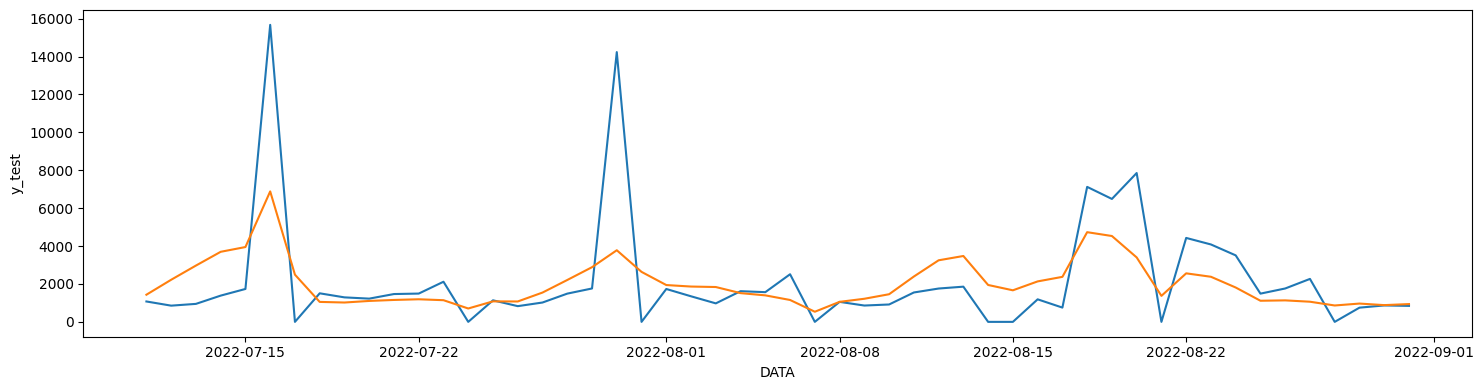

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=KNR_pred, x=KNR_pred.index, y='y_test')
sns.lineplot(data=KNR_pred, x=KNR_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_KNR, rmse_KNR, r2_KNR, wmape_KNR, mase_KNR = ff.metryki(y_test, y_predict_KNR)
print(f'MAE: {mae_KNR:.4f}, RMSE: {rmse_KNR:.4f}, R2: {r2_KNR:.4f}, WMAPE: {wmape_KNR:.4f}, MASE: {mase_KNR:.4f}')

MAE: 1385.8794, RMSE: 2331.3765, R2: 0.4135, WMAPE: 0.5490, MASE: 0.6765


In [15]:
# Komórka techniczna, do usunięcia przed publikacją
mae_KNR = 1385.8794
rmse_KNR = 2331.3765
r2_KNR = 0.4135
wmape_KNR = 0.5490
mase_KNR =0.6765

### SARIMAX

Metoda SARIMAX (Seasonal Autoregressive Integrated Moving Average with Exogenous Variables) jest zaawansowaną techniką modelowania i prognozowania szeregów czasowych. Jest rozszerzeniem klasycznego modelu ARIMA (Autoregressive Integrated Moving Average) o uwzględnienie składowej sezonowej oraz możliwość uwzględnienia zmiennych egzogenicznych.
  
    

---

  
Model SARIMAX składa się z czterech głównych komponentów:

  Autoregresja (AR): Komponent AR odnosi się do zależności między wartościami szeregu czasowego w przeszłości, które wpływają na jego wartości w teraźniejszości. AR odzwierciedla autokorelację, czyli zależność między wartościami szeregów czasowych w różnych momentach czasowych.

  Ruchome średnie (MA): Komponent MA odnosi się do zależności między błędami prognozy w przeszłości, które wpływają na błędy prognozy w teraźniejszości. MA odzwierciedla niestabilność lub szum w szeregu czasowym.

  Integracja (I): Komponent I odnosi się do różnicowania szeregu czasowego w celu uczynienia go stacjonarnym. Różnicowanie polega na obliczaniu różnic między wartościami szeregu czasowego w różnych momentach czasowych. Proces różnicowania ma na celu usunięcie trendu i sezonowości z szeregu czasowego.

  Składowa sezonowa (S): Komponent sezonowy odnosi się do powtarzających się wzorców lub sezonowości w szeregu czasowym. Może być konieczne uwzględnienie cykliczności w danych, na przykład w przypadku szeregów czasowych z rocznymi, kwartalnymi lub miesięcznymi sezonowościami.

  Zmienne egzogeniczne (X): Zewnętrzne czynniki wpływające na szereg czasowy, ale nie jest bezpośrednio powiązany z jego poprzednimi wartościami.

#### Badanie stacjonarności danych

Przed użyciem modelu (S)ARIMA(X) konieczne jest zbadanie stacjonarności danych. Aby wykonać ten krok wykorzystamy dwa testy: *Test Dickeya-Fullera powiększonego (ADF)* oraz *KPSS* dla których stawiamy najstępujące hipotezy:

**Test Dickeya-Fullera powiększonego (ADF):**

*Hipoteza zerowa (H0):*  
Dane mają jednostkowy korzenˊ, czyli są niestacjonarne

*Hipoteza alternatywna (H1):*  
Dane nie mają jednostkowego korzenia, czyli są stacjonarne

**Test KPSS:**

*Hipoteza zerowa (H0):*  
Dane są stacjonarne w sensie stacjonarności słabej (stacjonarność w ścisłym tego słowa znaczeniu lub stacjonarność z trendem)

*Hipoteza alternatywna (H1):*   
Dane są niestacjonarne


In [ ]:
# Test Dickeya-Fullera powiększonego (ADF)
result_adf = adfuller(y_train)
print(f'ADF Statistic: {result_adf[0]}')
print(f'p-value: {result_adf[1]}')

ADF Statistic: -3.441555343129383
p-value: 0.00962123801316631


**Obserwacja**: W przypadku testu ADF, wartość p wynosi 0.0096, co jest mniejsze niż poziom istotności 0,05. Oznacza to, że odrzucamy hipotezę zerową o braku stacjonarności i przyjmujemy, że dane są stacjonarne.

In [ ]:
# Test KPSS
result_kpss = kpss(y_train)
print(f'KPSS Statistic: {result_kpss[0]}')
print(f'p-value: {result_kpss[1]}')

KPSS Statistic: 0.23627898343295728
p-value: 0.1


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


**Obserwacja:** W przypadku testu KPSS, wartość p wynosi 0.236, co jest większe niż poziom istotności 0,05. Oznacza to, że nie ma podstaw do odrzucenia hipotezy zerowej, która mówi, że dane są stacjonarne.

Podsumowując, wyniki obu testów sugerują, że dane są stacjonarne. Warto jednak zauważyć, że test KPSS generuje ostrzeżenie o tym, że wartość statystyki testowej znajduje się poza zakresem wartości p dostępnych w tabeli. W takim przypadku wartość p może być niedokładna. Mimo to, wyniki obu testów wskazują na stacjonarność danych.

#### Budowa modelu

In [16]:
# Inicjalizacja ramki danych do przechowywania wyników metryk dla każdego foldu
results_df_SARIMAX = pd.DataFrame(columns=['Fold', 'order', 'seasonal_order', 'AIC', 'BIC', 'MAE', 'RMSE', 'R2', 'WMAPE', 'MASE'])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)


In [17]:
# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_SARIMAX = X_train.iloc[train_index]
    X_test_SARIMAX = X_train.iloc[test_index]
    y_train_SARIMAX = y_train.iloc[train_index]
    y_test_SARIMAX = y_train.iloc[test_index]

    # AutoARIMA - automatyczne dopasowanie modelu SARIMAX
    SARIMAX = auto_arima(X=X_train_SARIMAX, y=y_train_SARIMAX, error_action='ignore')

    # Przewidywanie wartości
    y_pred = SARIMAX.predict(n_periods=len(X_test_SARIMAX), X=X_test_SARIMAX)

    # Obliczanie metryk
    mae, rmse, r2, wmape, mase = ff.metryki(y_test_SARIMAX, y_pred)

    # Zapisanie wyników metryk dla foldu
    results_df_SARIMAX = results_df_SARIMAX.append({'Fold': fold, 'order': SARIMAX.order, 'seasonal_order': SARIMAX.seasonal_order,
                                                    'AIC': SARIMAX.aic(), 'BIC': SARIMAX.bic(),
                                                    'MAE': mae, 'RMSE': rmse, 'R2': r2, 'WMAPE': wmape, 'MASE': mase},
                                                   ignore_index=True)


In [18]:
# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_SARIMAX.head()

Fold      order seasonal_order           AIC           BIC           MAE  \
0    0  (0, 0, 0)   (0, 0, 0, 0)   2738.998285   2789.906821  10182.373648   
1    1  (1, 0, 2)   (0, 0, 0, 0)   6004.571121   6077.926059    809.427482   
2    2  (0, 0, 1)   (0, 0, 0, 0)   8859.160211   8931.605570   4517.155896   
3    3  (0, 0, 1)   (0, 0, 0, 0)  11772.891223  11850.186575    830.723318   
4    4  (1, 0, 0)   (0, 0, 0, 0)  14814.042450  14895.106835    624.099708   

           RMSE          R2      WMAPE      MASE  
0  33876.207769 -145.673841   1.599138  8.209899  
1   1080.319862    0.700385   7.151459  0.939896  
2  16467.747114  -23.299269   1.110639  3.826659  
3   1581.596813    0.562627   9.622367  0.767895  
4    978.420573    0.674121  17.282548  0.866644

In [19]:
# Tworzenie predykcji
y_predict_SARIMAX = SARIMAX.predict(n_periods=len(y_test), X=X_test)

In [20]:
# Tworzenie DataFrame do wizualizacji
SARIMAX_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
SARIMAX_pred['y_test'] = SARIMAX_pred['y']
SARIMAX_pred = SARIMAX_pred.drop('y', axis=1)
SARIMAX_pred = SARIMAX_pred.reset_index()
SARIMAX_pred['y_predict'] = y_predict_SARIMAX.reset_index(drop=True)

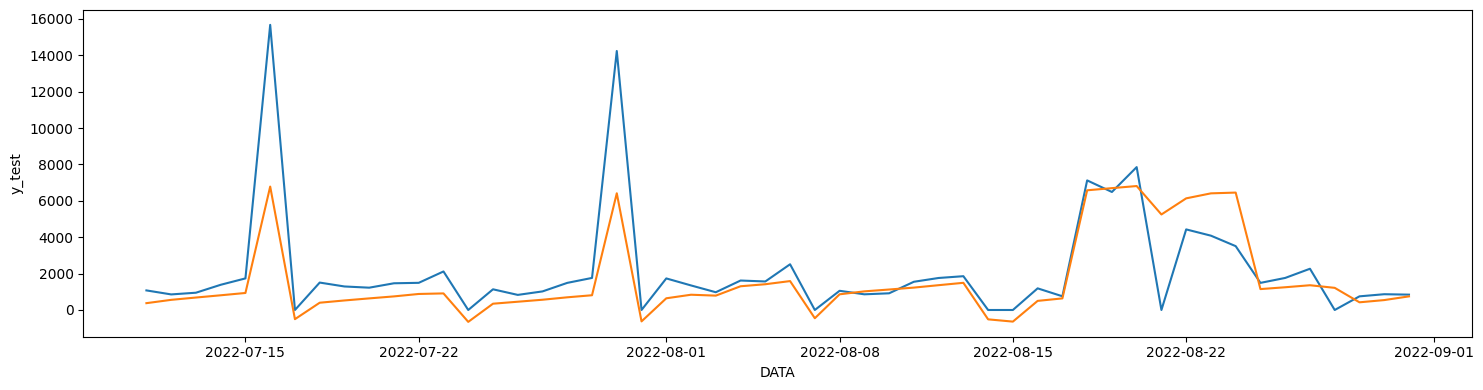

In [21]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=SARIMAX_pred, x=SARIMAX_pred.DATA, y='y_test')
sns.lineplot(data=SARIMAX_pred, x=SARIMAX_pred.DATA, y='y_predict')
plt.tight_layout()
plt.show()

In [22]:
# Metryki
mae_SARIMAX, rmse_SARIMAX, r2_SARIMAX, wmape_SARIMAX, mase_SARIMAX = ff.metryki(SARIMAX_pred['y_test'], SARIMAX_pred['y_predict'])
print(f'MAE: {mae_SARIMAX:.4f}, RMSE: {rmse_SARIMAX:.4f}, R2: {r2_SARIMAX:.4f}, WMAPE: {wmape_SARIMAX:.4f}, MASE: {mase_SARIMAX:.4f}')

MAE: 1047.7152, RMSE: 1975.9936, R2: 0.5787, WMAPE: 0.3844, MASE: 0.5114


In [23]:
# Komórka techniczna, do usunięcia przed publikacją
mae_SARIMAX = 1047.7151
rmse_SARIMAX = 1975.9936
r2_SARIMAX = 0.5787
wmape_SARIMAX = 0.3844
mase_SARIMAX = 0.5114

### Prophet

Model Prophet to narzędzie do prognozowania szeregów czasowych, opracowane przez Facebooka. Jest on wykorzystywany do przewidywania trendów i sezonowości w danych czasowych, szczególnie w przypadku danych z powtarzającymi się wzorcami.

Charakterystyczną cechą modelu Prophet jest jego prostota obsługi i elastyczność. Może być stosowany do prognozowania zarówno krótkoterminowych, jak i długoterminowych trendów, a także do uwzględniania skomplikowanych sezonowości, takich jak sezonowość dzienna, tygodniowa czy roczna.


---



---


Model Prophet opiera się na kombinacji dwóch komponentów:

Trendy sezonowe: Model Prophet automatycznie wykrywa i uwzględnia sezonowość w danych, identyfikując powtarzające się wzorce w czasie. Może to obejmować codzienne, tygodniowe, miesięczne, kwartalne lub roczne sezonowości. Model jest w stanie elastycznie dostosować się do różnych typów sezonowości i uwzględnić je w prognozach.

Komponenty dodatkowe: Oprócz sezonowości, model Prophet może również uwzględnić inne czynniki, które mogą mieć wpływ na dane szeregów czasowych. Mogą to być zmienne egzogeniczne, takie jak dane pogodowe, święta, promocje itp. Model automatycznie dostosowuje się do tych czynników i uwzględnia je w prognozach.

In [24]:
# Parametry
seasonality_prior_scale = [10, 20, 30]
holidays_prior_scale = [10, 20, 30]
changepoint_prior_scale = [0.01, 0.05, 0.1]
growth = ['linear']

In [25]:
# Słownik polskich świąt dla lat 2019-2022
years = [2019, 2020, 2021, 2022]
holidays = holidays.PL(years=years)

holidays = pd.DataFrame({
    'ds': list(holidays.keys()),
    'holiday': list(holidays.values())
})

In [26]:
# Dane treningowe i testowe
df_prophet = df.reset_index().rename(columns={'DATA': 'ds'})
train = df_prophet[df_prophet.ds < '2022-07-10']
test = df_prophet[df_prophet.ds >= '2022-07-10']

In [27]:
# Tworzenie kombinacji parametrów
param_combinations_prophet = list(product(seasonality_prior_scale, holidays_prior_scale, changepoint_prior_scale, growth))
len(param_combinations_prophet)

27

In [28]:
# Inicjalizacja wynikowej ramki danych
results_df_prophet = pd.DataFrame(columns=['Fold', 'seasonality_prior_scale', 'holidays_prior_scale',
                                           'changepoint_prior_scale', 'MAE', 'RMSE', 'R2', 'WMAPE', 'MASE'])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(train)):
    train_data = train.iloc[train_index]
    test_data = train.iloc[test_index]

    best_rmse = float('inf')
    best_params = None

    # Iteracja po kombinacjach parametrów
    for params in param_combinations_prophet:
        seasonality_prior_scale, holidays_prior_scale, changepoint_prior_scale, growth = params

        prophet_model = Prophet(growth=growth,
                                yearly_seasonality=True,
                                weekly_seasonality=True,
                                daily_seasonality=False,
                                holidays=holidays,
                                seasonality_mode='multiplicative',
                                seasonality_prior_scale=seasonality_prior_scale,
                                holidays_prior_scale=holidays_prior_scale,
                                changepoint_prior_scale=changepoint_prior_scale)

        prophet_model.add_regressor('CENA_NP')
        prophet_model.add_regressor('CENA_AP')
        prophet_model.add_regressor('PRZECENA')
        prophet_model.add_regressor('CENA_MARKET')
        prophet_model.add_regressor('PROMO_KOD')
        prophet_model.add_regressor('Nr_dn_tyg')
        prophet_model.add_regressor('Nr_dn_mies')
        prophet_model.add_regressor('Nr_mies')
        prophet_model.add_regressor('Nr_tyg')
        prophet_model.add_regressor('Nr_rok')
        prophet_model.add_regressor('Dn_handlowy')
        prophet_model.add_regressor('Hot_day')
        prophet_model.add_regressor('Hot_day_Xmass')
        prophet_model.add_regressor('Hot_day_Wlkn')
        prophet_model.add_regressor('HICP')

        prophet_model.fit(train_data)

        future = prophet_model.predict(test_data)

        y_pred_prophet = future[-len(test_data):]['yhat']
        rmse = mean_squared_error(test_data['y'], y_pred_prophet, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    # Utworzenie najlepszego modelu
    seasonality_prior_scale, holidays_prior_scale, changepoint_prior_scale, growth = best_params

    prophet_model = Prophet(growth=growth,
                            yearly_seasonality=True,
                            weekly_seasonality=True,
                            daily_seasonality=False,
                            holidays=holidays,
                            seasonality_mode='multiplicative',
                            seasonality_prior_scale=seasonality_prior_scale,
                            holidays_prior_scale=holidays_prior_scale,
                            changepoint_prior_scale=changepoint_prior_scale)

    prophet_model.add_regressor('CENA_NP')
    prophet_model.add_regressor('CENA_AP')
    prophet_model.add_regressor('PRZECENA')
    prophet_model.add_regressor('CENA_MARKET')
    prophet_model.add_regressor('PROMO_KOD')
    prophet_model.add_regressor('Nr_dn_tyg')
    prophet_model.add_regressor('Nr_dn_mies')
    prophet_model.add_regressor('Nr_mies')
    prophet_model.add_regressor('Nr_tyg')
    prophet_model.add_regressor('Nr_rok')
    prophet_model.add_regressor('Dn_handlowy')
    prophet_model.add_regressor('Hot_day')
    prophet_model.add_regressor('Hot_day_Xmass')
    prophet_model.add_regressor('Hot_day_Wlkn')
    prophet_model.add_regressor('HICP')

    prophet_model.fit(train_data)

    future = prophet_model.predict(test_data)

    y_pred_prophet = future[-len(test_data):]['yhat']

    # Obliczenie metryk
    y_true = test_data['y']
    y_true.reset_index(drop=True, inplace=True)
    best_mae, best_rmse, best_r2, best_wmape, best_mase = ff.metryki(y_true, y_pred_prophet)

    # Dodanie najlepszych wyników metryk do ramki danych
    results_df_prophet = results_df_prophet.append({'Fold': fold, 'seasonality_prior_scale': seasonality_prior_scale,
                                                    'holidays_prior_scale': holidays_prior_scale,
                                                    'changepoint_prior_scale': changepoint_prior_scale,
                                                    'MAE': best_mae, 'RMSE': best_rmse,
                                                    'R2': best_r2, 'WMAPE': best_wmape, 'MASE': best_mase},
                                                   ignore_index=True)

In [30]:
# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_prophet.head()

Fold  seasonality_prior_scale  holidays_prior_scale  \
0   0.0                     20.0                  20.0   
1   1.0                     30.0                  20.0   
2   2.0                     20.0                  20.0   
3   3.0                     20.0                  20.0   
4   4.0                     10.0                  30.0   

   changepoint_prior_scale          MAE          RMSE         R2     WMAPE  \
0                     0.10  1528.769416   3129.464153  -0.284223  0.748248   
1                     0.01   715.078516    948.223160   0.784146  4.191848   
2                     0.01  6202.670963  22696.872014 -47.840726  1.420975   
3                     0.01   667.500355   1439.723685   0.673802  9.223618   
4                     0.01   458.954458    816.267106   0.773063  4.338474   

       MASE  
0  1.278107  
1  0.817585  
2  5.562637  
3  0.608982  
4  0.646593

In [31]:
# Ramka danych do przedykcji
test_prophet = test.drop('y', axis=1)
test_prophet.reset_index(drop=True, inplace=True)

In [32]:
# Predykcja
prophet_forecast = prophet_model.predict(test_prophet)

In [33]:
# Tworzenie DataFrame do wizualizacji
y_true = test['y'].reset_index(drop=True)
y_pred = prophet_forecast['yhat'].reset_index(drop=True)
result_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred})

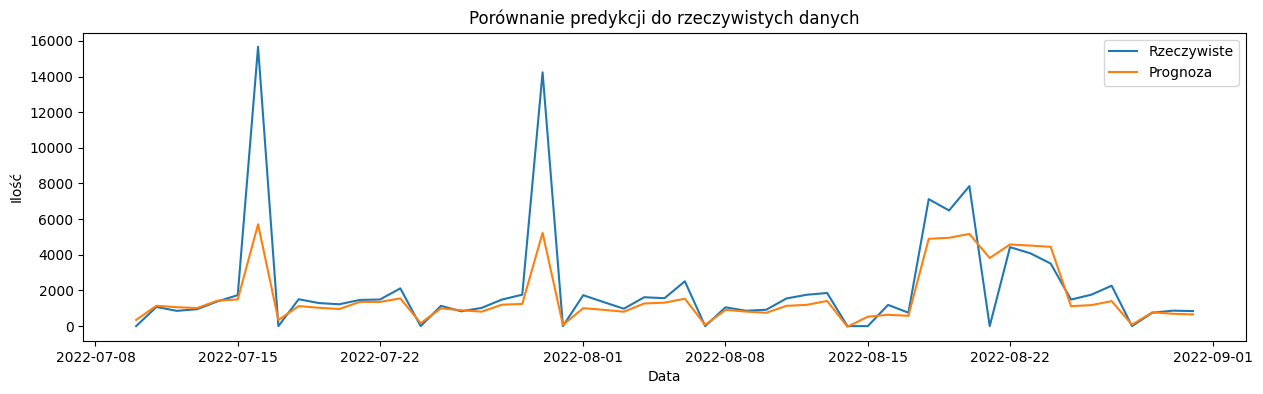

In [34]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
plt.plot(test.ds, result_df['y_true'], label='Rzeczywiste')
plt.plot(test.ds, result_df['y_pred'], label='Prognoza')
plt.xlabel('Data')
plt.ylabel('Ilość')
plt.title('Porównanie predykcji do rzeczywistych danych')
plt.legend()
plt.show()

In [35]:
# Metryki
mae_prophet, rmse_prophet, r2_prophet, wmape_prophet, mase_prophet = ff.metryki(y_true, y_pred)
print(f'MAE: {mae_prophet:.4f}, RMSE: {rmse_prophet:.4f}, R2: {r2_prophet:.4f}, WMAPE: {wmape_prophet:.4f}, MASE: {mase_prophet:.4f}')

MAE: 821.7948, RMSE: 2020.3256, R2: 0.5553, WMAPE: 0.2295, MASE: 0.4048


In [36]:
# Komórka techniczna, do usunięcia przed publikacją
mae_prophet = 821.7948
rmse_prophet = 2020.3256
r2_prophet = 0.5553
wmape_prophet = 0.2295
mase_prophet = 0.4048

### XGBoost

XGBoost (Extreme Gradient Boosting) to zaawansowany model uczenia maszynowego, który wykorzystuje technikę wzmacniania gradientowego (boostingu) do prognozowania lub klasyfikacji danych. Jest to jedna z najbardziej popularnych i skutecznych technik w konkursach dotyczących uczenia maszynowego.

XGBoost opiera się na połączeniu wielu słabych modeli (najczęściej drzew decyzyjnych) w celu stworzenia silnego modelu predykcyjnego. Proces trenowania modelu XGBoost odbywa się iteracyjnie, w którym każdy kolejny model jest dopasowywany w celu skorygowania błędów popełnionych przez poprzednie modele. W ten sposób, model XGBoost koncentruje się na predykcji resztkowych (czyli różnicy między rzeczywistymi wartościami a prognozowanymi), w celu coraz lepszego dopasowania do danych.

XGBoost wykorzystuje funkcję straty (loss function), taką jak błąd średniokwadratowy (MSE) lub logarytmiczna funkcja straty (log loss), do oceny błędu modelu w każdej iteracji. Następnie, na podstawie tej funkcji straty, aktualizowane są wagi drzew decyzyjnych, aby minimalizować błąd prognozy.


#### Przygotowanie danych

In [ ]:
# Wczytanie danych
df = pd.read_pickle('/content/drive/MyDrive/DS Projekt/PICKLE/df_3.pkl')
# Ograniczenie danych do jednego klastra oraz wybranie jednego arrtykułu
df = df.loc[df['CLUSTER']==2].drop(['CLUSTER'], axis=1)
df = df.loc[df['ART_ID']==158].drop(['ART_ID', 'GRUPA_ID', 'NAZWA'], axis=1) 
df.set_index('DATA', inplace=True)
#Kopia
df_XGB = df.copy()

In [ ]:
# Definicja kolumn względem typu danych
nominal_columns = ['PROMO_KOD', 'Dn_handlowy', 'Hot_day']
ordinal_columns = ['Hot_day_Xmass', 'Hot_day_Wlkn', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok']
numeric_columns = ['CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP']

# Tworzenie przekształceń
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numeric_transformer = MinMaxScaler()

# Tworzenie ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_columns),
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('numeric', numeric_transformer, numeric_columns)
    ])

# Tworzenie pipeline'u
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Przekształcanie danych
X_train, y_train = df_XGB.loc[df_XGB.index <='2022-07-10 00:00:00'], df_XGB.loc[df_XGB.index <= '2022-07-10 00:00:00']
X_test, y_test = df_XGB.loc[df_XGB.index>'2022-07-10 00:00:00'], df_XGB.loc[df_XGB.index > '2022-07-10 00:00:00']
X_train = X_train.drop(columns=['y'])
X_test = X_test.drop(columns=['y'])
y_train = y_train['y']
y_test = y_test['y']

#### Gradient Boosting

In [ ]:
# Parametry
n_estimators_values = [50, 100, 300, 500, 1000, 1500]
learning_rate_values = [0.01, 0.02, 0.05, 0.1, 0.2]
max_depth_values = [2, 4, 6, 8, 10, 12]

In [ ]:
# Tworzenie kombinacji parametrów
param_combinations_XGB = list(product(n_estimators_values, learning_rate_values, max_depth_values))
len(param_combinations_XGB)

144

In [ ]:
# Inicjalizacja ramki danych do przechowywania wyników metryk dla każdego foldu
results_df_XGB = pd.DataFrame(columns=['Fold', 'n_estimators', 'learning_rate', 'max_depth', 'MAE', 'RMSE', 'R2', 'WMAPE', 'MASE'])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_XGB = X_train.iloc[train_index]
    X_test_XGB = X_train.iloc[test_index]
    y_train_XGB = y_train.iloc[train_index]
    y_test_XGB = y_train.iloc[test_index]
    # Kodowanie
    X_train_XGB = pipeline.fit_transform(X_train_XGB)
    X_test_XGB = pipeline.transform(X_test_XGB)
   
    best_rmse = float('inf')
    best_params = None

    # Iteracja po kombinacjach parametrów
    for params in param_combinations_XGB:
        n_estimators, learning_rate, max_depth = params
        XGB = xgb.XGBRegressor(objective='reg:squarederror',
                                n_jobs=-1, 
                                random_state=42,
                                n_estimators=n_estimators,
                                learning_rate=learning_rate,
                                max_depth=max_depth,
                                tree_method='gpu_hist')
        XGB.fit(X_train_XGB, y_train_XGB)
        y_pred_XGB = XGB.predict(X_test_XGB)
        rmse = mean_squared_error(y_test_XGB, y_pred_XGB, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    # Utworzenie najlepszego modelu
    n_estimators, learning_rate, max_depth = best_params
    XGB = xgb.XGBRegressor(objective='reg:squarederror',
                            n_jobs=-1, 
                            random_state=42,
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth,
                            tree_method='gpu_hist')
    XGB.fit(X_train_XGB, y_train_XGB)
    y_pred_XGB = XGB.predict(X_test_XGB)

    # Obliczenie metryk
    best_mae, best_rmse, best_r2, best_wmape, best_mase = ff.metryki(y_test_XGB, y_pred_XGB)

    # Dodanie najlepszych wyników metryk do ramki danych
    results_df_XGB = results_df_XGB.append({'Fold': fold, 'n_estimators': n_estimators,
                                                        'learning_rate': learning_rate, 'max_depth': max_depth,
                                                        'MAE': best_mae, 'RMSE': best_rmse, 'R2': best_r2,
                                                        'WMAPE': best_wmape, 'MASE': best_mase}, ignore_index=True)

In [ ]:
# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_XGB.head()

Fold  n_estimators  learning_rate  max_depth         MAE         RMSE  \
0   0.0        1500.0           0.02        3.0  932.726440  1841.917847   
1   1.0         500.0           0.02        3.0  404.422729   648.143066   
2   2.0        1500.0           0.02        5.0  636.859192  1515.611084   
3   3.0        1500.0           0.01        3.0  367.920868   659.642700   
4   4.0         500.0           0.02        3.0  360.288879   704.063232   

         R2 MAPE      MASE     WMAPE  
0  0.566386  NaN  0.752044  0.394682  
1  0.892155  NaN  0.469610  0.878559  
2  0.794174  NaN  0.539508  0.332802  
3  0.923919  NaN  0.340095  2.152482  
4  0.831256  NaN  0.500308  1.921122

In [ ]:
# Najlepsze parametry XGBRegressor
print('Najlepsze parametry znalezione:', XGB.get_params())

Najlepsze parametry znalezione: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.02, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 500, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


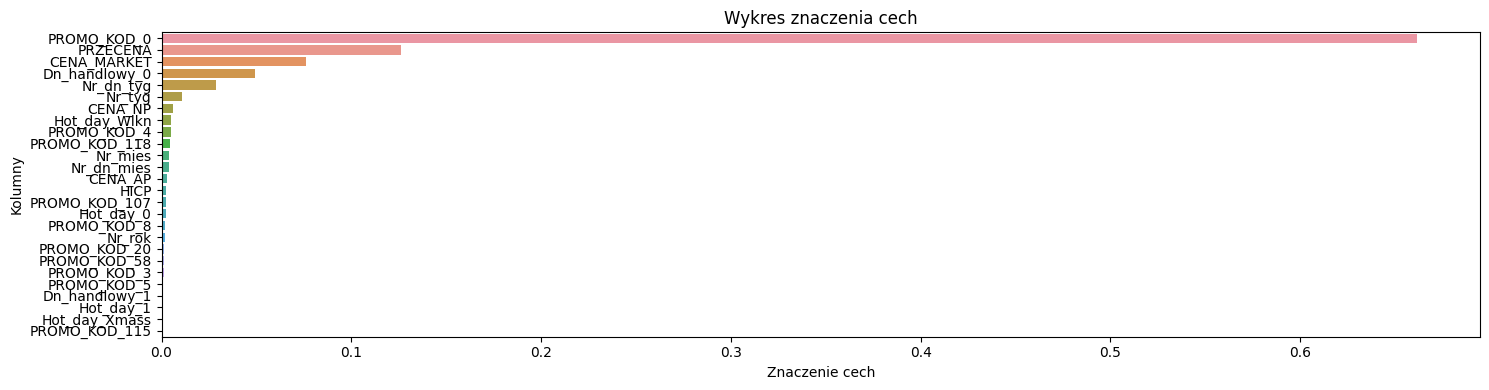

In [ ]:
# Pobieranie znaczenia cech z modelu
importance_scores = XGB.feature_importances_

# Tworzenie słownika mapującego indeksy kolumn na nazwy oryginalne
column_names = []
column_transformers = preprocessor.transformers_
for transformer_name, transformer, column_indices in column_transformers:
    if transformer_name == 'nominal':
        nominal_column_names = transformer.get_feature_names_out(nominal_columns)
        column_names.extend(nominal_column_names)
    elif transformer_name == 'ordinal':
        ordinal_column_names = column_indices
        column_names.extend(ordinal_column_names)
    elif transformer_name == 'numeric':
        numeric_column_names = numeric_columns
        column_names.extend(numeric_column_names)

# Sortowanie cech według znaczenia
sorted_indices = importance_scores.argsort()[::-1]
sorted_column_names = [column_names[i] for i in sorted_indices]
sorted_importance_scores = importance_scores[sorted_indices]

# Generowanie wykresu znaczenia cech z dostosowanymi etykietami przy użyciu Seaborn
plt.figure(figsize=(15, 4))
sns.barplot(x=sorted_importance_scores, y=sorted_column_names, orient='h')
plt.xlabel('Znaczenie cech')
plt.ylabel('Kolumny')
plt.title('Wykres znaczenia cech')
plt.tight_layout()
plt.show()


In [ ]:
# Kodowanie 
X_train_XGB = pipeline.fit_transform(X_train)
X_test_XGB = pipeline.transform(X_test)
# Tworzenie predykcji
XGB.fit(X_train_XGB, y_train)
y_predict_xgb = XGB.predict(X_test_XGB)

In [ ]:
# Tworzenie DataFrame do wizualizacji
xgb_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
xgb_pred['y_test'] = xgb_pred['y']
xgb_pred = xgb_pred.drop('y', axis=1)
xgb_pred['y_predict'] = y_predict_xgb

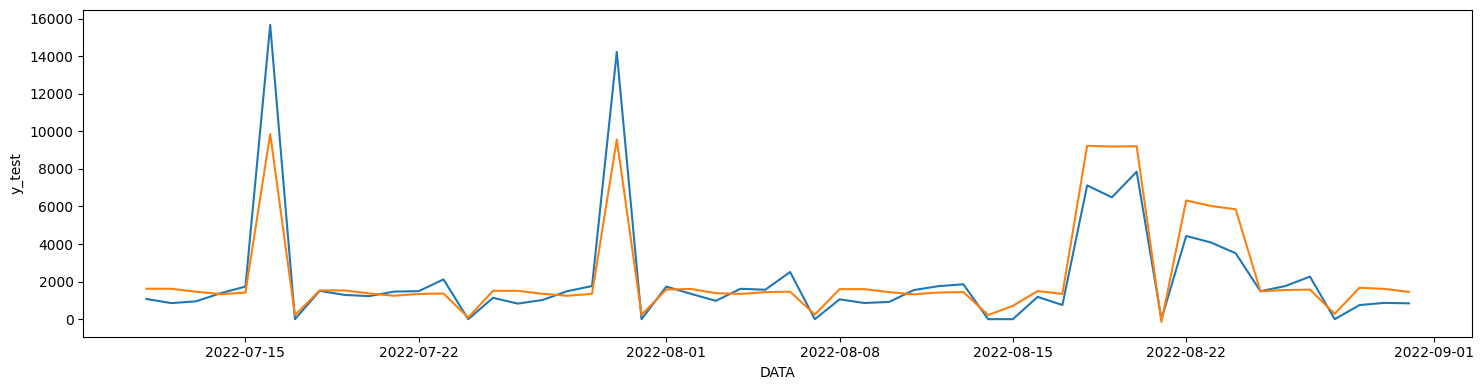

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=xgb_pred, x=xgb_pred.index, y='y_test')
sns.lineplot(data=xgb_pred, x=xgb_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_XGB, rmse_XGB, r2_XGB, wmape_XGB, mase_XGB = ff.metryki(y_test, y_predict_xgb)
print(f'MAE: {mae_XGB:.4f}, RMSE: {rmse_XGB:.4f}, R2: {r2_XGB:.4f}, WMAPE: {wmape_XGB:.4f}, MASE: {mase_XGB:.4f}')

MAE: 766.6458, RMSE: 1325.4833, R2: 0.8104, WMAPE: 0.3697%, MASE: 0.3742


In [37]:
# Komórka techniczna, do usunięcia przed publikacją
mae_XGB = 766.6458
rmse_XGB = 1325.4833
r2_XGB = 0.8104
wmape_XGB = 0.3697
mase_XGB = 0.3742

### Prophet + XGBoost

Metoda, która łączy model XGBoost z modelem Prophet, polega na wykorzystaniu predykcji modelu Prophet jako dodatkowych cech (zmiennych egzogenicznych) dla modelu XGBoost. Proces ten ma na celu wykorzystanie komplementarnych umiejętności obu modeli i poprawę jakości prognoz.

Kroki, które można podjąć, aby zastosować tę metodę, to:

1. Trenowanie modelu Prophet: Na początku trenujemy model Prophet na dostępnych danych szeregów czasowych. Model ten może uwzględniać sezonowość, trendy i inne czynniki wpływające na szereg czasowy.

2. Wygenerowanie predykcji modelu Prophet: Po trenowaniu modelu Prophet generujemy predykcje dla przyszłych punktów czasowych. Te predykcje zawierają informacje o przewidywanych wartościach szeregu czasowego na podstawie modelu Prophet.

3. Wybór odpowiednich cech: Następnie wybieramy niektóre kolumny z predykcji modelu Prophet, które uznajemy za istotne i mogą stanowić dodatkowe cechy dla modelu XGBoost. Mogą to być na przykład przewidywane wartości w różnych okresach czasu lub różnice między przewidywanymi a rzeczywistymi wartościami.

4. Połączenie z modelem XGBoost: Po wyborze odpowiednich cech z predykcji modelu Prophet, te cechy są dodawane do zbioru danych treningowych dla modelu XGBoost. Następnie, model XGBoost jest trenowany na tych danych, wykorzystując te dodatkowe cechy jako zmiennych egzogenicznych.

5. Prognozowanie z użyciem połączonego modelu: Po trenowaniu modelu XGBoost z dodatkowymi cechami, możemy go wykorzystać do prognozowania przyszłych wartości szeregu czasowego. Model XGBoost wykorzystuje zarówno informacje z danych historycznych, jak i z dodatkowych cech z modelu Prophet, aby dostarczyć prognozy o lepszej precyzji.

Ta metoda łączy umiejętności modelu Prophet w przewidywaniu trendów i sezonowości z silną predykcyjną zdolnością modelu XGBoost. Poprzez wykorzystanie informacji z obu modeli, można uzyskać bardziej wszechstronne i dokładne prognozy szeregów czasowych.

In [43]:
# Wczytanie danych
df = pd.read_pickle('/content/drive/MyDrive/DS Projekt/PICKLE/df_3.pkl')
# Ograniczenie danych do jednego klastra oraz wybranie jednego arrtykułu
df = df.loc[df['CLUSTER']==2].drop(['CLUSTER'], axis=1)
df = df.loc[df['ART_ID']==158].drop(['ART_ID', 'GRUPA_ID', 'NAZWA'], axis=1) 
df.set_index('DATA', inplace=True)
#Kopia
df_XGB_Prophet = df.copy()

In [44]:
# Prognoza
forecast = prophet_model.predict(df_prophet.iloc[:,:-1])
forecast = forecast.set_index('ds').rename_axis('DATA', axis='index')
forecast.head(3)

trend  yhat_lower   yhat_upper  trend_lower  trend_upper  \
DATA                                                                         
2019-09-02  1519.250927 -313.655182  2835.032926  1519.250927  1519.250927   
2019-09-03  1518.997429 -366.548872  2768.541495  1518.997429  1518.997429   
2019-09-04  1518.743932 -450.753683  2583.407650  1518.743932  1518.743932   

            All Saints' Day  All Saints' Day_lower  All Saints' Day_upper  \
DATA                                                                        
2019-09-02              0.0                    0.0                    0.0   
2019-09-03              0.0                    0.0                    0.0   
2019-09-04              0.0                    0.0                    0.0   

            Assumption of the Virgin Mary  \
DATA                                        
2019-09-02                            0.0   
2019-09-03                            0.0   
2019-09-04                            0.0   

            Assumption of the Virgin Mary_lower  \
DATA                                              
2019-09-02                                  0.0   
2019-09-03                                  0.0   
2019-09-04                                  0.0   

            Assumption of the Virgin Mary_upper   CENA_AP  CENA_AP_lower  \
DATA                                                                       
2019-09-02                                  0.0  0.168216       0.168216   
2019-09-03                                  0.0  0.168216       0.168216   
2019-09-04                                  0.0  0.168216       0.168216   

            CENA_AP_upper  CENA_MARKET  CENA_MARKET_lower  CENA_MARKET_upper  \
DATA                                                                           
2019-09-02       0.168216     0.336430           0.336430           0.336430   
2019-09-03       0.168216     0.391699           0.391699           0.391699   
2019-09-04       0.168216     0.347944           0.347944           0.347944   

             CENA_NP  CENA_NP_lower  CENA_NP_upper  Christmas (Day 1)  \
DATA                                                                    
2019-09-02 -0.109604      -0.109604      -0.109604                0.0   
2019-09-03 -0.109604      -0.109604      -0.109604                0.0   
2019-09-04 -0.109604      -0.109604      -0.109604                0.0   

            Christmas (Day 1)_lower  Christmas (Day 1)_upper  \
DATA                                                           
2019-09-02                      0.0                      0.0   
2019-09-03                      0.0                      0.0   
2019-09-04                      0.0                      0.0   

            Christmas (Day 2)  Christmas (Day 2)_lower  \
DATA                                                     
2019-09-02                0.0                      0.0   
2019-09-03                0.0                      0.0   
2019-09-04                0.0                      0.0   

            Christmas (Day 2)_upper  Corpus Christi  Corpus Christi_lower  \
DATA                                                                        
2019-09-02                      0.0             0.0                   0.0   
2019-09-03                      0.0             0.0                   0.0   
2019-09-04                      0.0             0.0                   0.0   

            Corpus Christi_upper  Dn_handlowy  Dn_handlowy_lower  \
DATA                                                               
2019-09-02                   0.0     0.068431           0.068431   
2019-09-03                   0.0     0.068431           0.068431   
2019-09-04                   0.0     0.068431           0.068431   

            Dn_handlowy_upper  Easter Monday  Easter Monday_lower  \
DATA                                                                
2019-09-02           0.068431            0.0                  0.0   
2019-09-03           0.068431            0.0                  0.0

In [45]:
# Wybór odpowiednich zmiennych z ramki danych forecast
prophet_variables = forecast.loc[:, ['trend', 'extra_regressors_multiplicative', 'multiplicative_terms', 'weekly', 'yearly', 'PROMO_KOD_lower']]

# Połączenie zmiennych z ramką danych df_XGB_Prophet
df_XGB_Prophet = pd.concat([df_XGB_Prophet, prophet_variables], axis=1)

# Wyświetlenie pierwszych kilku wierszy z ramki danych df_XGB_Prophet
df_XGB_Prophet.head()

CENA_NP  CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD Nr_dn_tyg  \
DATA                                                                      
2019-09-02     5.99     5.99       0.0     5.657993         0         1   
2019-09-03     5.99     5.99       0.0     4.727133         0         2   
2019-09-04     5.99     5.99       0.0     5.464078         0         3   
2019-09-05     7.99     7.99       0.0     7.396029         0         4   
2019-09-06     7.99     7.99       0.0     7.541655         0         5   

           Nr_dn_mies Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day Hot_day_Xmass  \
DATA                                                                            
2019-09-02          2       9     36   2019           1       0             0   
2019-09-03          3       9     36   2019           1       0             0   
2019-09-04          4       9     36   2019           1       0             0   
2019-09-05          5       9     36   2019           1       0             0   
2019-09-06          6       9     36   2019           1       0             0   

           Hot_day_Wlkn        HICP            y        trend  \
DATA                                                            
2019-09-02            0  105.199997  1303.949951  1519.250927   
2019-09-03            0  105.199997  1561.709961  1518.997429   
2019-09-04            0  105.199997   894.440002  1518.743932   
2019-09-05            0  105.199997   689.469971  1518.490434   
2019-09-06            0  105.199997  1078.989990  1518.236936   

            extra_regressors_multiplicative  multiplicative_terms    weekly  \
DATA                                                                          
2019-09-02                         0.025662             -0.203386 -0.064826   
2019-09-03                         0.067626             -0.232652 -0.141392   
2019-09-04                         0.010565             -0.327582 -0.185022   
2019-09-05                        -0.138629             -0.041253  0.244339   
2019-09-06                        -0.160581              0.021959  0.322969   

              yearly  PROMO_KOD_lower  
DATA                                   
2019-09-02 -0.164222        -0.101946  
2019-09-03 -0.158886        -0.101946  
2019-09-04 -0.153125        -0.101946  
2019-09-05 -0.146963        -0.101946  
2019-09-06 -0.140429        -0.101946

In [46]:
# Definicja kolumn względem typu danych
nominal_columns = ['PROMO_KOD', 'Dn_handlowy', 'Hot_day']
ordinal_columns = ['Hot_day_Xmass', 'Hot_day_Wlkn', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok']
numeric_columns = ['CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP', 'trend', 'extra_regressors_multiplicative', 'multiplicative_terms', 'weekly', 'yearly', 'PROMO_KOD_lower']

# Tworzenie przekształceń
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numeric_transformer = MinMaxScaler()

# Tworzenie ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_columns),
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('numeric', numeric_transformer, numeric_columns)
    ])

# Tworzenie pipeline'u
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Przekształcanie danych
X_train, y_train = df_XGB_Prophet.loc[df_XGB_Prophet.index <='2022-07-10 00:00:00'], df_XGB_Prophet.loc[df_XGB_Prophet.index <= '2022-07-10 00:00:00']
X_test, y_test = df_XGB_Prophet.loc[df_XGB_Prophet.index>'2022-07-10 00:00:00'], df_XGB_Prophet.loc[df_XGB_Prophet.index > '2022-07-10 00:00:00']
X_train = X_train.drop(columns=['y'])
X_test = X_test.drop(columns=['y'])
y_train = y_train['y']
y_test = y_test['y']

In [47]:
# Parametry
n_estimators_values = [50, 100, 300, 500, 1000, 1500]
learning_rate_values = [0.01, 0.02, 0.05, 0.1]
max_depth_values = [3, 5, 6, 8, 10, 12]

In [48]:
# Tworzenie kombinacji parametrów
param_combinations_XGB_Prophet = list(product(n_estimators_values, learning_rate_values, max_depth_values))
len(param_combinations_XGB_Prophet)

144

In [49]:
# Inicjalizacja ramki danych do przechowywania wyników metryk dla każdego foldu
results_df_XGB_Prophet = pd.DataFrame(columns=['Fold', 'n_estimators', 'learning_rate', 'max_depth', 'MAE', 'RMSE', 'R2', 'WMAPE', 'MASE'])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [50]:
# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_XGB_Prophet = X_train.iloc[train_index]
    X_test_XGB_Prophet = X_train.iloc[test_index]
    y_train_XGB_Prophet = y_train.iloc[train_index]
    y_test_XGB_Prophet = y_train.iloc[test_index]
    # Kodowanie
    X_train_XGB_Prophet = pipeline.fit_transform(X_train_XGB_Prophet)
    X_test_XGB_Prophet = pipeline.transform(X_test_XGB_Prophet)
   
    best_rmse = float('inf')
    best_params = None

    # Iteracja po kombinacjach parametrów
    for params in param_combinations_XGB_Prophet:
        n_estimators, learning_rate, max_depth = params
        XGB_Prophet = xgb.XGBRegressor(objective='reg:squarederror',
                                n_jobs=-1, 
                                random_state=42,
                                n_estimators=n_estimators,
                                learning_rate=learning_rate,
                                max_depth=max_depth,
                                tree_method='gpu_hist')    
        XGB_Prophet.fit(X_train_XGB_Prophet, y_train_XGB_Prophet)
        y_pred_XGB_Prophet = XGB_Prophet.predict(X_test_XGB_Prophet)
        rmse = mean_squared_error(y_test_XGB_Prophet, y_pred_XGB_Prophet, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    # Utworzenie najlepszego modelu
    n_estimators, learning_rate, max_depth = best_params
    XGB_Prophet = xgb.XGBRegressor(objective='reg:squarederror',
                            n_jobs=-1, 
                            random_state=42,
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth,
                            tree_method='gpu_hist')
    XGB_Prophet.fit(X_train_XGB_Prophet, y_train_XGB_Prophet)
    y_pred_XGB = XGB_Prophet.predict(X_test_XGB_Prophet)

    # Obliczenie metryk
    best_mae, best_rmse, best_r2, best_wmape, best_mase = ff.metryki(y_test_XGB_Prophet, y_pred_XGB_Prophet)

    # Dodanie najlepszych wyników metryk do ramki danych
    results_df_XGB_Prophet = results_df_XGB_Prophet.append({'Fold': fold, 'n_estimators': n_estimators,
                                                        'learning_rate': learning_rate, 'max_depth': max_depth,
                                                        'MAE': best_mae, 'RMSE': best_rmse, 'R2': best_r2,
                                                        'WMAPE': best_wmape, 'MASE': best_mase}, ignore_index=True)

In [51]:
# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_XGB_Prophet.head()

Fold  n_estimators  learning_rate  max_depth         MAE         RMSE  \
0   0.0         300.0           0.10        3.0  852.020935  1911.849243   
1   1.0         100.0           0.10        6.0  240.709900   586.003174   
2   2.0         500.0           0.01        3.0  490.060608  1083.381714   
3   3.0          50.0           0.10        5.0  556.470154  1173.140991   
4   4.0         100.0           0.10        5.0  334.201355   781.275757   

         R2     WMAPE      MASE  
0  0.532835  0.362159  0.686972  
1  0.911843  0.424006  0.279509  
2  0.894831  0.385142  0.415149  
3  0.759364  1.062672  0.514384  
4  0.792215  0.621996  0.464082

In [52]:
# Najlepsze parametry XGBRegressor
print('Najlepsze parametry znalezione:', XGB_Prophet.get_params())

Najlepsze parametry znalezione: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 5, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 100, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


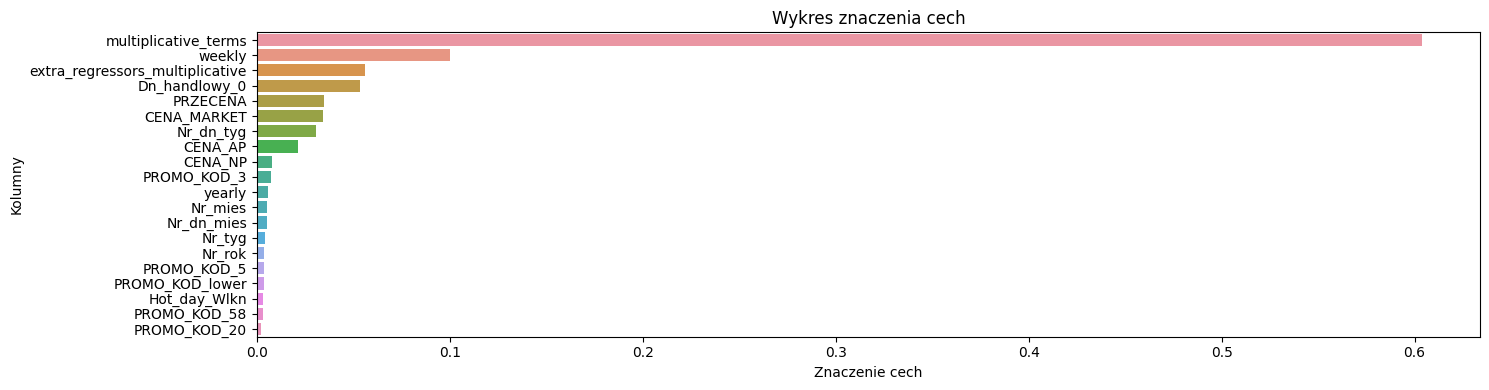

In [59]:
# Pobieranie znaczenia cech z modelu
importance_scores = XGB_Prophet.feature_importances_

# Tworzenie słownika mapującego indeksy kolumn na nazwy oryginalne
column_names = []
column_transformers = preprocessor.transformers_
for transformer_name, transformer, column_indices in column_transformers:
    if transformer_name == 'nominal':
        nominal_column_names = transformer.get_feature_names_out(nominal_columns)
        column_names.extend(nominal_column_names)
    elif transformer_name == 'ordinal':
        ordinal_column_names = column_indices
        column_names.extend(ordinal_column_names)
    elif transformer_name == 'numeric':
        numeric_column_names = numeric_columns
        column_names.extend(numeric_column_names)

# Sortowanie cech według znaczenia
sorted_indices = importance_scores.argsort()[::-1]
sorted_column_names = [column_names[i] for i in sorted_indices]
sorted_importance_scores = importance_scores[sorted_indices]

# Generowanie wykresu znaczenia cech z dostosowanymi etykietami przy użyciu Seaborn
plt.figure(figsize=(15, 4))
sns.barplot(x=sorted_importance_scores[:20], y=sorted_column_names[:20], orient='h')
plt.xlabel('Znaczenie cech')
plt.ylabel('Kolumny')
plt.title('Wykres znaczenia cech')
plt.tight_layout()
plt.show()

In [54]:
# Kodowanie 
X_train_XGB_Prophet = pipeline.fit_transform(X_train)
X_test_XGB_Prophet = pipeline.transform(X_test)
# Tworzenie predykcji
XGB_Prophet.fit(X_train_XGB_Prophet, y_train)
y_predict_XGB_Prophet = XGB_Prophet.predict(X_test_XGB_Prophet)

In [55]:
# Tworzenie DataFrame do wizualizacji
XGB_Prophet_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
XGB_Prophet_pred['y_test'] = XGB_Prophet_pred['y']
XGB_Prophet_pred = XGB_Prophet_pred.drop('y', axis=1)
XGB_Prophet_pred['y_predict'] = y_predict_XGB_Prophet

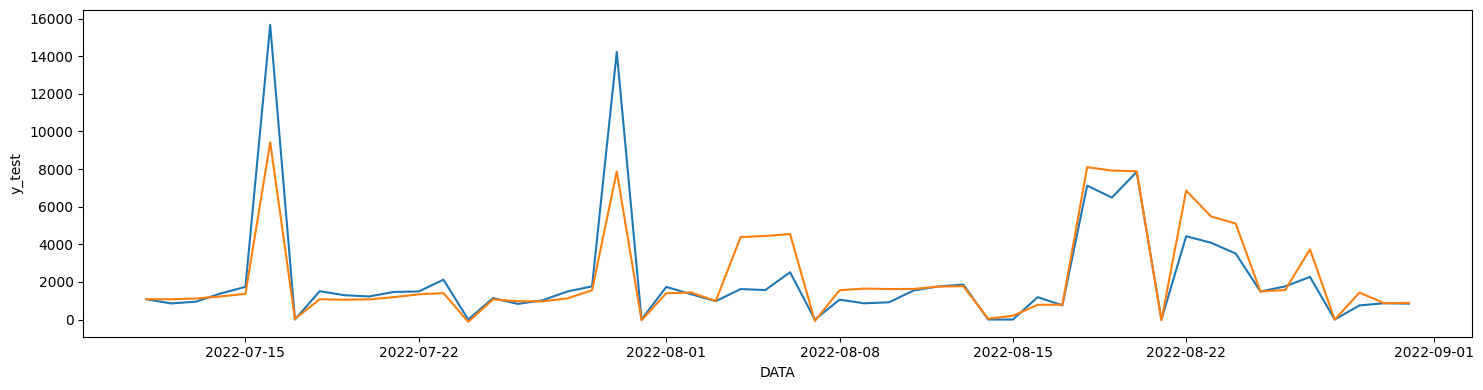

In [56]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=XGB_Prophet_pred, x=XGB_Prophet_pred.index, y='y_test')
sns.lineplot(data=XGB_Prophet_pred, x=XGB_Prophet_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [60]:
# Metryki
mae_XGB_Prophet, rmse_XGB_Prophet, r2_XGB_Prophet, wmape_XGB_Prophet, mase_XGB_Prophet = ff.metryki(y_test, y_predict_XGB_Prophet)
print(f'MAE: {mae_XGB_Prophet:.4f}, RMSE: {rmse_XGB_Prophet:.4f}, R2: {r2_XGB_Prophet:.4f}, WMAPE: {wmape_XGB_Prophet:.4f}, MASE: {mase_XGB_Prophet:.4f}')

MAE: 728.5372, RMSE: 1511.2217, R2: 0.7536, WMAPE: 0.3224, MASE: 0.3556


In [38]:
# Komórka techniczna, do usunięcia przed publikacją
mae_XGB_Prophet = 728.5372
rmse_XGB_Prophet = 1511.2217
r2_XGB_Prophet = 0.7536
wmape_XGB_Prophet = 0.3224
mase_XGB_Prophet = 0.3556

### Sieć neuronowa - DENSE, model Vanilla

Model Dense Vanilla w TensorFlow to podstawowy model sieci neuronowej, który składa się z sekwencji warstw gęstych (dense layers) w bibliotece TensorFlow. W tym modelu każdy neuron w danej warstwie jest połączony z każdym neuronem w poprzedniej i następnej warstwie, tworząc pełne połączenie między warstwami.

Charakterystyczne cechy modelu Dense Vanilla w TensorFlow to:

1. Warstwy gęste: Model składa się z warstw gęstych, gdzie każda warstwa jest w pełni połączona z poprzednią i następną warstwą. Każdy neuron w danej warstwie jest połączony z każdym neuronem w poprzedniej i następnej warstwie, co daje pełne połączenie między warstwami.

2. Liczba neuronów: Model można dostosować do różnych problemów poprzez zmianę liczby neuronów w warstwach gęstych. Większa liczba neuronów może zwiększyć pojemność modelu, ale może również wymagać więcej zasobów obliczeniowych.

3. Funkcje aktywacji: Każda warstwa gęsta w modelu może mieć zastosowaną funkcję aktywacji, która wprowadza nieliniowość do wyników neuronów. Popularne funkcje aktywacji to ReLU (Rectified Linear Unit), sigmoid czy tangens hiperboliczny.

4. Kompilacja i trening: Przed rozpoczęciem treningu modelu, należy go skompilować, określając funkcję straty (np. średni błąd kwadratowy, entropia krzyżowa), optymalizator (np. SGD, Adam) oraz metryki, które będą oceniać wydajność modelu. Następnie model jest trenowany na danych treningowych, a wagi w warstwach gęstych są aktualizowane w celu minimalizacji funkcji straty.

5. Ocena i predykcja: Po zakończeniu treningu, model może być oceniany na danych testowych za pomocą określonych metryk, takich jak dokładność czy średni błąd kwadratowy. Nauczone modele mogą być również wykorzystywane do dokonywania predykcji na nowych danych.

Model Dense Vanilla w TensorFlow jest elastycznym i prostym modelem, który można dostosować do różnych zadań, takich jak klasyfikacja czy regresja. Jego struktura oparta na warstwach gęstych zapewnia modelowi zdolność do nauki złożonych zależności w danych. Dzięki wygodnym narzędziom i funkcjom dostępnym w TensorFlow, implementacja modelu Dense Vanilla jest stosunkowo prosta i wydajna.

In [ ]:
# Konwersja danych na tensory TensorFlow
X_train_tensor = tf.convert_to_tensor(X_train_transformed)
X_test_tensor = tf.convert_to_tensor(X_test_transformed)

In [ ]:
# Budowanie modelu
model_vanilla = Sequential(name='vanilla')
model_vanilla.add(Dense(16, activation='relu', input_shape=(X_train_tensor.shape[1],)))
model_vanilla.add(Dense(8, activation='relu'))
model_vanilla.add(Dense(1, activation='linear'))

# Kompilowanie modelu
optimizer = Adam(learning_rate=0.008)

model_vanilla.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Podsumowanie modelu
model_vanilla.summary()

Model: "vanilla"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 16)                432       
                                                                 
 dense_11 (Dense)            (None, 8)                 136       
                                                                 
 dense_12 (Dense)            (None, 1)                 9         
                                                                 
Total params: 577
Trainable params: 577
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Trenowanie modelu
history_vanilla = model_vanilla.fit(X_train_tensor, y_train, epochs=200, batch_size=32, validation_data=(X_test_tensor, y_test), verbose=0)

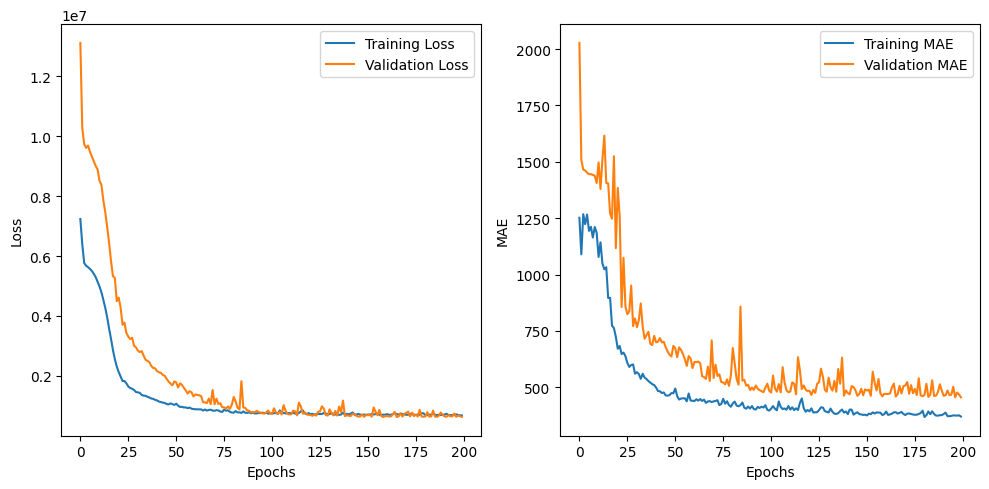

In [ ]:
# Pobieranie danych z historii
loss = history_vanilla.history['loss']
val_loss = history_vanilla.history['val_loss']
mae = history_vanilla.history['mae']
val_mae = history_vanilla.history['val_mae']

# Wizualizacja historii funkcji straty
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wizualizacja historii metryki MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Ewaluacja modelu
loss, mae = model_vanilla.evaluate(X_test_tensor, y_test)
print('Strata:', loss)
print('MAE:', mae)

2/2 [==============================] - 0s 11ms/step - loss: 635055.7500 - mae: 455.3268
Strata: 635055.75
MAE: 455.32684326171875


In [ ]:
# Tworzenie predykcji
y_predict_dense_vanilla = model_vanilla.predict(X_test_transformed)

2/2 [==============================] - 0s 8ms/step


In [ ]:
# Tworzenie DataFrame do wizualizacji
vanilla_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
vanilla_pred['y_test'] = vanilla_pred['y']
vanilla_pred = vanilla_pred.drop('y', axis=1)
vanilla_pred['y_predict'] = y_predict_dense_vanilla

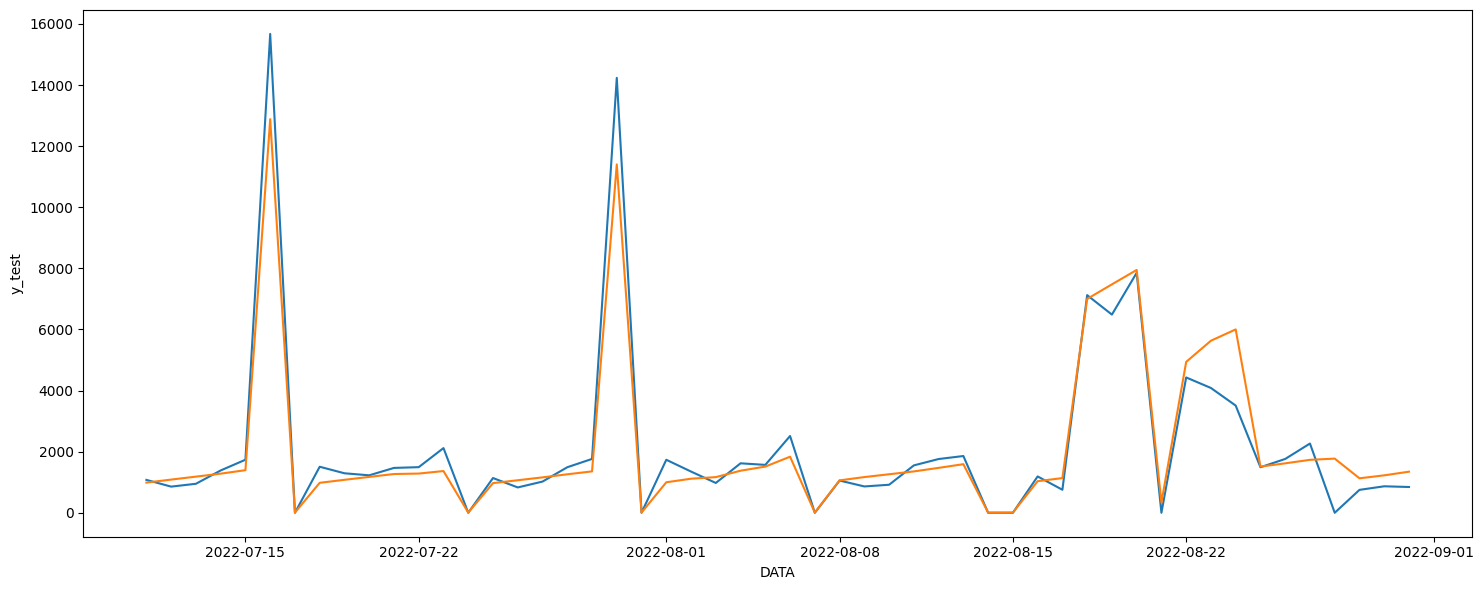

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 6))
sns.lineplot(data=vanilla_pred, x=vanilla_pred.index, y='y_test')
sns.lineplot(data=vanilla_pred, x=vanilla_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_dense_vanilla, rmse_dense_vanilla, r2_dense_vanilla, wmape_dense_vanilla, mase_dense_vanilla = ff.metryki(y_test, y_predict_dense_vanilla.reshape(-1))
print(f'MAE: {mae_dense_vanilla:.4f}, RMSE: {rmse_dense_vanilla:.4f}, R2: {r2_dense_vanilla:.4f}, WMAPE: {wmape_dense_vanilla:.4f}, MASE: {mase_dense_vanilla:.4f}')

In [62]:
# Komórka techniczna, do usunięcia przed publikacją
mae_dense_vanilla = 455.3268
rmse_dense_vanilla = 796.9039
r2_dense_vanilla = 0.9315
wmape_dense_vanilla = 0.2198
mase_dense_vanilla = 0.2223

### Sieć neuronowa - DENSE, rozbudowana sieć

Model Dense z większą ilością neuronów i większą ilością warstw w TensorFlow jest rozbudowaną wersją modelu Dense Vanilla. W tym modelu zwiększa się zarówno liczbę neuronów w warstwach, jak i liczbę warstw, aby zwiększyć pojemność i zdolność modelu do wykrywania złożonych wzorców w danych.

Charakterystyczne cechy modelu Dense z większą ilością neuronów i większą ilością warstw w TensorFlow to:

1. Liczba neuronów: Model ma większą liczbę neuronów w warstwach gęstych w porównaniu do modelu Dense Vanilla. Większa liczba neuronów pozwala na zwiększenie pojemności modelu, co może umożliwić bardziej skomplikowane reprezentacje danych.

2. Liczba warstw: Model zawiera większą ilość warstw gęstych. Dodawanie kolejnych warstw pozwala na budowanie bardziej głębokich sieci neuronowych, które mogą uczyć się hierarchicznych cech w danych.

3. Nieliniowość: Model wykorzystuje funkcje aktywacji, takie jak ReLU (Rectified Linear Unit), które wprowadzają nieliniowość do wyników neuronów. Ta nieliniowość jest istotna dla zdolności modelu do modelowania złożonych zależności między danymi.

4. Regularyzacja: W większych modelach, zwłaszcza z większą ilością warstw i neuronów, regularyzacja może być ważna w celu uniknięcia przeuczenia. Można zastosować techniki regularyzacji, takie jak regularyzacja L1/L2 lub Dropout, aby zmniejszyć wpływ przypadkowych szumów i zwiększyć zdolność generalizacji modelu.

5. Obliczenia równoległe: W przypadku dużych modeli z większą ilością warstw i neuronów, możliwe jest wykorzystanie obliczeń równoległych, takich jak wykorzystanie GPU, aby przyspieszyć proces uczenia.

Modele Dense z większą ilością neuronów i większą ilością warstw w TensorFlow mają większą zdolność do nauki złożonych wzorców w danych, ale mogą również wymagać większych zasobów obliczeniowych i czasu trenowania. Ważne jest odpowiednie dobranie liczby neuronów, liczby warstw i technik regularyzacji, aby uniknąć przeuczenia i uzyskać optymalne wyniki predykcji.

In [ ]:
# Konwersja danych na tensory TensorFlow
X_train_tensor = tf.convert_to_tensor(X_train_transformed)
X_test_tensor = tf.convert_to_tensor(X_test_transformed)

In [ ]:
# Budowanie modelu
model_dense = Sequential(name='dense')
model_dense.add(Dense(32, activation='relu', input_shape=(X_train_tensor.shape[1],)))
model_dense.add(Dropout(0.1))
model_dense.add(Dense(32, activation='relu'))
model_dense.add(Dropout(0.1))
model_dense.add(Dense(16, activation='relu'))
model_dense.add(Dropout(0.1))
model_dense.add(Dense(8, activation='relu'))
model_dense.add(Dense(1, activation='linear'))

# Kompilowanie modelu
optimizer = Adam(learning_rate=0.001)
model_dense.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Podsumowanie modelu
model_dense.summary()

Model: "dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 32)                864       
                                                                 
 dropout_31 (Dropout)        (None, 32)                0         
                                                                 
 dense_38 (Dense)            (None, 32)                1056      
                                                                 
 dropout_32 (Dropout)        (None, 32)                0         
                                                                 
 dense_39 (Dense)            (None, 16)                528       
                                                                 
 dropout_33 (Dropout)        (None, 16)                0         
                                                                 
 dense_40 (Dense)            (None, 8)                 136   

In [ ]:
# Callback'i
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)

callbacks = [early_stopping, reduce_lr]

In [ ]:
# Trenowanie modelu z callback'ami
history_dense = model_dense.fit(X_train_tensor, y_train, epochs=1000, batch_size=32, validation_data=(X_test_tensor, y_test), callbacks=callbacks, verbose=0)

In [ ]:
# Ewaluacja modelu
loss2, mae2 = model_dense.evaluate(X_test_tensor, y_test)
print('Strata:', loss2)
print('MAE:', mae2)

2/2 [==============================] - 0s 11ms/step - loss: 934911.5625 - mae: 564.6660
Strata: 934911.5625
MAE: 564.6659545898438


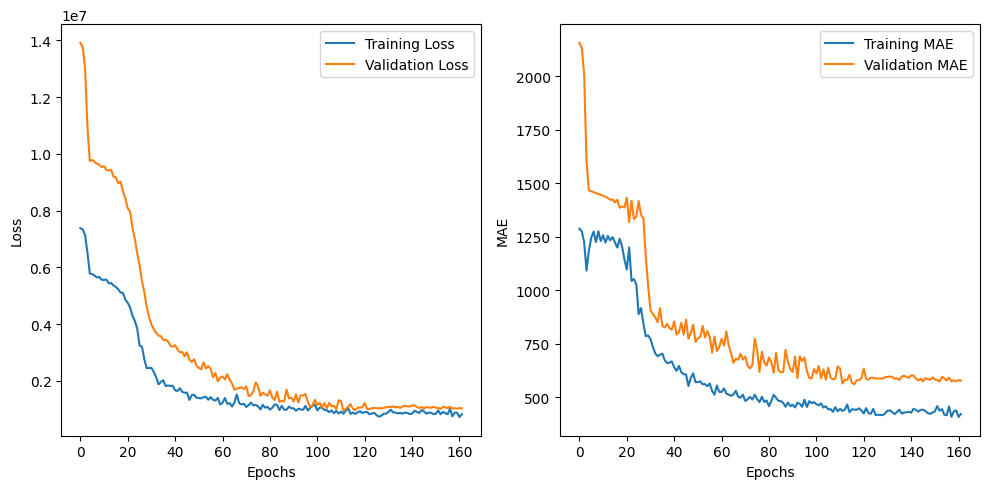

In [ ]:
# Pobieranie danych z historii
loss = history_dense.history['loss']
val_loss = history_dense.history['val_loss']
mae = history_dense.history['mae']
val_mae = history_dense.history['val_mae']

# Wizualizacja historii funkcji straty
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wizualizacja historii metryki MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Tworzenie predykcji
y_predict_dense = model_dense.predict(X_test_transformed)

2/2 [==============================] - 0s 5ms/step


In [ ]:
# Tworzenie DataFrame do wizualizacji
dense_pred = df.loc[df.index >'2022-07-10 00:00:00'][['y']]
dense_pred['y_test'] = dense_pred['y']
dense_pred = dense_pred.drop('y', axis=1)
dense_pred['y_predict'] = y_predict_dense

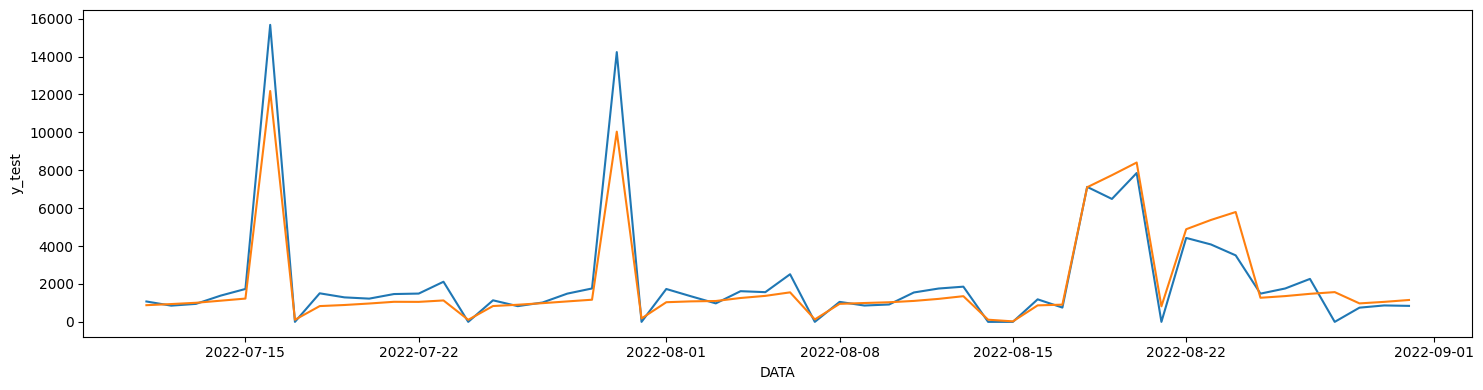

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=dense_pred, x=dense_pred.index, y='y_test')
sns.lineplot(data=dense_pred, x=dense_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_dense, rmse_dense, r2_dense, wmape_dense, mase_dense = ff.metryki(y_test, y_predict_dense.reshape(-1))
print(f'MAE: {mae_dense:.4f}, RMSE: {rmse_dense:.4f}, R2: {r2_dense:.4f}, WMAPE: {wmape_dense:.4f}, MASE: {mase_dense:.4f}')

In [39]:
# Komórka techniczna, do usunięcia przed publikacją
mae_dense = 564.6660
rmse_dense = 966.9083
r2_dense = 0.8991
wmape_dense= 0.2381
mase_dense = 0.2756

### Rekrurencyjna sieć neuronowa - LSTM

Model sieci rekurencyjnej LSTM (Long Short-Term Memory) w TensorFlow to model, który wykorzystuje warstwy LSTM do analizy i przetwarzania sekwencji danych. LSTM jest rodzajem sieci rekurencyjnej, która ma zdolność do zapamiętywania długoterminowych zależności w danych sekwencyjnych.

Charakterystyczne cechy modelu sieci rekurencyjnej LSTM w TensorFlow to:

1. Warstwy LSTM: Model składa się z warstw LSTM, które są odpowiedzialne za przetwarzanie sekwencji danych i zapamiętywanie informacji w pamięci długoterminowej. Warstwy LSTM mają wbudowany mechanizm bramek (gate mechanism), który kontroluje przepływ informacji przez sieć, pozwalając na uczenie się i zapamiętywanie odpowiednich informacji w zależności od kontekstu.

2. Pamięć długoterminowa i krótkoterminowa: Warstwy LSTM mają zdolność do przechowywania informacji w pamięci długoterminowej, co pozwala na uczenie się zależności na dłuższe odległości w sekwencjach danych. Dodatkowo, mają pamięć krótkoterminową, która przechowuje aktualny stan modelu w kontekście sekwencji.

3. Wsteczne propagowanie gradientu: Model LSTM używa wstecznego propagowania gradientu (backpropagation through time), aby uczyć się zależności sekwencyjnych. Proces ten polega na propagowaniu błędów wstecz przez całą sekwencję i aktualizacji wag w celu minimalizacji funkcji straty.

4. Stosowanie funkcji aktywacji: Warstwy LSTM wykorzystują różne funkcje aktywacji, takie jak tangens hiperboliczny (tanh) i sigmoid, które regulują przepływ informacji i kontrolują stan pamięci wewnątrz sieci.

5. Zastosowanie technik regularyzacji: Podobnie jak w innych modelach, można zastosować techniki regularyzacji, takie jak Dropout czy regularyzacja L1/L2, aby uniknąć przeuczenia modelu.

Sieci rekurencyjne LSTM w TensorFlow są szczególnie skuteczne w analizie danych sekwencyjnych, takich jak tekst, dźwięk czy szeregi czasowe. Mają zdolność do modelowania długoterminowych zależności i są powszechnie stosowane w dziedzinach takich jak przetwarzanie języka naturalnego, rozpoznawanie mowy czy prognozowanie szeregów czasowych.

In [ ]:
# Funkcja do przekształcenia danych
def reshape_data(data, time_steps):
    samples, features = data.shape
    # Tworzenie pustej tablicy o odpowiednim kształcie
    reshaped_data = np.zeros((samples - time_steps + 1, time_steps, features))
    
    # Przekształcanie danych
    for i in range(samples - time_steps + 1):
        reshaped_data[i] = data[i:i + time_steps]
    
    return reshaped_data

# Definiowanie liczby kroków czasowych
time_steps = 7

# Przekształcenie danych
X_train_3d = reshape_data(X_train_transformed, time_steps)
X_test_3d = reshape_data(X_test_transformed, time_steps)

# Przekształcenie etykiet
y_train_3d = y_train[time_steps - 1:].values
y_test_3d = y_test[time_steps - 1:].values

In [ ]:
# Parametry modelu
input_shape = X_train_3d.shape[1:]
lstm_units = 24
output_size = 1

In [ ]:
# Budowanie modelu
model_lstm = Sequential(name='lstm')
model_lstm.add(LSTM(lstm_units, input_shape=input_shape, return_sequences=True, activation='relu'))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(24, return_sequences=True, activation='relu'))
model_lstm.add(Dropout(0.1))
model_lstm.add(LSTM(24, activation='relu'))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(24, activation='relu'))
model_lstm.add(Dense(output_size))

In [ ]:
# Kompilacja modelu
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.0001)
callbacks = [early_stopping, reduce_lr]

In [ ]:
# Trenowanie modelu
history_lstm = model_lstm.fit(X_train_3d, y_train_3d, epochs=200, batch_size=32, validation_data=(X_test_3d, y_test_3d), callbacks=callbacks, verbose=0)

In [ ]:
# Ewaluacja modelu
loss_lstm, mae_lstm = model_lstm.evaluate(X_test_3d, y_test_3d)
print('Strata:', loss_lstm)
print('MAE:', mae_lstm)

2/2 [==============================] - 0s 12ms/step - loss: 6284100.0000 - mae: 1437.8304
Strata: 6284100.0
MAE: 1437.8304443359375


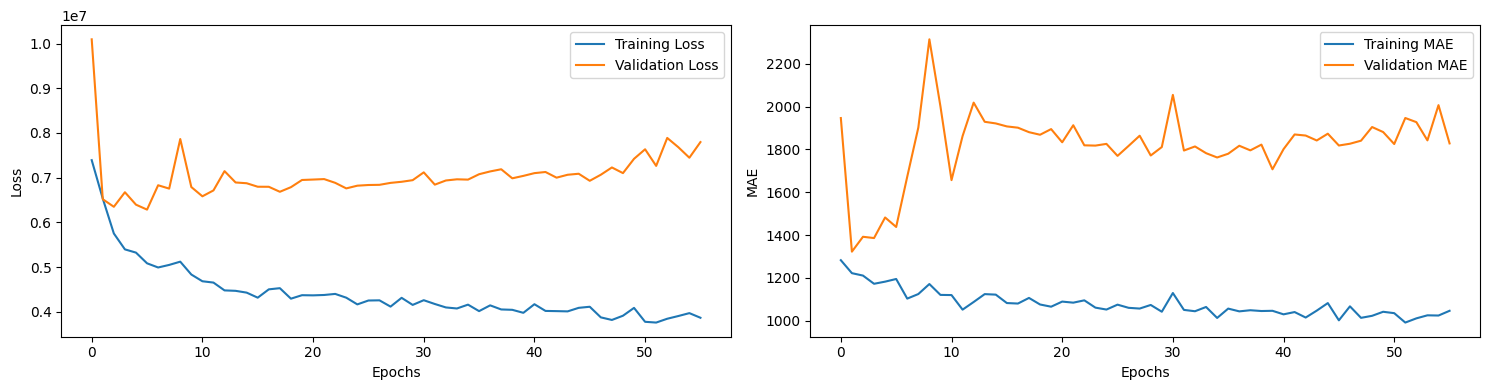

In [ ]:
# Pobieranie danych z historii
loss = history_lstm.history['loss']
val_loss = history_lstm.history['val_loss']
mae = history_lstm.history['mae']
val_mae = history_lstm.history['val_mae']

# Wizualizacja historii funkcji straty
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wizualizacja historii metryki MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Tworzenie predykcji
y_predict_lstm = model_lstm.predict(X_test_3d)

2/2 [==============================] - 1s 15ms/step


In [ ]:
# Tworzenie DataFrame do wizualizacji
lstm_pred = df.loc[df.index >'2022-07-16 00:00:00'][['y']]
lstm_pred['y_test'] = lstm_pred['y']
lstm_pred = lstm_pred.drop('y', axis=1)
lstm_pred = lstm_pred[:46]
lstm_pred['y_predict'] = y_predict_lstm.reshape(-1)

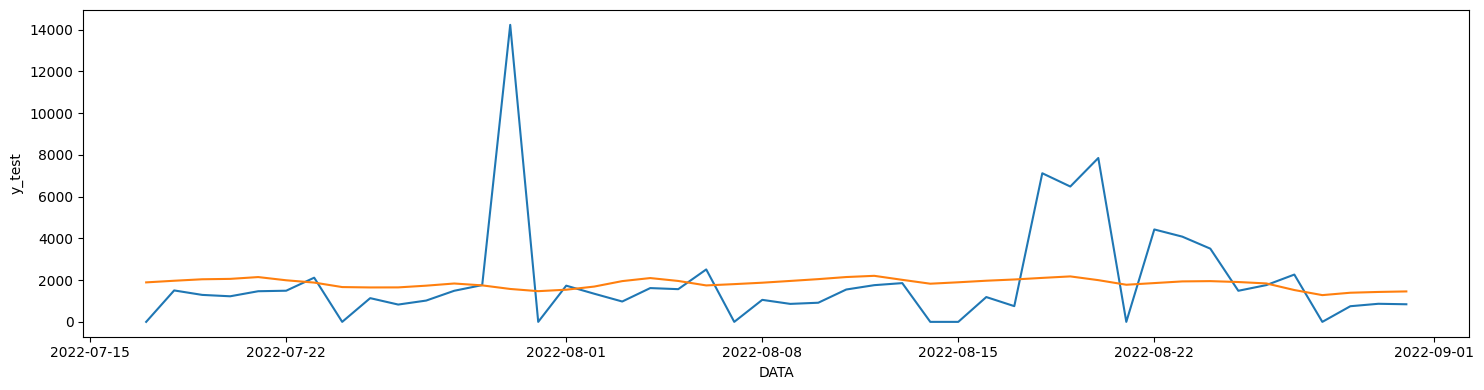

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=lstm_pred, x=lstm_pred.index, y='y_test')
sns.lineplot(data=lstm_pred, x=lstm_pred.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_lstm, rmse_lstm, r2_lstm, wmape_lstm, mase_lstm = ff.metryki(lstm_pred['y_test'], lstm_pred['y_predict'])
print(f'MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, R2: {r2_lstm:.4f}, WMAPE: {wmape_lstm:.4f}, MASE: {mase_lstm:.4f}')

In [40]:
# Komórka techniczna, do usunięcia przed publikacją
mae_lstm = 1631.6879
rmse_lstm = 2334.8633
r2_lstm = 0.1430
wmape_lstm = 0.9231
mase_lstm = 0.9952

## Budowa modeli oraz testów dla wielowymiarowych szeregów czasowych

#### Import i preprocesing danych

In [ ]:
# Wczytanie danych
df = pd.read_pickle('/content/drive/MyDrive/DS Projekt/PICKLE/df_3.pkl')
df = df.loc[df['CLUSTER']==2].drop(['CLUSTER'], axis=1)

In [ ]:
df.set_index('DATA', inplace=True)
NAZWA = df['NAZWA']
df.drop('NAZWA', inplace=True, axis=1)

In [ ]:
df.head()

GRUPA_ID ART_ID  CENA_NP  CENA_AP  PRZECENA  CENA_MARKET PROMO_KOD  \
DATA                                                                            
2019-09-02       19      1     3.49     3.49       0.0     2.990000         0   
2019-09-02        8      2     5.99     5.99       0.0     5.498056         0   
2019-09-02        8      3     4.99     4.99       0.0     4.543005         0   
2019-09-02        8      4     4.99     4.99       0.0     4.241022         0   
2019-09-02        8      5     5.99     5.99       0.0     5.308895         0   

           Nr_dn_tyg Nr_dn_mies Nr_mies Nr_tyg Nr_rok Dn_handlowy Hot_day  \
DATA                                                                        
2019-09-02         1          2       9     36   2019           1       0   
2019-09-02         1          2       9     36   2019           1       0   
2019-09-02         1          2       9     36   2019           1       0   
2019-09-02         1          2       9     36   2019           1       0   
2019-09-02         1          2       9     36   2019           1       0   

           Hot_day_Xmass Hot_day_Wlkn        HICP           y  
DATA                                                           
2019-09-02             0            0  105.199997   23.000000  
2019-09-02             0            0  105.199997   69.449997  
2019-09-02             0            0  105.199997   50.110001  
2019-09-02             0            0  105.199997  196.869995  
2019-09-02             0            0  105.199997   90.839996

##### Kodowanie danych

In [ ]:
# Definicja kolumn względem typu danych
nominal_columns = ['GRUPA_ID', 'ART_ID', 'PROMO_KOD', 'Dn_handlowy', 'Hot_day']
ordinal_columns = ['Hot_day_Xmass', 'Hot_day_Wlkn', 'Nr_dn_tyg', 'Nr_dn_mies', 'Nr_mies', 'Nr_tyg', 'Nr_rok']
numeric_columns = ['CENA_MARKET', 'CENA_AP', 'CENA_NP', 'PRZECENA', 'HICP']

# Tworzenie przekształceń
nominal_transformer = OneHotEncoder(handle_unknown='ignore')
ordinal_transformer = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
numeric_transformer = MinMaxScaler()

# Tworzenie ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('nominal', nominal_transformer, nominal_columns),
        ('ordinal', ordinal_transformer, ordinal_columns),
        ('numeric', numeric_transformer, numeric_columns)
    ])

# Tworzenie pipeline'u
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Przekształcanie danych
X_train, y_train = df.loc[df.index <='2022-07-10 00:00:00'], df.loc[df.index <= '2022-07-10 00:00:00']
X_test, y_test = df.loc[df.index>'2022-07-10 00:00:00'], df.loc[df.index > '2022-07-10 00:00:00']
X_train = X_train.drop(columns=['y'])
X_test = X_test.drop(columns=['y'])
y_train = y_train['y']
y_test = y_test['y']

# Zastosowanie pipeline'ow
X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

### XGBoost Gradient Boosting

In [ ]:
# Parametry
n_estimators_values = [50, 100, 300, 500, 1000, 1500]
learning_rate_values = [0.01, 0.02, 0.05]
max_depth_values = [2, 4, 6, 8, 10, 12]

In [ ]:
# Tworzenie kombinacji parametrów
param_combinations_XGB_2 = list(product(n_estimators_values, learning_rate_values, max_depth_values))
len(param_combinations_XGB_2)

108

In [ ]:
# Inicjalizacja ramki danych do przechowywania wyników metryk dla każdego foldu
results_df_XGB_2 = pd.DataFrame(columns=['Fold', 'n_estimators', 'learning_rate', 'max_depth', 'MAE', 'RMSE', 'R2', 'WMAPE', 'MASE'])

# Tworzenie obiektu TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)

In [ ]:
# Iteracja po foldach
for fold, (train_index, test_index) in enumerate(tscv.split(X_train)):
    X_train_XGB_2 = X_train.iloc[train_index]
    X_test_XGB_2 = X_train.iloc[test_index]
    y_train_XGB_2 = y_train.iloc[train_index]
    y_test_XGB_2 = y_train.iloc[test_index]
    # Kodowanie
    X_train_XGB_2 = pipeline.fit_transform(X_train_XGB_2)
    X_test_XGB_2 = pipeline.transform(X_test_XGB_2)
   
    best_rmse = float('inf')
    best_params = None

    # Iteracja po kombinacjach parametrów
    eval_set = [(X_test_XGB_2, y_test_XGB_2)]
    for params in param_combinations_XGB_2:
        n_estimators, learning_rate, max_depth = params
        XGB_2 = xgb.XGBRegressor(objective='reg:squarederror',
                                n_jobs=-1, 
                                random_state=42,
                                n_estimators=n_estimators,
                                learning_rate=learning_rate,
                                max_depth=max_depth,
                                tree_method='gpu_hist',
                                early_stopping_rounds=20
                                )
        XGB_2.fit(X_train_XGB_2, y_train_XGB_2, eval_set=eval_set)
        y_pred_XGB_2 = XGB_2.predict(X_test_XGB_2)
        rmse = mean_squared_error(y_test_XGB_2, y_pred_XGB_2, squared=False)

        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params

    # Utworzenie najlepszego modelu
    n_estimators, learning_rate, max_depth = best_params
    XGB_2 = xgb.XGBRegressor(objective='reg:squarederror',
                            n_jobs=-1, 
                            random_state=42,
                            n_estimators=n_estimators,
                            learning_rate=learning_rate,
                            max_depth=max_depth,
                            tree_method='gpu_hist',
                            early_stopping_rounds=20
                            )
    eval_set = [(X_test_XGB_2, y_test_XGB_2)]
    XGB_2.fit(X_train_XGB_2, y_train_XGB_2, eval_set=eval_set)
    y_pred_XGB_2 = XGB_2.predict(X_test_XGB_2)

    # Obliczenie metryk
    best_mae, best_rmse, best_r2, best_wmape, best_mase = ff.metryki(y_test_XGB_2, y_pred_XGB_2)

    # Dodanie najlepszych wyników metryk do ramki danych
    results_df_XGB_2 = results_df_XGB_2.append({'Fold': fold, 'n_estimators': n_estimators,
                                                        'learning_rate': learning_rate, 'max_depth': max_depth,
                                                        'MAE': best_mae, 'RMSE': best_rmse, 'R2': best_r2,
                                                        'WMAPE': best_wmape, 'MASE': best_mase}, ignore_index=True)

In [ ]:
# Zapis modelu do pliku
XGB_2.save_model('/content/drive/MyDrive/DS Projekt/XGB_2.model') #checkpoint

In [ ]:
# Wczytanie modelu z pliku
XGB_2 = xgb.XGBRegressor()
XGB_2.load_model('XGB_2.model')

In [ ]:
# Wyświetlenie ramki danych z wynikami metryk dla każdego foldu
results_df_XGB_2

Fold  n_estimators  learning_rate  max_depth         MAE        RMSE  \
0   0.0         300.0           0.05        8.0  114.781975  514.749512   
1   1.0        1000.0           0.02        8.0   97.824745  389.813049   
2   2.0        1500.0           0.05        8.0   72.553925  280.054352   

         R2      WMAPE      MASE  
0  0.634074   7.813302  0.526647  
1  0.718558  10.295111  0.465952  
2  0.826443   4.784000  0.369052

In [ ]:
# Najlepsze parametry XGBRegressor
print('Najlepsze parametry znalezione:', XGB_2.get_params())

Najlepsze parametry znalezione: {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'early_stopping_rounds': 20, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': None, 'gpu_id': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.05, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 8, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'n_estimators': 1500, 'n_jobs': -1, 'num_parallel_tree': None, 'predictor': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': 'gpu_hist', 'validate_parameters': None, 'verbosity': None}


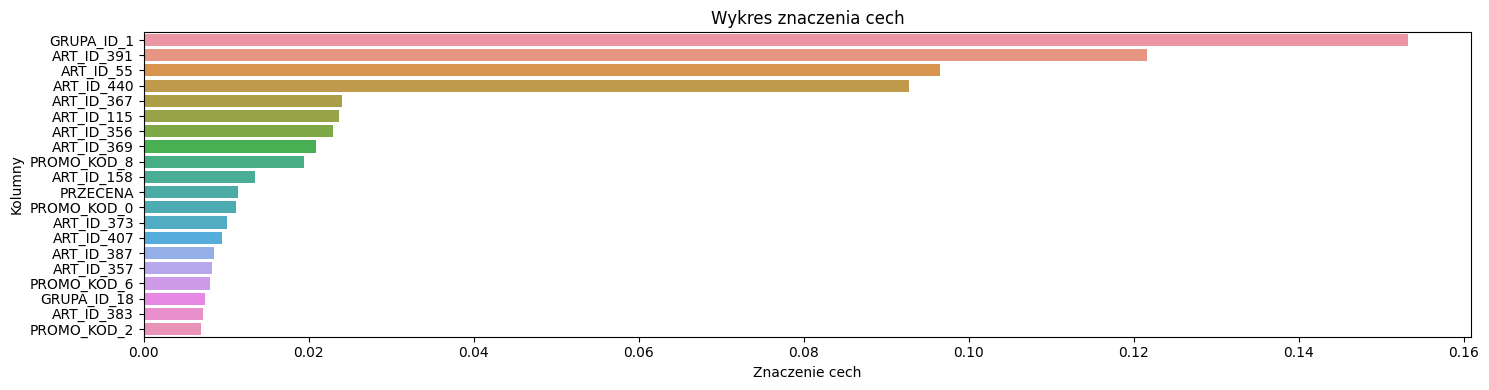

In [ ]:
# Pobieranie znaczenia cech z modelu
importance_scores = XGB_2.feature_importances_

# Tworzenie słownika mapującego indeksy kolumn na nazwy oryginalne
column_names = []
column_transformers = preprocessor.transformers_
for transformer_name, transformer, column_indices in column_transformers:
    if transformer_name == 'nominal':
        nominal_column_names = transformer.get_feature_names_out(nominal_columns)
        column_names.extend(nominal_column_names)
    elif transformer_name == 'ordinal':
        ordinal_column_names = column_indices
        column_names.extend(ordinal_column_names)
    elif transformer_name == 'numeric':
        numeric_column_names = numeric_columns
        column_names.extend(numeric_column_names)

# Sortowanie cech według znaczenia
sorted_indices = importance_scores.argsort()[::-1]
sorted_column_names = [column_names[i] for i in sorted_indices]
sorted_importance_scores = importance_scores[sorted_indices]

# Generowanie wykresu znaczenia cech z dostosowanymi etykietami przy użyciu Seaborn
plt.figure(figsize=(15, 4))
sns.barplot(x=sorted_importance_scores[:20], y=sorted_column_names[:20], orient='h')
plt.xlabel('Znaczenie cech')
plt.ylabel('Kolumny')
plt.title('Wykres znaczenia cech')
plt.tight_layout()
plt.show()


In [ ]:
# Kodowanie 
X_test_XGB_2_one_art = X_test[X_test['ART_ID'] == 158]
X_test_XGB_one_art = pipeline.transform(X_test_XGB_2_one_art)
X_test_XGB_one_art.shape

(52, 817)

In [ ]:
# Dostosowanie kształtu macierzy testowej z jednym artykułem do wymiarów macierzy treningowej
target_shape = (52, 817)  # Nowy wymiar docelowy

if X_test_XGB_one_art.shape != target_shape:
    # Tworzenie macierzy wypełnionej zerami o nowym wymiarze
    X_test_XGB_prepared = sp.csr_matrix((target_shape[0], target_shape[1]), dtype=np.float64)

    # Kopiowanie wartości z X_test_XGB_one_art do nowej macierzy
    X_test_XGB_prepared[:X_test_XGB_one_art.shape[0], :X_test_XGB_one_art.shape[1]] = X_test_XGB_one_art
else:
    X_test_XGB_prepared = X_test_XGB_one_art


# Tworzenie predykcji
y_predict_xgb_2 = XGB_2.predict(X_test_XGB_prepared)

In [ ]:
# Tworzenie DataFrame do wizualizacji
df_xgb = df.loc[df['ART_ID'] == 158]
xgb_pred_2 = df_xgb.loc[df_xgb.index >'2022-07-10 00:00:00'][['y']]
xgb_pred_2['y_test'] = xgb_pred_2['y']
xgb_pred_2 = xgb_pred_2.drop('y', axis=1)
xgb_pred_2['y_predict'] = y_predict_xgb_2

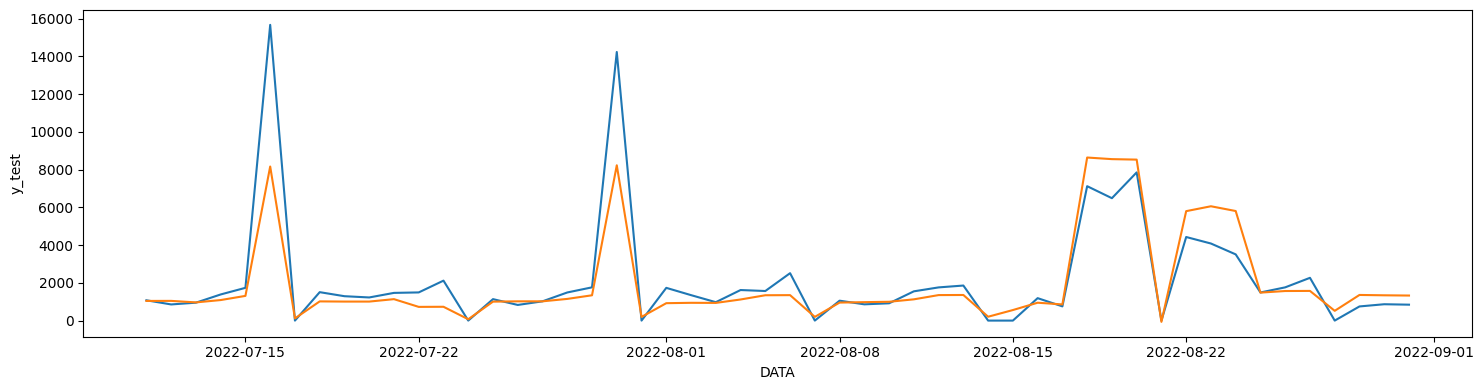

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=xgb_pred_2, x=xgb_pred_2.index, y='y_test')
sns.lineplot(data=xgb_pred_2, x=xgb_pred_2.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_XGB_2, rmse_XGB_2, r2_XGB_2, wmape_XGB_2, mase_XGB_2 = ff.metryki(xgb_pred_2['y_test'], xgb_pred_2['y_predict'])
print(f'MAE: {mae_XGB_2:.4f}, RMSE: {rmse_XGB_2:.4f}, R2: {r2_XGB_2:.4f}, WMAPE: {wmape_XGB_2:.4f}, MASE: {mase_XGB_2:.4f}')

In [41]:
# Komórka techniczna, do usunięcia przed publikacją
mae_XGB_2= 739.3627
rmse_XGB_2 = 1515.0146
r2_XGB_2 = 0.7523
wmape_XGB_2=0.2758
mase_XGB_2 = 0.3609

### Sieć neuronowa - DENSE, rozbudowana sieć

In [ ]:
# Konwersja danych rzadkich na tensor TensorFlow
X_train_dense = X_train_transformed.toarray()
X_test_dense = X_test_transformed.toarray()

X_train_tensor = tf.convert_to_tensor(X_train_dense, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_dense, dtype=tf.float32)

In [ ]:
#Definiowanie wejścia
input_layer = Input(shape=(X_train_tensor.shape[1],))

# Warstwy gęste
dense_layer_1 = Dense(512, activation='relu')(input_layer)
dropout_layer_1 = Dropout(0.1)(dense_layer_1)

dense_layer_2 = Dense(256, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.1)(dense_layer_2)

dense_layer_3 = Dense(128, activation='relu')(dropout_layer_2)
dropout_layer_3 = Dropout(0.1)(dense_layer_3)

dense_layer_4 = Dense(64, activation='relu')(dropout_layer_3)
dropout_layer_4 = Dropout(0.1)(dense_layer_4)

dense_layer_5 = Dense(32, activation='relu')(dropout_layer_4)
dropout_layer_5 = Dropout(0.1)(dense_layer_5)

output_layer = Dense(1, activation='linear')(dense_layer_5)

# Tworzenie modelu
model_dense_2 = Model(inputs=input_layer, outputs=output_layer, name='dense_2')

# Kompilowanie modelu
optimizer = Adam(learning_rate=0.005)
model_dense_2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Podsumowanie modelu
model_dense_2.summary()


Model: "dense_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 877)]             0         
                                                                 
 dense_40 (Dense)            (None, 512)               449536    
                                                                 
 dropout_30 (Dropout)        (None, 512)               0         
                                                                 
 dense_41 (Dense)            (None, 256)               131328    
                                                                 
 dropout_31 (Dropout)        (None, 256)               0         
                                                                 
 dense_42 (Dense)            (None, 128)               32896     
                                                                 
 dropout_32 (Dropout)        (None, 128)               0   

In [ ]:
# Callback'i
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)

callbacks = [early_stopping, reduce_lr]

In [ ]:
# Trenowanie modelu
history_dense_2 = model_dense_2.fit(X_train_tensor, y_train, epochs=500, batch_size=256, validation_data=(X_test_tensor, y_test), callbacks=callbacks, verbose=1)

In [ ]:
# Zapis modelu do pliku
model_dense_2.save('model_dense_2') #checkpoint

In [ ]:
# Wczytanie modelu z pliku
model_dense_2 = tf.keras.models.load_model('model_dense_2')

In [ ]:
# Ewaluacja modelu
loss_dense_2, mae_dense_2 = model_dense_2.evaluate(X_test_tensor, y_test)
print('Strata:', loss_dense_2)
print('MAE:', mae_dense_2)

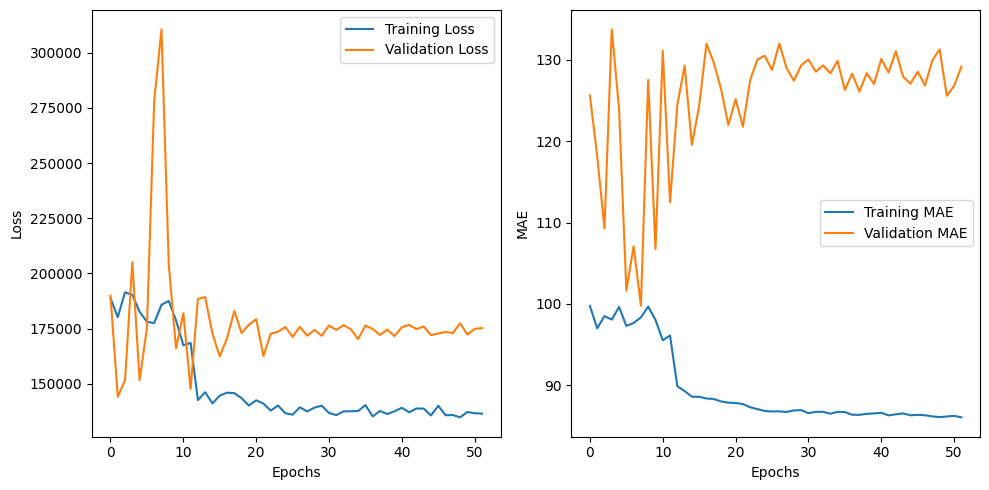

In [ ]:
# Pobieranie danych z historii
loss = history_dense_2.history['loss']
val_loss = history_dense_2.history['val_loss']
mae = history_dense_2.history['mae']
val_mae = history_dense_2.history['val_mae']

# Wizualizacja historii funkcji straty
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wizualizacja historii metryki MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Kodowanie 
X_train_dense_2 = pipeline.fit_transform(X_train)
X_test_dense_2  = X_test.loc[X_test['ART_ID'] == 158]
X_test_dense_2 = pipeline.transform(X_test_dense_2)
# Tworzenie predykcji
y_predict_dense_2 = model_dense_2.predict(X_test_dense_2)

2/2 [==============================] - 0s 6ms/step


In [ ]:
# Tworzenie DataFrame do wizualizacji
df_dense_2 = df.loc[df['ART_ID'] == 158]
dense_pred_2 = df_dense_2.loc[df_dense_2.index >'2022-07-10 00:00:00'][['y']]
dense_pred_2['y_test'] = dense_pred_2['y']
dense_pred_2 = dense_pred_2.drop('y', axis=1)
dense_pred_2['y_predict'] = y_predict_dense_2
dense_pred_2.shape

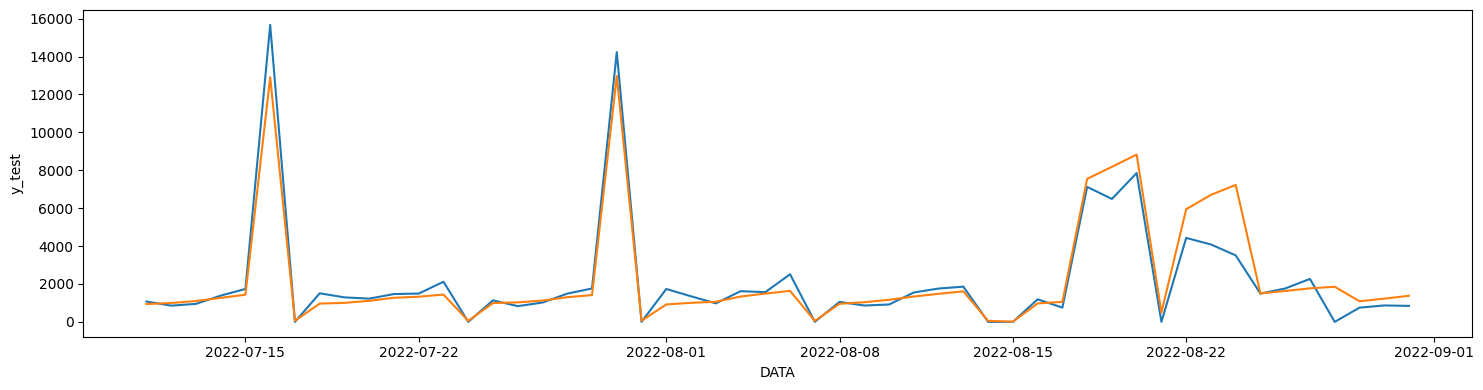

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=dense_pred_2, x=dense_pred_2.index, y='y_test')
sns.lineplot(data=dense_pred_2, x=dense_pred_2.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_dense_2, rmse_dense_2, r2_dense_2, wmape_dense_2, mase_dense_2 = ff.metryki(dense_pred_2['y_test'], dense_pred_2['y_predict'])
print(f'MAE: {mae_dense_2:.4f}, RMSE: {rmse_dense_2:.4f}, R2: {r2_dense_2:.4f}, WMAPE: {wmape_dense_2:.4f}, MASE: {mase_dense_2:.4f}')

MAE: 529.8080, RMSE: 920.3733, R2: 0.9086, WMAPE: 0.2332, MASE: 0.2586


In [65]:
# Komórka techniczna, do usunięcia przed publikacją
mae_dense_2 = 529.8080
rmse_dense_2 = 920.3733
r2_dense_2 = 0.9086
wmape_dense_2 = 0.2332
mase_dense_2 = 0.2586

### Sieć neuronowa - DENSE + EMBEDDING

Dodatkowa warstwa wejściowa typu embedding przyjmująca opisy produktów może znacznie poprawić działanie sieci Dense w przypadku analizy tekstu. Warstwa embeddingu służy do przekształcenia słów lub fraz na reprezentacje liczbowe o niższej wymiarowości.

Podstawowe cechy dodatkowej warstwy wejściowej embeddingu w sieci Dense to:

1. Przekształcenie tekstu na liczby: Warstwa embeddingu konwertuje słowa lub frazy na wektory liczbowe, które mogą być przetwarzane przez sieć neuronową. Każde słowo jest mapowane na odpowiedni wektor, który reprezentuje jego semantykę lub znaczenie w kontekście.

2. Zdolność do uwzględniania zależności semantycznych: Warstwa embeddingu bierze pod uwagę podobieństwo między słowami, umożliwiając sieci neuronowej rozróżnienie podobnych słów lub znajdowanie związków semantycznych między nimi. Ta reprezentacja przestrzeni wektorowej umożliwia modelowi bardziej efektywne uczenie się zależności semantycznych w tekście.

3. Redukcja wymiarowości: Wykorzystanie embeddingu pozwala na znaczne zmniejszenie wymiarowości danych tekstowych. Oznacza to, że sieć Dense będzie miała mniejszą liczbę wejść, co może przyspieszyć obliczenia i zmniejszyć ryzyko przeuczenia.

4. Właściwości generalizacji: Dzięki reprezentacji liczbowej warstwa embeddingu umożliwia sieci Dense uogólnianie wzorców na podstawie semantyki słów. Oznacza to, że sieć będzie w stanie przewidywać i generalizować informacje związane z opisami produktów, które nie były obecne w zbiorze treningowym.

Dodatkowa warstwa wejściowa embeddingu pozwala sieci Dense na lepsze zrozumienie i przetwarzanie tekstowych opisów produktów. Umożliwia konwersję słów na liczby, co umożliwia modelowi analizę semantyczną tekstu. To z kolei prowadzi do lepszej zdolności modelu do rozpoznawania wzorców, zwiększając efektywność i precyzję predykcji.

In [ ]:
# Konwersja danych rzadkich na tensor TensorFlow
X_train_dense = X_train_transformed.toarray()
X_test_dense = X_test_transformed.toarray()

X_train_tensor = tf.convert_to_tensor(X_train_dense, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test_dense, dtype=tf.float32)

In [ ]:
# Przygotowanie danych z kolumny tekstowej
nazwa = NAZWA.tolist()
X_train_nazwa, X_test_nazwa = NAZWA.loc[NAZWA.index <= '2022-07-10 00:00:00'].tolist(), NAZWA.loc[NAZWA.index>'2022-07-10 00:00:00'].tolist()

In [ ]:
# Tworzenie obiektu Tokenizer
num_words=1000
tokenizer = Tokenizer(num_words=num_words)

In [ ]:
# Dopasowanie Tokenizer do danych tekstowych
tokenizer.fit_on_texts(nazwa)

In [ ]:
# Wektorowanie tekstu
sequences_train = tokenizer.texts_to_sequences(X_trening_nazwa)
sequences_test = tokenizer.texts_to_sequences(X_test_nazwa)

In [ ]:
# Padding sekwencji do stałej szerokości
maxlen = 10
padded_sequences_train = pad_sequences(sequences_train, maxlen=maxlen)
padded_sequences_test = pad_sequences(sequences_test, maxlen=maxlen)

In [ ]:
#Definiowanie wejścia dla danych tabelarycznych
input_1 = Input(shape=(X_train_tensor.shape[1],), name='tabela')

# Warstwa wejściowa dla danych tekstowych
input_2 = Input(shape=(maxlen,), name='tekst')

# Warstwa osadzania dla danych tekstowych
embedding = Embedding(input_dim=num_words, output_dim=32, input_length=maxlen)(input_2)

# Warstwa Flatten (spłaszczenie warstwy embedding)
flatten = Flatten()(embedding)

# Połączenie warstw wejściowych
concatenated = Concatenate()([input_1, flatten])

# Warstwy gęste
dense_layer_1 = Dense(512, activation='relu')(concatenated)
dropout_layer_1 = Dropout(0.1)(dense_layer_1)

dense_layer_2 = Dense(256, activation='relu')(dropout_layer_1)
dropout_layer_2 = Dropout(0.1)(dense_layer_2)

dense_layer_3 = Dense(128, activation='relu')(dropout_layer_2)
dropout_layer_3 = Dropout(0.1)(dense_layer_3)

dense_layer_4 = Dense(64, activation='relu')(dropout_layer_3)
dropout_layer_4 = Dropout(0.1)(dense_layer_4)

dense_layer_5 = Dense(32, activation='relu')(dropout_layer_4)
dropout_layer_5 = Dropout(0.1)(dense_layer_5)

output_layer = Dense(1, activation='linear')(dense_layer_5)

# Tworzenie modelu
model_dense_embedding = Model(inputs=[input_1, input_2], outputs=output_layer, name='dense_embedding')

# Kompilowanie modelu
optimizer = Adam(learning_rate=0.005)
model_dense_embedding.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

# Podsumowanie modelu
model_dense_embedding.summary()


Model: "dense_embedding"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 tekst (InputLayer)             [(None, 10)]         0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 10, 32)       32000       ['tekst[0][0]']                  
                                                                                                  
 tabela (InputLayer)            [(None, 877)]        0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 320)          0           ['embedding_5[0][0]']            
                                                                                    

In [ ]:
# Callback'i
early_stopping = EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=0.0001)

callbacks = [early_stopping, reduce_lr]

In [ ]:
# Trenowanie modelu
history_dense_embedding = model_dense_embedding.fit([X_train_tensor, padded_sequences_train], y_train, epochs=500, batch_size=256, validation_data=([X_test_tensor, padded_sequences_test], y_test), callbacks=callbacks, verbose=1)

In [ ]:
# Zapis modelu do pliku
model_dense_embedding.save('/content/drive/MyDrive/DS Projekt/model_dense_embedding') #checkpoint

In [ ]:
# Ewaluacja modelu
loss_dense_embedding, mae_dense_embedding = model_dense_embedding.evaluate([X_test_tensor, padded_sequences_test], y_test)
print('Strata:', loss_dense_embedding)
print('MAE:', mae_dense_embedding)

1131/1131 [==============================] - 2s 2ms/step - loss: 94630.7891 - mae: 78.3972
Strata: 94630.7890625
MAE: 78.39720916748047


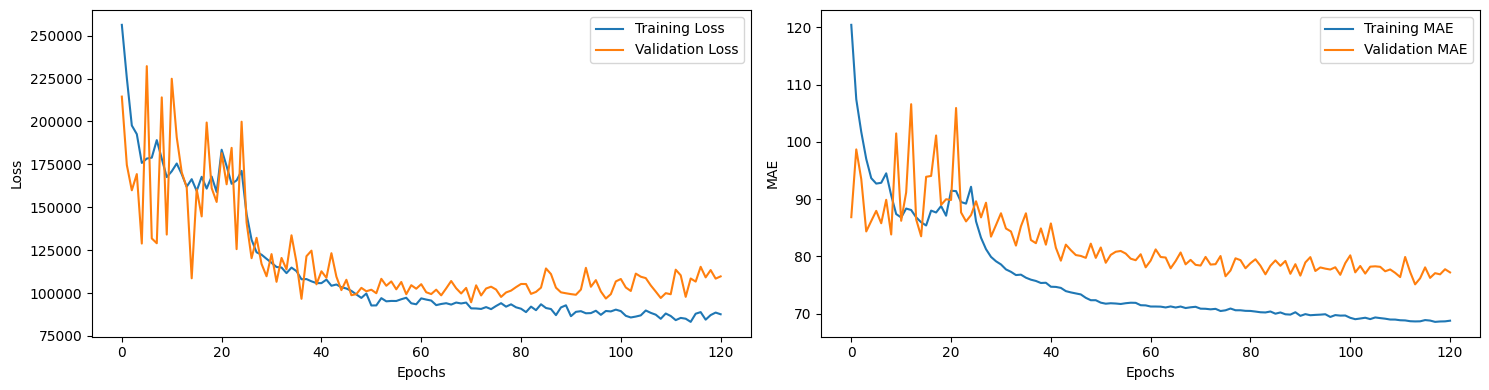

In [ ]:
# Pobieranie danych z historii
loss = history_dense_embedding.history['loss']
val_loss = history_dense_embedding.history['val_loss']
mae = history_dense_embedding.history['mae']
val_mae = history_dense_embedding.history['val_mae']

# Wizualizacja historii funkcji straty
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Wizualizacja historii metryki MAE
plt.subplot(1, 2, 2)
plt.plot(mae, label='Training MAE')
plt.plot(val_mae, label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Kodowanie 
X_train_dense_embedding = pipeline.fit_transform(X_train)
X_test_dense_embedding  = X_test.loc[X_test['ART_ID'] == 158]
padded_sequences_test_one_article = padded_sequences_test[X_test['ART_ID'] == 158]
X_test_dense_embedding = pipeline.transform(X_test_dense_embedding)
# Tworzenie predykcji
y_predict_dense_embedding = model_dense_embedding.predict([X_test_dense_embedding, padded_sequences_test_one_article])

2/2 [==============================] - 0s 5ms/step


In [ ]:
# Tworzenie DataFrame do wizualizacji
df_dense_embedding = df.loc[df['ART_ID'] == 158]
dense_pred_embedding = df_dense_embedding.loc[df_dense_embedding.index >'2022-07-10 00:00:00'][['y']]
dense_pred_embedding['y_test'] = dense_pred_embedding['y']
dense_pred_embedding = dense_pred_embedding.drop('y', axis=1)
dense_pred_embedding['y_predict'] = y_predict_dense_embedding
dense_pred_embedding.shape

(52, 2)

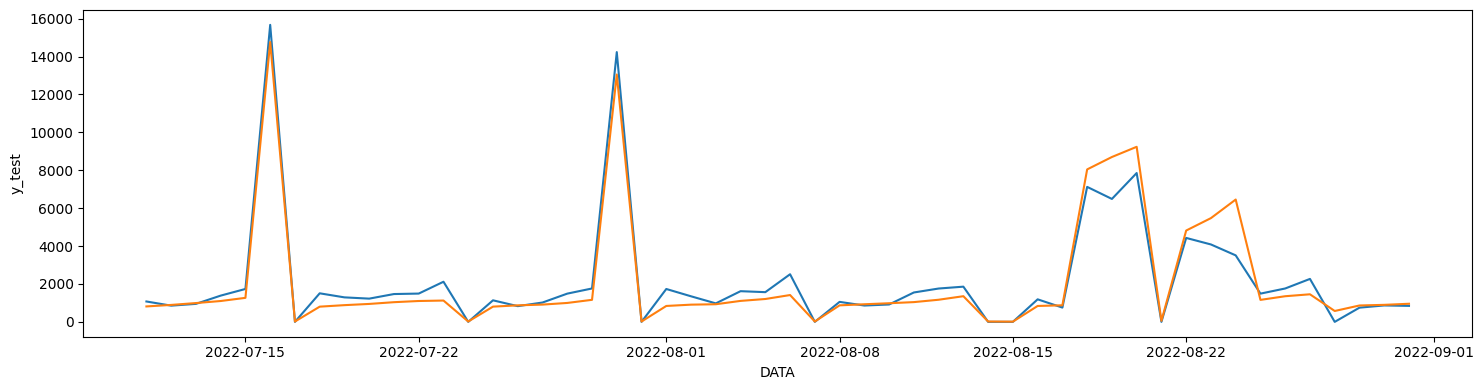

In [ ]:
# Wykres - porównanie predykcji
plt.figure(figsize=(15, 4))
sns.lineplot(data=dense_pred_embedding, x=dense_pred_embedding.index, y='y_test')
sns.lineplot(data=dense_pred_embedding, x=dense_pred_embedding.index, y='y_predict')
plt.tight_layout()
plt.show()

In [ ]:
# Metryki
mae_dense_embedding, rmse_dense_embedding, r2_dense_embedding, wmape_dense_embedding, mase_dense_embedding = ff.metryki(dense_pred_embedding['y_test'], dense_pred_embedding['y_predict'])
print(f'MAE: {mae_dense_embedding:.4f}, RMSE: {rmse_dense_embedding:.4f}, R2: {r2_dense_embedding:.4f}, WMAPE: {wmape_dense_embedding:.4f}, MASE: {mase_dense_embedding:.4f}')

MAE: 490.3275, RMSE: 743.3613, R2: 0.9404, WMAPE: 0.2441, MASE: 0.2393


In [66]:
# Komórka techniczna, do usunięcia przed publikacją
mae_dense_embedding = 490.3275
rmse_dense_embedding = 743.3613
r2_dense_embedding = 0.9404
wmape_dense_embedding = 0.2441
mase_dense_embedding = 0.2393

# Ocena

## Ocena wyników

In [67]:
# Utworzenie słownika z metrykami dla poszczególnych modeli dla jednowymiarowych szeregów czasowych
univariate_metrics = {
    'KNN': [mae_KNR, rmse_KNR, r2_KNR, wmape_KNR, mase_KNR],
    'SARIMAX': [mae_SARIMAX, rmse_SARIMAX, r2_SARIMAX, wmape_SARIMAX, mase_SARIMAX],
    'XGB Boosting': [mae_XGB, rmse_XGB, r2_XGB, wmape_XGB, mase_XGB],
    'Prophet': [mae_prophet, rmse_prophet, r2_prophet, wmape_prophet, mase_prophet ],
    'XGB+Prophet': [mae_XGB_Prophet, rmse_XGB_Prophet, r2_XGB_Prophet, wmape_XGB_Prophet, mase_XGB_Prophet],
    'Vanilla Dense': [mae_dense_vanilla, rmse_dense_vanilla, r2_dense_vanilla, wmape_dense_vanilla, mase_dense_vanilla],
    'Dense': [mae_dense, rmse_dense, r2_dense, wmape_dense, mase_dense],
    'LSTM': [mae_lstm, rmse_lstm, r2_lstm, wmape_lstm, mase_lstm ]
    }

# Tworzenie DataFrame
univariate_metrics_df = pd.DataFrame(univariate_metrics, index=['MAE', 'RMSE', 'R2', 'WMAPE', 'MASE'])
univariate_metrics_df = univariate_metrics_df.round(decimals=4)

In [68]:
# Utworzenie słownika z metrykami dla poszczególnych modeli wielowymiarowych szeregów czasowych
multivariate_metrics = {
    'XGB Boosting': [mae_XGB_2, rmse_XGB_2, r2_XGB_2, wmape_XGB_2, mase_XGB_2],
    'Dense': [mae_dense_2, rmse_dense_2, r2_dense_2, wmape_dense_2, mase_dense_2],
    'Dense+Embedding': [mae_dense_embedding, rmse_dense_embedding, r2_dense_embedding, wmape_dense_embedding, mase_dense_embedding]
    }

# Tworzenie DataFrame
multivariate_metrics_df = pd.DataFrame(multivariate_metrics, index=['MAE', 'RMSE', 'R2', 'WMAPE', 'MASE'])
multivariate_metrics_df = multivariate_metrics_df.round(decimals=4)

In [70]:
# Wyświetlenie DataFrame
univariate_metrics_df .T

MAE       RMSE      R2   WMAPE    MASE
KNN            1385.8794  2331.3765  0.4135  0.5490  0.6765
SARIMAX        1047.7151  1975.9936  0.5787  0.3844  0.5114
XGB Boosting    766.6458  1325.4833  0.8104  0.3697  0.3742
Prophet         821.7948  2020.3256  0.5553  0.2295  0.4048
XGB+Prophet     728.5372  1511.2217  0.7536  0.3224  0.3556
Vanilla Dense   455.3268   796.9039  0.9315  0.2198  0.2223
Dense           564.6660   966.9083  0.8991  0.2381  0.2756
LSTM           1631.6879  2334.8633  0.1430  0.9231  0.9952

Wyniki przedstawione w tabeli to miary jakości dla ośmiu modeli prognozowania. Oto interpretacja poszczególnych miar:

* MAE (Mean Absolute Error) - Średni błąd bezwzględny: Mierzy średnią wartość bezwzględną różnicy między rzeczywistymi wartościami a przewidywanymi wartościami. Im niższa wartość MAE, tym lepszy model. Najniższy MAE ma model 'Vanilla Dense' (455.3268), a najwyższy ma model 'LSTM' (1631.6879).

* RMSE (Root Mean Square Error) - Pierwiastek błędu średniokwadratowego: Mierzy pierwiastek średniego z kwadratów różnicy między rzeczywistymi wartościami a przewidywanymi wartościami. Im niższa wartość RMSE, tym lepszy model. Najniższy RMSE również ma model 'Vanilla Dense' (796.9039), a najwyższy ma model 'LSTM' (2334.8633).

* R2 (Coefficient of Determination) - Współczynnik determinacji: Mierzy stopień, w jakim model wyjaśnia wariancję danych. Przyjmuje wartości między 0 a 1, gdzie 1 oznacza idealne dopasowanie. Najwyższy R2 ma model 'XGB Boosting' (0.8104), a najniższy ma model 'LSTM' (0.1430).

* WMAPE (Weighted Mean Absolute Percentage Error) - Ważony średni błąd bezwzględny procentowy: Mierzy średnią wartość bezwzględną procentowej różnicy między rzeczywistymi wartościami a przewidywanymi wartościami. Im niższa wartość WMAPE, tym lepszy model. Najniższy WMAPE ma model 'XGB+Prophet' (0.3224), a najwyższy ma model 'LSTM' (0.9231).

* MASE (Mean Absolute Scaled Error) - Średni skalowany błąd bezwzględny: Miara MASE porównuje wyniki modelu względem predykcji naiwnej, która jest najprostszym modelem prognozowania. Im niższa wartość MASE, tym lepszy model. Najniższy MASE ma model 'Vanilla Dense' (0.2223), a najwyższy ma model 'LSTM' (0.9952).

Podsumowując, modele 'Vanilla Dense' i 'XGB Boosting' wydają się być najskuteczniejsze, ponieważ uzyskały najlepsze wyniki dla większości miar. Jednak należy zauważyć, że model 'XGB Boosting' osiągnął najwyższy R2, co wskazuje na lepsze wyjaśnienie wariancji danych.

In [69]:
# Wyświetlenie DataFrame
multivariate_metrics_df.T

MAE       RMSE      R2   WMAPE    MASE
XGB Boosting     739.3627  1515.0146  0.7523  0.2758  0.3609
Dense            529.8080   920.3733  0.9086  0.2332  0.2586
Dense+Embedding  490.3275   743.3613  0.9404  0.2441  0.2393

Wyniki przedstawione w tabeli to miary jakości dla trzech różnych modeli prognozowania. Oto interpretacja poszczególnych miar:

* MAE (Mean Absolute Error) - Średni błąd bezwzględny: Najniższy MAE dla modelu ma "Dense+Embedding" i wynosi 490.

* RMSE (Root Mean Square Error) - Pierwiastek błędu średniokwadratowego: Najniższy RMSE ma ponownie model "Dense+Embedding", co wskazuje na mniejszą wariancję błędu prognoz w tym modelu.

* R2 (Coefficient of Determination) - Współczynnik determinacji: Najwyższy R2 ma model "Dense+Embedding", wynosi on 0.9404, co oznacza, że ten model lepiej wyjaśnia wariancję danych.

* WMAPE (Weighted Mean Absolute Percentage Error) - Ważony średni błąd bezwzględny procentowy: Wartość WMAPE dla modelu "XGB Boosting" wynosi 0.2758, dla modelu "Dense" wynosi 0.2332, a dla modelu "Dense+Embedding" wynosi 0.2441. Najniższy WMAPE ma model "Dense", co sugeruje mniejszą procentową różnicę między przewidywanymi a rzeczywistymi wartościami.

* MASE (Mean Absolute Scaled Error) - Średni skalowany błąd bezwzględny: Najniższy MASE ma ponownie model "Dense+Embedding", wynosi 0.2393, co sugeruje mniejszą znormalizowaną różnicę między przewidywanymi a rzeczywistymi wartościami.

Podsumowując, model "Dense+Embedding" osiąga najlepsze wyniki dla większości miar, co sugeruje, że jest najskuteczniejszy w prognozowaniu wartości. 

# Wdrożenie

## Planowane wdrożenie

Możliwość wdrożenia modelu sieci neuronowej Dense z warstwą embedding, który uzyskał najlepsze wyniki, może przynieść wiele korzyści. Jednak przed wdrożeniem takiego modelu do produkcji konieczne jest spełnienie pewnych warunków i zapewnienie odpowiedniej infrastruktury technicznej.

Warunki do wdrożenia modelu sieci neuronowej Dense z warstwą embedding:

- Stabilny pipeline przygotowujący dane wejściowe: Konieczne jest stworzenie stabilnego i skalowalnego procesu przygotowywania danych wejściowych dla modelu. Obejmuje to tokenizację tekstu, przekształcenie go na reprezentacje liczbowe za pomocą embeddingu, a także ewentualne normalizacje czy oczyszczanie danych. Ważne jest, aby ten pipeline był niezawodny i elastyczny, aby móc obsłużyć zmieniające się dane.

- Infrastruktura techniczna: Aby wdrożyć model do produkcji, niezbędna jest odpowiednia infrastruktura techniczna. Może to obejmować wystarczającą moc obliczeniową, dostęp do zasobów GPU, skalowalne środowisko działające na chmurze, odpowiednie narzędzia i biblioteki do obsługi modelu oraz system monitorowania i zarządzania.

Kroki wdrożenia modelu do produkcji:

1. Przygotowanie danych: Zapewnienie stabilnego i skonfigurowanego pipeline'u do przygotowania danych wejściowych.

2. Trening i optymalizacja modelu: Wykonanie treningu i optymalizacji modelu na odpowiednio przygotowanych danych. To obejmuje dobór optymalnych hiperparametrów, walidację krzyżową i monitorowanie metryk jakości modelu.

3. Implementacja modelu: Implementacja modelu w środowisku produkcyjnym, które może obejmować chmurę lub lokalne zasoby. Wymaga to odpowiedniego dostosowania kodu modelu do środowiska produkcyjnego oraz integracji z innymi komponentami systemu.

4. Testowanie i weryfikacja: Przeprowadzenie wnikliwego testowania i weryfikacji modelu w środowisku produkcyjnym, aby upewnić się, że działa zgodnie z oczekiwaniami i dostarcza dokładne predykcje.

**Plusy:**

Model sieci neuronowej Dense z warstwą embedding może zapewnić dobre wyniki w analizie szeregów czasowych, zwłaszcza jeśli występują zależności semantyczne między słowami/artykułami.
Może poprawić zdolność modelu do rozpoznawania wzorców współwystępujących między artykułami o podobnej nazwie.

**Minusy:**

Wdrożenie modelu sieci neuronowej Dense z warstwą embedding wymaga odpowiednich zasobów obliczeniowych i infrastruktury technicznej.
Model może wymagać dużych zbiorów danych treningowych i długiego czasu treningu, co może być kosztowne.

**Szanse:**

Możliwość poprawy dokładności i skuteczności modelu w analizie tekstów.
Może znacząco poprawić rozpoznawanie wzorców i predykcję wystęoujących w szeregach czasowych.

**Zagrożenia:**

Model może być wrażliwy na jakość danych wejściowych i może dawać złe wyniki w przypadku braku odpowiednich danych treningowych.
Może wystąpić potrzeba częstego aktualizowania modelu, aby uwzględniać zmieniające się trendy i zależności semantyczne w tekście.